In [1]:
from qtpg.team import Team
from qtpg.learner import Learner
from qtpg.program import Program
from qtpg.rule import Rule
from qtpg.figure13 import Figure13
from qtpg.figure13_hole_in_wall import Figure13HoleInWall
from qtpg.figure12 import Figure12
from qtpg.figure9 import Figure9
from qtpg.figureRandom import FigureRandom
from qtpg.figureHeywood import FigureHeywood
from qtpg.search_manager import SearchManager
from qtpg.results_manager import ResultsManager
import numpy as np
import uuid
import copy
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
gp_query_env = 0
gp_query_runs = []

In [3]:
# env params
memorySize = 40
legalMove = 0.1
illegalMove = -0.01
outOfBounds = 0.0
memoryRepeat = -0.01
goalReached = 100

# envName = 'Figure 13 no reinforcements'
# env = Figure13(5, 5, (2, 4), (0, 0), memorySize, 0.1, -0.01, 0.0, -0.01, 0.1)
# envName = 'Figure 13'
# env = Figure13(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 13 Hole in Wall'
# env = Figure13HoleInWall(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 12'
# env = Figure12(5, 5, (4, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 9'
# env = Figure9(10, 10, (4, 9), (0, 3), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Heywood'
# env = FigureHeywood(10, 10, (4, 4), (0, 4), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Random'
env = FigureRandom(20, 20, memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# env.shake(0.2)

In [ ]:
# env.save()

In [ ]:
# env.load('f5e46ad0-c274-415c-b831-7b1893ea9694', False)
# import random
# # new start-goal parameter generator... might want to put this in .env file, where a new id gets generated...
# new_start = (0, 0)
# new_goal = (0, 0)

# while new_start == (0, 0) or new_start in env.illegal_states:
#     new_start = (random.randint(0, env.rows-1), random.randint(0, env.cols-1))

# while new_goal == (0, 0) or new_goal in env.illegal_states:
#     new_goal = (random.randint(0, env.rows-1), random.randint(0, env.cols-1))

# print(f'New start: {new_start}')
# print(f'New goal: {new_goal}')

In [4]:
# envName = ''
plotName = '202011'
envName = '20x20#1sg#1'
save = False
load = True
numGens = 150
maxTeamPool = 5
runs = 30
# 20x20 #1
# start-goal #1 for 20x20 #1 --> default load
if envName == '20x20#1sg#1':
    env.load('592726fe-a9e1-46fc-99c3-fc97ffeb4b51')
# start-goal #2 for 20x20 #1
elif envName == '20x20#1sg#2':
    env.load('592726fe-a9e1-46fc-99c3-fc97ffeb4b51', False)
    env.start_state = (15, 15)
    env.current_state = env.start_state
    env.win_state = (3, 8)
    env.display()
# start-goal #3 for 20x20 #2
elif envName == '20x20#1sg#3':
    env.load('592726fe-a9e1-46fc-99c3-fc97ffeb4b51', False)
    env.start_state = (12, 19)
    env.current_state = env.start_state
    env.win_state = (9, 13)
    env.display()
elif envName == '20x20#1sg#4':
    env.load('592726fe-a9e1-46fc-99c3-fc97ffeb4b51', False)
    env.start_state = (15, 17)
    env.current_state = env.start_state
    env.win_state = (0, 15)
    env.display()
elif envName == '20x20#1sg#5':
    env.load('592726fe-a9e1-46fc-99c3-fc97ffeb4b51', False)
    env.start_state = (15, 11)
    env.current_state = env.start_state
    env.win_state = (10, 7)
    env.display()
elif envName == '20x20#2sg#1':
    env.load('00840a8c-af04-4a3e-b427-451ab41f3301')
elif envName == '20x20#2sg#2':
    env.load('00840a8c-af04-4a3e-b427-451ab41f3301', False)
    env.start_state = (10, 2)
    env.current_state = env.start_state
    env.win_state = (6, 18)
    env.display()
elif envName == '20x20#2sg#3':
    env.load('00840a8c-af04-4a3e-b427-451ab41f3301', False)
    env.start_state = (0, 15)
    env.current_state = env.start_state
    env.win_state = (14, 0)
    env.display()
elif envName == '20x20#2sg#4':
    env.load('00840a8c-af04-4a3e-b427-451ab41f3301', False)
    env.start_state = (9, 4)
    env.current_state = env.start_state
    env.win_state = (15, 0)
    env.display()
elif envName == '20x20#2sg#5':
    env.load('00840a8c-af04-4a3e-b427-451ab41f3301', False)
    env.start_state = (14, 16)
    env.current_state = env.start_state
    env.win_state = (8, 5)
    env.display()
elif envName == '20x20#3sg#1':
    env.load('2ca23d5d-788e-44df-9ca1-96b18b9c223f')
elif envName == '20x20#3sg#2':
    env.load('2ca23d5d-788e-44df-9ca1-96b18b9c223f', False)
    env.start_state = (7, 9)
    env.current_state = env.start_state
    env.win_state = (17, 10)
    env.display()
elif envName == '20x20#3sg#3':
    env.load('2ca23d5d-788e-44df-9ca1-96b18b9c223f', False)
    env.start_state = (3, 2)
    env.current_state = env.start_state
    env.win_state = (0, 14)
    env.display()
elif envName == '20x20#3sg#4':
    env.load('2ca23d5d-788e-44df-9ca1-96b18b9c223f', False)
    env.start_state = (0, 13)
    env.current_state = env.start_state
    env.win_state = (15, 18)
    env.display()
elif envName == '20x20#3sg#5':
    env.load('2ca23d5d-788e-44df-9ca1-96b18b9c223f', False)
    env.start_state = (1, 8)
    env.current_state = env.start_state
    env.win_state = (3, 14)
    env.display()
# 50x50s
elif envName == '50x50#1sg#1':
    env.load('f5e46ad0-c274-415c-b831-7b1893ea9694')
elif envName == '50x50#1sg#2':
    env.load('f5e46ad0-c274-415c-b831-7b1893ea9694', False)
    env.start_state = (16, 46)
    env.current_state = env.start_state
    env.win_state = (20, 1)
    env.display()
elif envName == '50x50#1sg#3':
    env.load('f5e46ad0-c274-415c-b831-7b1893ea9694', False)
    env.start_state = (3, 12)
    env.current_state = env.start_state
    env.win_state = (14, 43)
    env.display()
elif envName == '50x50#1sg#4':
    env.load('f5e46ad0-c274-415c-b831-7b1893ea9694', False)
    env.start_state = (37, 17)
    env.current_state = env.start_state
    env.win_state = (20, 46)
    env.display()
elif envName == '50x50#1sg#5':
    env.load('f5e46ad0-c274-415c-b831-7b1893ea9694', False)
    env.start_state = (20, 11)
    env.current_state = env.start_state
    env.win_state = (42, 25)
    env.display()

Loading env...
Env loaded successfully!
Rows: 20
Columns: 20
Start State: (17, 4)
Win State: (5, 8)
Illegal States: [(14, 4), (15, 18), (3, 3), (18, 2), (6, 11), (6, 4), (10, 6), (19, 10), (5, 2), (3, 4), (4, 1), (2, 10), (4, 10), (15, 2), (12, 13), (6, 15), (13, 4), (6, 8), (9, 6), (16, 10), (19, 5), (19, 2), (16, 0), (15, 8), (7, 11), (18, 5), (19, 12), (0, 17), (15, 19), (18, 19), (0, 18), (6, 1), (18, 4), (9, 18), (17, 15), (2, 6), (5, 1), (8, 18), (18, 12), (15, 4), (4, 2), (11, 5), (2, 3), (3, 19), (0, 11), (2, 18), (13, 18), (12, 6), (18, 17), (12, 5), (14, 17), (19, 9), (10, 18), (1, 4), (10, 13), (5, 19), (5, 3), (6, 18), (11, 10), (12, 3), (7, 14), (0, 7), (0, 8), (7, 0), (9, 5), (8, 7), (0, 6), (17, 3), (19, 4), (12, 12), (15, 14), (18, 11), (9, 16), (18, 0), (3, 16), (9, 3), (10, 17), (10, 15), (2, 1), (2, 2)]
matlab code, converted so plus one to everything
GW.CurrentState = '[3,5]';
GW.TerminalStates = '[15,9]';
GW.ObstacleStates = ["[6,5]";"[5,19]";"[17,4]";"[2,3]";"[14,

In [ ]:
# init search manager and starting teams

# searchManager = SearchManager(maxTeamPool)

# variables for tracking fitness, for curves
scores = []
gens = []
maxes = []
averages = []
mins = []

run_winners = []
runs_score_track = []

for run in range(runs):
    gp_query_env = 0
    maxes = []
    averages = []
    mins = []
    gens = []
    print(run)
    # init everything for new run
    searchManager = SearchManager(maxTeamPool)
    
    adam_and_eve = []
    env.reset()
    init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
    init_team.init_search(env, [2, 3])
#     adam_and_eve.append(init_team)
#     init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
#     init_team.init_search(env, [0, 1])
    adam_and_eve.append(init_team)
    win = False
    for adam in adam_and_eve:
        data = [adam, win]
        searchManager.evaluate_team(data)
    
    
    average_coverage = 0.0
    gen = 0
    for gen in range(numGens):
#     while (average_coverage < 0.4) and (len(searchManager.winners) < maxTeamPool):
#         print(average_coverage)
#         print('winners so far:')
#         print(searchManager.winners)
        print(f'GEN --> {gen}')
        gen += 1
        toEvaluateAfterGen = []
        scores = []
        # get it started
        for parent in searchManager.teamPool:
            # only run if the team has not yet won
            if parent not in searchManager.winners:
                env.current_state = parent.start_state

                # make offspring from parent, then let that offspring make a new rule
                child = copy.deepcopy(parent)

                child.gp_query_env = parent.gp_query_env # probably don't need this, can test later
                child.id = uuid.uuid4()
                child.gen_created = gen
                win = child.search_no_back_track(env)
                
                if child.mostRecent.program.rule.region[3] - child.mostRecent.program.rule.region[2] >= 0:
                    gp_query_env += (child.mostRecent.program.rule.region[3] - child.mostRecent.program.rule.region[2]) + 1
                
                toEvaluateAfterGen.append([child, win])
                scores.append(child)
            else:
                scores.append(parent)

        for data in toEvaluateAfterGen:
            searchManager.evaluate_team(data)
        # start: manage fitness curves (at end of gen)
        gens.append(gen)
        total = 0
        max_fitness = -100
        min_fitness = 100

        for team in scores:
            total += team.fitness
            if team.fitness > max_fitness:
                max_fitness = team.fitness
            if team.fitness < min_fitness:
                min_fitness = team.fitness
        average_fitness = total / len(searchManager.teamPool)
        maxes.append(max_fitness)
        averages.append(average_fitness)
        mins.append(min_fitness)
        
        # find average region coverage
        total_coverage = 0.0
        for team in searchManager.teamPool:
            total_coverage += team.coverage([env.rows, env.cols], env.illegal_states)
        average_coverage = total_coverage / len(searchManager.teamPool)

    runs_score_track.append({'run': run, 'maxes': maxes, 'averages': averages, 'mins': mins})
    
    run_winners.append({'run': run, 'winners': searchManager.winners})
    gp_query_runs.append(gp_query_env)
    print(gp_query_env)

In [ ]:
#fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for average in averages:
#     y.append(average)
# plt.xlabel('Generation')
# plt.ylabel('Average Score')
# plt.plot(x, y)
# plt.show()

In [ ]:
# #fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for max_ in maxes:
#     y.append(max_)
# plt.xlabel('Generation')
# plt.ylabel('Max Score')
# plt.plot(x, y)
# plt.show()

In [ ]:
# for team in searchManager.winners:
#     print('$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$')
#     print(team.fitness)
#     print('Learners:')
#     for learner in team.learners:
#         print(f'Region: {learner.program.rule.region} --> Action: {learner.program.rule.action_set}')
#     print('$$$$$$$$$$$$$ winnnnnner end $$$$$$$$$$$$$$$$$$$$')

In [ ]:
for team in searchManager.winners:

    region_action_scores = []
    for learner in team.learners:
        if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
            region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
        else:
            region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

    sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)
    # print(sorted_region_action_scores)
    # for record in sorted_region_action_scores:
    #     print(record)
    action_states = []
    for record in sorted_region_action_scores:
        action = ''
        if record['action'] == 0:
            action = '\u2191'
        elif record['action'] == 1:
            action = '\u2193'
        elif record['action'] == 2:
            action = '\u2192'
        elif record['action'] == 3:
            action = '\u2190'

        for i in range(record['region'][3] - record['region'][2]+1):
            state = [0, 0]
            state[record['region'][0]] = record['region'][1]
            state[not record['region'][0]] = record['region'][2] + i

            # ensure we do not enter duplicate states
            found = 0
            for pair in action_states:
                if pair['state'] == (state[0], state[1]):
                    found = 1

            if found == 0:
                action_states.append({'state': (state[0], state[1]), 'action': action, 'q': record['q'] })

    # add in the rest of the states, either they are not visited, or illegal
#     for n in reversed(range(env.rows)):
#         for m in range(env.cols):
#             action = ''
#             found = 0
#             for record in action_states:
#                 if record['state'] == (n, m):
#                     found = 1
#                     action = record['action']
#     #                 action = float(round(record['q'], 0))
#             if found == 0:
#                 if not env.check_legal((n, m)):
#                     action = 'X'
#                 else:
#                     action = '?'
#             print(f'{action} ', end='')
#         print('\n')
#     print('------------NEW WINNER ----------------')

## Average Max Fitness Curves

In [ ]:
selected_run = 0

print(runs_score_track[selected_run]['maxes'])

In [ ]:
# #fitness curves
x = []
y = []
average_maxes = np.zeros(numGens)
# average_maxes = np.zeros(100)

for i in range(len(gens)):
    for q in range(len(runs_score_track)):
        average_maxes[i] += runs_score_track[q]['maxes'][i]
    average_maxes[i] /= len(runs_score_track)
    
for gen in gens:
    x.append(gen)

# plt.title(f'Average max score over {len(runs_score_track)} runs for {envName}')
plt.title(f'Average max score over {len(runs_score_track)} runs')
plt.xlabel('Generation')
plt.ylabel('Average Max Score')
plt.plot(x, average_maxes)

plt.savefig(f'qtpg/fitness_curves/{plotName}.png')

plt.show()

## Reinforcement Learning + Victory Lap

In [5]:
if load == True:
    runs = 30
    resultsManager = ResultsManager()
    run_winners, loadedQueryTotals, win_loss = resultsManager.load_champions(envName)
    print(loadedQueryTotals)
    run_count = 0
    for run in range(runs):
        if (run_count >= len(run_winners)):
            run_winners.append({'run': run_count, 'winners': []})
        elif run_winners[run]['run'] != run_count:
            run_winners.insert(run_count, {'run': run_count, 'winners': []})
        run_count += 1
    for run in run_winners:
    #     print(run)
        for champ in run['winners']:
            print(champ.id)
else:
    print('not loading!')

Loading champions...
<class 'float'>
[0, 17, 4, 11]
0.9899999999999999
region index type: <class 'int'>
<class 'float'>
[0, 17, 13, 14]
0.9899999999999999
region index type: <class 'int'>
<class 'float'>
[1, 12, 13, 16]
0.74
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 6]
1.6900000000000004
region index type: <class 'int'>
<class 'float'>
[0, 17, 8, 14]
1.6900000000000004
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 12]
1.7000000000000004
region index type: <class 'int'>
<class 'float'>
[1, 7, 14, 19]
1.7000000000000004
region index type: <class 'int'>
<class 'float'>
[0, 13, 5, 8]
1.35
region index type: <class 'int'>
<class 'float'>
[0, 13, 10, 17]
1.35
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 4]
2.9700000000000006
region index type: <class 'int'>
<class 'float'>
[1, 9, 6, 18]
2.9700000000000006
region index type: <class 'int'>
<class 'float'>
[0, 5, 8, 9]
100.1
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 11]
0.9899999999

<class 'float'>
[0, 18, 6, 6]
0.47
region index type: <class 'int'>
<class 'float'>
[0, 18, 8, 10]
0.47
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 15]
1.8000000000000007
region index type: <class 'int'>
<class 'float'>
[1, 7, 17, 19]
1.8000000000000007
region index type: <class 'int'>
<class 'float'>
[0, 16, 1, 8]
0.9699999999999999
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 9]
3.2299999999999995
region index type: <class 'int'>
<class 'float'>
[1, 9, 11, 18]
3.2299999999999995
region index type: <class 'int'>
<class 'float'>
[0, 10, 7, 7]
0.66
region index type: <class 'int'>
<class 'float'>
[0, 10, 9, 12]
0.66
region index type: <class 'int'>
<class 'float'>
[1, 8, 7, 8]
1.04
region index type: <class 'int'>
<class 'float'>
[1, 8, 10, 14]
1.04
region index type: <class 'int'>
<class 'float'>
[0, 9, 7, 8]
0.87
region index type: <class 'int'>
<class 'float'>
[0, 9, 10, 15]
0.87
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 6]
2.590000000000

<class 'float'>
[1, 17, 11, 12]
0.27
region index type: <class 'int'>
<class 'float'>
[0, 13, 5, 15]
2.2600000000000002
region index type: <class 'int'>
<class 'float'>
[0, 13, 17, 17]
2.2600000000000002
region index type: <class 'int'>
<class 'float'>
[1, 16, 10, 15]
1.1500000000000001
region index type: <class 'int'>
<class 'float'>
[1, 16, 17, 19]
1.1500000000000001
region index type: <class 'int'>
<class 'float'>
[0, 16, 11, 17]
1.23
region index type: <class 'int'>
<class 'float'>
[0, 16, 19, 19]
1.23
region index type: <class 'int'>
<class 'float'>
[1, 18, 17, 19]
0.28
region index type: <class 'int'>
<class 'float'>
[0, 16, 11, 13]
0.8599999999999999
region index type: <class 'int'>
<class 'float'>
[0, 16, 15, 19]
0.8599999999999999
region index type: <class 'int'>
<class 'float'>
[1, 14, 16, 16]
0.56
region index type: <class 'int'>
<class 'float'>
[1, 14, 18, 19]
0.56
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 6]
1.8700000000000006
region index type: <class 'i

region index type: <class 'int'>
<class 'float'>
[0, 14, 5, 10]
2.0600000000000005
region index type: <class 'int'>
<class 'float'>
[0, 14, 12, 16]
2.0600000000000005
region index type: <class 'int'>
<class 'float'>
[1, 11, 8, 13]
1.4100000000000004
region index type: <class 'int'>
<class 'float'>
[1, 11, 15, 17]
1.4100000000000004
region index type: <class 'int'>
<class 'float'>
[0, 14, 5, 12]
1.4800000000000002
region index type: <class 'int'>
<class 'float'>
[0, 14, 14, 16]
1.4800000000000002
region index type: <class 'int'>
<class 'float'>
[1, 13, 13, 14]
0.6599999999999999
region index type: <class 'int'>
<class 'float'>
[1, 13, 16, 19]
0.6599999999999999
region index type: <class 'int'>
<class 'float'>
[0, 15, 9, 10]
0.3400000000000001
region index type: <class 'int'>
<class 'float'>
[0, 15, 12, 13]
0.3400000000000001
region index type: <class 'int'>
<class 'float'>
[1, 11, 8, 12]
1.5100000000000002
region index type: <class 'int'>
<class 'float'>
[1, 11, 14, 17]
1.51000000000000

<class 'float'>
[1, 11, 14, 17]
1.2400000000000002
region index type: <class 'int'>
<class 'float'>
[0, 13, 5, 11]
1.7300000000000004
region index type: <class 'int'>
<class 'float'>
[0, 13, 13, 17]
1.7300000000000004
region index type: <class 'int'>
<class 'float'>
[1, 12, 13, 13]
0.75
region index type: <class 'int'>
<class 'float'>
[1, 12, 15, 17]
0.75
region index type: <class 'int'>
<class 'float'>
[0, 14, 5, 6]
1.7200000000000004
region index type: <class 'int'>
<class 'float'>
[0, 14, 8, 16]
1.7200000000000004
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 9]
1.4400000000000002
region index type: <class 'int'>
<class 'float'>
[1, 7, 11, 19]
1.4400000000000002
region index type: <class 'int'>
<class 'float'>
[0, 10, 7, 11]
0.9299999999999998
region index type: <class 'int'>
<class 'float'>
[1, 12, 0, 1]
1.9900000000000007
region index type: <class 'int'>
<class 'float'>
[1, 12, 3, 11]
1.9900000000000007
region index type: <class 'int'>
<class 'float'>
[0, 2, 11, 13]
1

2.130000000000001
region index type: <class 'int'>
<class 'float'>
[0, 7, 1, 8]
1.6100000000000003
region index type: <class 'int'>
<class 'float'>
[0, 7, 10, 10]
1.6100000000000003
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 12]
2.7500000000000013
region index type: <class 'int'>
<class 'float'>
[1, 9, 14, 18]
2.7500000000000013
region index type: <class 'int'>
<class 'float'>
[0, 13, 5, 10]
1.5400000000000005
region index type: <class 'int'>
<class 'float'>
[0, 13, 12, 17]
1.5400000000000005
region index type: <class 'int'>
<class 'float'>
[1, 11, 8, 12]
1.2400000000000002
region index type: <class 'int'>
<class 'float'>
[1, 11, 14, 17]
1.2400000000000002
region index type: <class 'int'>
<class 'float'>
[0, 13, 6, 17]
1.7300000000000004
region index type: <class 'int'>
<class 'float'>
[1, 5, 13, 15]
0.74
region index type: <class 'int'>
<class 'float'>
[1, 5, 17, 17]
0.74
region index type: <class 'int'>
<class 'float'>
[0, 16, 1, 7]
1.1500000000000001
region index typ

2.2600000000000007
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 0]
2.220000000000001
region index type: <class 'int'>
<class 'float'>
[1, 9, 2, 18]
2.220000000000001
region index type: <class 'int'>
<class 'float'>
[0, 1, 5, 14]
2.3000000000000007
region index type: <class 'int'>
<class 'float'>
[0, 1, 16, 19]
2.3000000000000007
region index type: <class 'int'>
<class 'float'>
[1, 15, 0, 3]
0.85
region index type: <class 'int'>
<class 'float'>
[1, 15, 5, 5]
0.85
region index type: <class 'int'>
<class 'float'>
[0, 4, 11, 17]
1.1400000000000001
region index type: <class 'int'>
<class 'float'>
[0, 4, 19, 19]
1.1400000000000001
region index type: <class 'int'>
<class 'float'>
[1, 18, 3, 4]
0.27
region index type: <class 'int'>
<class 'float'>
[0, 5, 8, 18]
100.97
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 4]
0.9899999999999999
region index type: <class 'int'>
<class 'float'>
[0, 17, 6, 14]
0.9899999999999999
region index type: <class 'int'>
<class 'float'>
[

<class 'float'>
[0, 16, 1, 5]
1.4100000000000004
region index type: <class 'int'>
<class 'float'>
[0, 16, 7, 9]
1.4100000000000004
region index type: <class 'int'>
<class 'float'>
[1, 6, 13, 13]
0.85
region index type: <class 'int'>
<class 'float'>
[1, 6, 15, 19]
0.85
region index type: <class 'int'>
<class 'float'>
[0, 14, 5, 6]
1.9800000000000006
region index type: <class 'int'>
<class 'float'>
[0, 14, 8, 16]
1.9800000000000006
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 9]
1.4300000000000002
region index type: <class 'int'>
<class 'float'>
[1, 7, 11, 19]
1.4300000000000002
region index type: <class 'int'>
<class 'float'>
[0, 10, 7, 8]
0.9399999999999998
region index type: <class 'int'>
<class 'float'>
[0, 10, 10, 12]
0.9399999999999998
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 15]
2.680000000000001
region index type: <class 'int'>
<class 'float'>
[1, 9, 17, 18]
2.680000000000001
region index type: <class 'int'>
<class 'float'>
[0, 16, 1, 5]
0.78
regio

<class 'float'>
[0, 1, 3, 3]
0.4300000000000001
region index type: <class 'int'>
<class 'float'>
[1, 2, 1, 1]
0.17000000000000004
region index type: <class 'int'>
<class 'float'>
[0, 0, 0, 4]
0.62
region index type: <class 'int'>
<class 'float'>
[1, 5, 1, 8]
0.7899999999999999
region index type: <class 'int'>
<class 'float'>
[0, 0, 0, 4]
0.8899999999999999
region index type: <class 'int'>
<class 'float'>
[1, 5, 0, 5]
0.7100000000000001
region index type: <class 'int'>
<class 'float'>
[1, 5, 7, 8]
0.7100000000000001
region index type: <class 'int'>
<class 'float'>
[0, 6, 5, 5]
0.36000000000000004
region index type: <class 'int'>
<class 'float'>
[0, 6, 7, 7]
0.36000000000000004
region index type: <class 'int'>
<class 'float'>
[1, 6, 3, 3]
0.74
region index type: <class 'int'>
<class 'float'>
[1, 6, 5, 8]
0.74
region index type: <class 'int'>
<class 'float'>
[0, 4, 3, 8]
0.84
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 15]
2.140000000000001
region index type: <class 'int'>


<class 'float'>
[0, 14, 12, 16]
1.5300000000000002
region index type: <class 'int'>
<class 'float'>
[1, 11, 8, 14]
1.4200000000000004
region index type: <class 'int'>
<class 'float'>
[1, 11, 16, 17]
1.4200000000000004
region index type: <class 'int'>
<class 'float'>
[0, 15, 9, 10]
0.57
region index type: <class 'int'>
<class 'float'>
[0, 15, 12, 13]
0.57
region index type: <class 'int'>
<class 'float'>
[1, 11, 8, 13]
1.06
region index type: <class 'int'>
<class 'float'>
[1, 11, 15, 17]
1.06
region index type: <class 'int'>
<class 'float'>
[0, 14, 5, 10]
1.6200000000000003
region index type: <class 'int'>
<class 'float'>
[0, 14, 12, 16]
1.6200000000000003
region index type: <class 'int'>
<class 'float'>
[1, 11, 8, 12]
1.4300000000000002
region index type: <class 'int'>
<class 'float'>
[1, 11, 14, 17]
1.4300000000000002
region index type: <class 'int'>
<class 'float'>
[0, 13, 5, 7]
1.7100000000000006
region index type: <class 'int'>
<class 'float'>
[0, 13, 9, 17]
1.7100000000000006
regio

<class 'float'>
[1, 13, 18, 19]
1.14
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 6]
1.7800000000000005
region index type: <class 'int'>
<class 'float'>
[0, 17, 8, 14]
1.7800000000000005
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 10]
1.17
region index type: <class 'int'>
<class 'float'>
[1, 7, 12, 19]
1.17
region index type: <class 'int'>
<class 'float'>
[0, 11, 6, 8]
0.37000000000000005
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 15]
2.5999999999999996
region index type: <class 'int'>
<class 'float'>
[1, 9, 17, 18]
2.5999999999999996
region index type: <class 'int'>
<class 'float'>
[0, 16, 2, 9]
1.5000000000000002
region index type: <class 'int'>
<class 'float'>
[1, 1, 7, 15]
2.0000000000000004
region index type: <class 'int'>
<class 'float'>
[1, 1, 17, 19]
2.0000000000000004
region index type: <class 'int'>
<class 'float'>
[0, 16, 1, 6]
1.5100000000000002
region index type: <class 'int'>
<class 'float'>
[0, 16, 8, 9]
1.5100000000000002
re

<class 'float'>
[0, 14, 5, 6]
2.0700000000000007
region index type: <class 'int'>
<class 'float'>
[0, 14, 8, 16]
2.0700000000000007
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 14]
1.4500000000000002
region index type: <class 'int'>
<class 'float'>
[1, 7, 16, 19]
1.4500000000000002
region index type: <class 'int'>
<class 'float'>
[0, 15, 5, 6]
0.18
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 16]
1.5200000000000002
region index type: <class 'int'>
<class 'float'>
[1, 7, 18, 19]
1.5200000000000002
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 6]
1.6000000000000003
region index type: <class 'int'>
<class 'float'>
[0, 17, 8, 14]
1.6000000000000003
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 13]
1.6900000000000004
region index type: <class 'int'>
<class 'float'>
[1, 7, 15, 19]
1.6900000000000004
region index type: <class 'int'>
<class 'float'>
[0, 14, 5, 8]
1.8800000000000006
region index type: <class 'int'>
<class 'float'>
[0, 14, 1

1.9800000000000006
region index type: <class 'int'>
<class 'float'>
[0, 14, 9, 16]
1.9800000000000006
region index type: <class 'int'>
<class 'float'>
[1, 8, 7, 9]
0.6799999999999999
region index type: <class 'int'>
<class 'float'>
[1, 8, 11, 14]
0.6799999999999999
region index type: <class 'int'>
<class 'float'>
[0, 10, 7, 11]
0.85
region index type: <class 'int'>
<class 'float'>
[1, 12, 0, 1]
1.9900000000000007
region index type: <class 'int'>
<class 'float'>
[1, 12, 3, 11]
1.9900000000000007
region index type: <class 'int'>
<class 'float'>
[0, 2, 11, 16]
0.6699999999999999
region index type: <class 'int'>
<class 'float'>
[1, 17, 2, 9]
1.4200000000000002
region index type: <class 'int'>
<class 'float'>
[0, 1, 5, 8]
2.4600000000000004
region index type: <class 'int'>
<class 'float'>
[0, 1, 10, 19]
2.4600000000000004
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 5]
3.329999999999999
region index type: <class 'int'>
<class 'float'>
[1, 9, 7, 18]
3.329999999999999
region ind

<class 'float'>
[0, 9, 10, 15]
0.7799999999999999
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 12]
2.580000000000001
region index type: <class 'int'>
<class 'float'>
[1, 9, 14, 18]
2.580000000000001
region index type: <class 'int'>
<class 'float'>
[0, 13, 5, 8]
1.8000000000000005
region index type: <class 'int'>
<class 'float'>
[0, 13, 10, 17]
1.8000000000000005
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 3]
2.9700000000000006
region index type: <class 'int'>
<class 'float'>
[1, 9, 5, 18]
2.9700000000000006
region index type: <class 'int'>
<class 'float'>
[0, 4, 3, 8]
1.13
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 16]
2.160000000000001
region index type: <class 'int'>
<class 'float'>
[1, 9, 18, 18]
2.160000000000001
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 10]
1.4500000000000002
region index type: <class 'int'>
<class 'float'>
[0, 17, 12, 14]
1.4500000000000002
region index type: <class 'int'>
<class 'float'>
[1, 11, 8, 1

[0, 18, 6, 8]
0.56
region index type: <class 'int'>
<class 'float'>
[0, 18, 10, 10]
0.56
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 14]
3.429999999999999
region index type: <class 'int'>
<class 'float'>
[1, 9, 16, 18]
3.429999999999999
region index type: <class 'int'>
<class 'float'>
[0, 15, 9, 10]
0.74
region index type: <class 'int'>
<class 'float'>
[0, 15, 12, 13]
0.74
region index type: <class 'int'>
<class 'float'>
[1, 11, 8, 8]
1.06
region index type: <class 'int'>
<class 'float'>
[1, 11, 10, 17]
1.06
region index type: <class 'int'>
<class 'float'>
[0, 9, 7, 11]
1.1300000000000001
region index type: <class 'int'>
<class 'float'>
[0, 9, 13, 15]
1.1300000000000001
region index type: <class 'int'>
<class 'float'>
[1, 12, 0, 2]
1.2500000000000002
region index type: <class 'int'>
<class 'float'>
[1, 12, 4, 11]
1.2500000000000002
region index type: <class 'int'>
<class 'float'>
[0, 3, 5, 8]
1.6100000000000003
region index type: <class 'int'>
<class 'float'>
[0, 3, 10, 

[0, 14, 5, 14]
1.2500000000000002
region index type: <class 'int'>
<class 'float'>
[0, 14, 16, 16]
1.2500000000000002
region index type: <class 'int'>
<class 'float'>
[1, 15, 11, 15]
0.66
region index type: <class 'int'>
<class 'float'>
[0, 16, 11, 15]
1.1400000000000001
region index type: <class 'int'>
<class 'float'>
[0, 16, 17, 19]
1.1400000000000001
region index type: <class 'int'>
<class 'float'>
[1, 16, 10, 15]
1.4100000000000004
region index type: <class 'int'>
<class 'float'>
[1, 16, 17, 19]
1.4100000000000004
region index type: <class 'int'>
<class 'float'>
[0, 16, 12, 19]
1.22
region index type: <class 'int'>
<class 'float'>
[1, 11, 9, 17]
1.6000000000000003
region index type: <class 'int'>
<class 'float'>
[0, 8, 8, 10]
1.4300000000000002
region index type: <class 'int'>
<class 'float'>
[0, 8, 12, 17]
1.4300000000000002
region index type: <class 'int'>
<class 'float'>
[1, 11, 8, 16]
0.8699999999999999
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 8]
1.6000000000

<class 'float'>
[0, 10, 7, 8]
0.83
region index type: <class 'int'>
<class 'float'>
[0, 10, 10, 12]
0.83
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 9]
2.480000000000001
region index type: <class 'int'>
<class 'float'>
[1, 9, 11, 18]
2.480000000000001
region index type: <class 'int'>
<class 'float'>
[0, 10, 7, 9]
0.76
region index type: <class 'int'>
<class 'float'>
[0, 10, 11, 12]
0.76
region index type: <class 'int'>
<class 'float'>
[1, 10, 5, 5]
0.4300000000000001
region index type: <class 'int'>
<class 'float'>
[1, 10, 7, 10]
0.4300000000000001
region index type: <class 'int'>
<class 'float'>
[0, 6, 10, 10]
0.17
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 1]
2.880000000000001
region index type: <class 'int'>
<class 'float'>
[1, 9, 3, 18]
2.880000000000001
region index type: <class 'int'>
<class 'float'>
[0, 2, 7, 8]
0.36000000000000004
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 13]
3.2199999999999993
region index type: <class 'int'>
<cl

<class 'float'>
[1, 9, 0, 1]
3.13
region index type: <class 'int'>
<class 'float'>
[1, 9, 3, 18]
3.13
region index type: <class 'int'>
<class 'float'>
[0, 2, 7, 8]
0.36000000000000004
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 5]
3.2399999999999993
region index type: <class 'int'>
<class 'float'>
[1, 9, 7, 18]
3.2399999999999993
region index type: <class 'int'>
<class 'float'>
[0, 6, 9, 9]
0.17
region index type: <class 'int'>
<class 'float'>
[1, 10, 5, 8]
0.57
region index type: <class 'int'>
<class 'float'>
[1, 10, 10, 10]
0.57
region index type: <class 'int'>
<class 'float'>
[0, 9, 7, 7]
1.23
region index type: <class 'int'>
<class 'float'>
[0, 9, 9, 15]
1.23
region index type: <class 'int'>
<class 'float'>
[1, 8, 7, 10]
0.85
region index type: <class 'int'>
<class 'float'>
[1, 8, 12, 14]
0.85
region index type: <class 'int'>
<class 'float'>
[0, 11, 6, 8]
0.37
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 5]
2.400000000000001
region index type: <class 'i

<class 'float'>
[1, 6, 13, 16]
0.7599999999999999
region index type: <class 'int'>
<class 'float'>
[1, 6, 18, 19]
0.7599999999999999
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 8]
1.6800000000000006
region index type: <class 'int'>
<class 'float'>
[0, 17, 10, 14]
1.6800000000000006
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 2]
3.339999999999999
region index type: <class 'int'>
<class 'float'>
[1, 9, 4, 18]
3.339999999999999
region index type: <class 'int'>
<class 'float'>
[0, 3, 5, 5]
1.5200000000000005
region index type: <class 'int'>
<class 'float'>
[0, 3, 7, 15]
1.5200000000000005
region index type: <class 'int'>
<class 'float'>
[1, 6, 3, 4]
0.9499999999999998
region index type: <class 'int'>
<class 'float'>
[1, 6, 6, 8]
0.9499999999999998
region index type: <class 'int'>
<class 'float'>
[0, 5, 4, 8]
100.55
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 10]
1.8900000000000006
region index type: <class 'int'>
<class 'float'>
[0, 17, 12, 14

<class 'float'>
[0, 17, 10, 14]
0.9899999999999999
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 1]
3.329999999999999
region index type: <class 'int'>
<class 'float'>
[1, 9, 3, 18]
3.329999999999999
region index type: <class 'int'>
<class 'float'>
[0, 2, 7, 8]
0.19
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 9]
3.2299999999999995
region index type: <class 'int'>
<class 'float'>
[1, 9, 11, 18]
3.2299999999999995
region index type: <class 'int'>
<class 'float'>
[0, 10, 7, 9]
0.6699999999999999
region index type: <class 'int'>
<class 'float'>
[0, 10, 11, 12]
0.6699999999999999
region index type: <class 'int'>
<class 'float'>
[1, 10, 5, 9]
0.48
region index type: <class 'int'>
<class 'float'>
[0, 10, 7, 11]
0.65
region index type: <class 'int'>
<class 'float'>
[1, 12, 0, 10]
2.0000000000000004
region index type: <class 'int'>
<class 'float'>
[0, 11, 11, 16]
1.4200000000000002
region index type: <class 'int'>
<class 'float'>
[0, 11, 18, 19]
1.4200000000000002
reg

<class 'float'>
[0, 10, 7, 11]
0.57
region index type: <class 'int'>
<class 'float'>
[1, 12, 0, 0]
2.0000000000000004
region index type: <class 'int'>
<class 'float'>
[1, 12, 2, 11]
2.0000000000000004
region index type: <class 'int'>
<class 'float'>
[0, 1, 5, 6]
2.0200000000000005
region index type: <class 'int'>
<class 'float'>
[0, 1, 8, 19]
2.0200000000000005
region index type: <class 'int'>
<class 'float'>
[1, 7, 2, 7]
1.1199999999999999
region index type: <class 'int'>
<class 'float'>
[0, 1, 6, 19]
1.5600000000000003
region index type: <class 'int'>
<class 'float'>
[1, 5, 0, 2]
1.4100000000000001
region index type: <class 'int'>
<class 'float'>
[1, 5, 4, 8]
1.4100000000000001
region index type: <class 'int'>
<class 'float'>
[0, 3, 5, 12]
1.8800000000000006
region index type: <class 'int'>
<class 'float'>
[0, 3, 14, 15]
1.8800000000000006
region index type: <class 'int'>
<class 'float'>
[1, 13, 0, 2]
1.4300000000000002
region index type: <class 'int'>
<class 'float'>
[1, 13, 4, 9]
1

[1, 11, 8, 12]
1.1500000000000001
region index type: <class 'int'>
<class 'float'>
[1, 11, 14, 17]
1.1500000000000001
region index type: <class 'int'>
<class 'float'>
[0, 13, 5, 5]
1.7200000000000004
region index type: <class 'int'>
<class 'float'>
[0, 13, 7, 17]
1.7200000000000004
region index type: <class 'int'>
<class 'float'>
[1, 6, 13, 15]
0.58
region index type: <class 'int'>
<class 'float'>
[1, 6, 17, 19]
0.58
region index type: <class 'int'>
<class 'float'>
[0, 16, 1, 8]
1.24
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 8]
3.2299999999999995
region index type: <class 'int'>
<class 'float'>
[1, 9, 10, 18]
3.2299999999999995
region index type: <class 'int'>
<class 'float'>
[0, 9, 7, 11]
1.25
region index type: <class 'int'>
<class 'float'>
[0, 9, 13, 15]
1.25
region index type: <class 'int'>
<class 'float'>
[1, 12, 0, 1]
1.9100000000000006
region index type: <class 'int'>
<class 'float'>
[1, 12, 3, 11]
1.9100000000000006
region index type: <class 'int'>
<class 'floa

[1, 6, 13, 16]
0.85
region index type: <class 'int'>
<class 'float'>
[1, 6, 18, 19]
0.85
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 6]
1.7000000000000004
region index type: <class 'int'>
<class 'float'>
[0, 17, 8, 14]
1.7000000000000004
region index type: <class 'int'>
<class 'float'>
[1, 7, 10, 19]
1.7100000000000004
region index type: <class 'int'>
<class 'float'>
[0, 9, 8, 15]
0.7899999999999999
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 13]
1.8900000000000006
region index type: <class 'int'>
<class 'float'>
[1, 7, 15, 19]
1.8900000000000006
region index type: <class 'int'>
<class 'float'>
[0, 14, 5, 12]
1.2600000000000002
region index type: <class 'int'>
<class 'float'>
[0, 14, 14, 16]
1.2600000000000002
region index type: <class 'int'>
<class 'float'>
[1, 13, 14, 19]
1.02
region index type: <class 'int'>
<class 'float'>
[0, 13, 5, 7]
1.5300000000000005
region index type: <class 'int'>
<class 'float'>
[0, 13, 9, 17]
1.5300000000000005
region index t

<class 'float'>
[0, 14, 8, 16]
1.0799999999999998
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 9]
1.4200000000000004
region index type: <class 'int'>
<class 'float'>
[1, 7, 11, 19]
1.4200000000000004
region index type: <class 'int'>
<class 'float'>
[0, 10, 8, 12]
0.9299999999999998
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 16]
0.97
region index type: <class 'int'>
<class 'float'>
[1, 7, 18, 19]
0.97
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 5]
1.6100000000000003
region index type: <class 'int'>
<class 'float'>
[0, 17, 7, 14]
1.6100000000000003
region index type: <class 'int'>
<class 'float'>
[1, 6, 13, 13]
0.77
region index type: <class 'int'>
<class 'float'>
[1, 6, 15, 19]
0.77
region index type: <class 'int'>
<class 'float'>
[0, 14, 5, 5]
1.9800000000000006
region index type: <class 'int'>
<class 'float'>
[0, 14, 7, 16]
1.9800000000000006
region index type: <class 'int'>
<class 'float'>
[1, 6, 13, 13]
1.03
region index type: <class 'in

<class 'float'>
[1, 17, 1, 2]
0.8699999999999999
region index type: <class 'int'>
<class 'float'>
[1, 17, 4, 9]
0.8699999999999999
region index type: <class 'int'>
<class 'float'>
[0, 3, 18, 18]
0.09000000000000001
region index type: <class 'int'>
<class 'float'>
[1, 17, 1, 7]
1.32
region index type: <class 'int'>
<class 'float'>
[1, 17, 9, 9]
1.32
region index type: <class 'int'>
<class 'float'>
[0, 8, 8, 16]
1.7000000000000004
region index type: <class 'int'>
<class 'float'>
[1, 17, 1, 7]
1.4200000000000002
region index type: <class 'int'>
<class 'float'>
[1, 17, 9, 9]
1.4200000000000002
region index type: <class 'int'>
<class 'float'>
[0, 8, 8, 11]
0.8300000000000001
region index type: <class 'int'>
<class 'float'>
[0, 8, 13, 17]
0.8300000000000001
region index type: <class 'int'>
<class 'float'>
[1, 12, 0, 3]
1.3400000000000003
region index type: <class 'int'>
<class 'float'>
[1, 12, 5, 11]
1.3400000000000003
region index type: <class 'int'>
<class 'float'>
[0, 4, 11, 12]
0.8599999

2.8700000000000006
region index type: <class 'int'>
<class 'float'>
[0, 7, 1, 8]
1.6200000000000003
region index type: <class 'int'>
<class 'float'>
[0, 7, 10, 10]
1.6200000000000003
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 14]
2.780000000000001
region index type: <class 'int'>
<class 'float'>
[1, 9, 16, 18]
2.780000000000001
region index type: <class 'int'>
<class 'float'>
[0, 15, 9, 12]
0.73
region index type: <class 'int'>
<class 'float'>
[1, 13, 14, 19]
0.7699999999999999
region index type: <class 'int'>
<class 'float'>
[0, 13, 5, 12]
1.5400000000000005
region index type: <class 'int'>
<class 'float'>
[0, 13, 14, 17]
1.5400000000000005
region index type: <class 'int'>
<class 'float'>
[1, 13, 13, 16]
1.13
region index type: <class 'int'>
<class 'float'>
[1, 13, 18, 19]
1.13
region index type: <class 'int'>
<class 'float'>
[0, 17, 4, 11]
1.7900000000000005
region index type: <class 'int'>
<class 'float'>
[0, 17, 13, 14]
1.7900000000000005
region index type: <class '

<class 'float'>
[0, 17, 4, 8]
1.24
region index type: <class 'int'>
<class 'float'>
[0, 17, 10, 14]
1.24
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 17]
3.329999999999999
region index type: <class 'int'>
<class 'float'>
[0, 18, 6, 8]
0.47
region index type: <class 'int'>
<class 'float'>
[0, 18, 10, 10]
0.47
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 10]
3.2299999999999986
region index type: <class 'int'>
<class 'float'>
[1, 9, 12, 18]
3.2299999999999986
region index type: <class 'int'>
<class 'float'>
[0, 11, 6, 8]
0.55
region index type: <class 'int'>
<class 'float'>
[1, 9, 0, 17]
2.760000000000001
region index type: <class 'int'>
<class 'float'>
[0, 18, 6, 6]
0.66
region index type: <class 'int'>
<class 'float'>
[0, 18, 8, 10]
0.66
region index type: <class 'int'>
<class 'float'>
[1, 7, 9, 12]
1.0599999999999998
region index type: <class 'int'>
<class 'float'>
[1, 7, 14, 19]
1.0599999999999998
region index type: <class 'int'>
<class 'float'>
[0, 13, 5, 

In [ ]:
# team = searchManager.winners[0]
win_loss = []

total_count = 0
fail_count = 0
# team = run_winners[0]['winners'][0]
stuck_count = 0
switch_count = 0
agent_failed = 0
for run in range(runs):
    for team in run_winners[run]['winners']:
        total_count += 1
        stuck_count = 0
        switch_count = 0
        print('NEW CHAMPION!')
        print(f'Run: {run}')
        print(f'Winner: {team.id}')
        team.discount = 0.9
        team.alpha = 0.5
        # for learner in team.learners:
        #     print(learner.program.rule.region)

        # team.prune_single_cell_regions() # don't think this is good...
        team.prune_duplicate_regions()
        print('pruned!')
        # illegal_states = [(2, 0), (2, 1), (3, 1), (1, 3), (2, 3), (3, 3), (1, 4)]
        illegal_states = env.illegal_states
        dimensions = [env.rows, env.cols]

#         print(env.start_state)
#         print(env.win_state)
        for i in range(env.rows):
            agent_failed = 0
        #     print(f'Epoch: {i+1} --------')
        #     env.reset()
            switch_count = 0
            stuck_count = 0
            current_state = env.start_state
#             print(f'curr -> {env.current_state}')
            win = False
            selected_learner = team.select_learner(current_state, [0, 0, 0, 0])
            while not win and stuck_count < 15 and switch_count < 1000:
#             while not win:
        #         win, needs_update, reward, winning_action = team.q_evaluation(env, selected_learner)
                if selected_learner is None:
                    stuck_count += 1
#                     print('nnone!-0')
                else:
                    win, needs_update, reward, winning_action, current_state = team.q_evaluation(current_state, selected_learner, illegal_states, dimensions)
                    if reward is False:
                        break
                        agent_failed = 1
                    print(current_state)
                    if not win:
                        selected_learner = team.select_learner(current_state, selected_learner.program.rule.region)
                        if selected_learner is None:
#                             print('none!?')
                            stuck_count += 1
                        else:
                            team.transition_update(reward, winning_action, needs_update, selected_learner)
                            switch_count += 1
#                             stuck_count = 0
            if stuck_count >= 15:
                print('stuck fail!')
#                 fail_count += 1
                agent_failed = 1
            if switch_count >= 1000:
                print('switch fail!')
#                 fail_count += 1
                agent_failed = 1
            if reward is not False:
                team.final_update(reward, winning_action, needs_update)
            else:
                if agent_failed == 0:
                    fail_count += 1
        print(f'Win? --> {win}')
        win_loss.append(win)
#         for learner in team.learners:
#             print(f'{learner.program.rule.region}')
#             for i in range(len(learner.program.rule.action_set)):
#                   print(f'{learner.program.rule.action_set[i]} --> {learner.program.rule.value_set[i]}')

In [ ]:
if save == True:
    resultsManager = ResultsManager()
    resultsManager.save_champions(envName, run_winners, gp_query_runs, win_loss)
else:
    print('not saving!')

## State Action Map (RL)

In [6]:
superimpose = []
for n in reversed(range(env.rows)):
    for m in range(env.cols):
        superimpose.append({ 'state': (n, m), 'action_count': [0, 0, 0, 0] })

# for state in superimpose:
#     print(state)
    
for state in superimpose:
    if state['state'] == (50, 2):
        print('yeah!')

Run: 0
Team: b6f28d7c-3a9e-4877-abce-c83abe02a9a4
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → ↓ ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ↓ ? ? ↓ ? X ? ? ? X X 

? ? ? ? X ? ? ↓ ? ↓ ? ? ↓ ? ? ? ? X ? ? 

? ? ? ? X → → → → ↓ ← ← ↓ ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ↓ ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ? ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



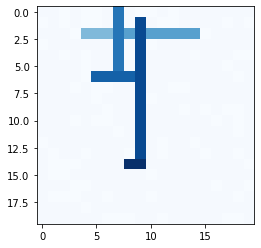

Run: 0
Team: e3228b85-6673-40b0-b149-425003187593
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → ↓ ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ↓ ? ? ↓ ? X ? ? ? X X 

? ? ? ? X ? ? ↓ ? ↓ ? ? ↓ ? ? ? ? X ? ? 

? ? ? ? X → → → → ↓ ← ← ↓ ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ↓ ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ? ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ↑ ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ↑ ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ← ← ← ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X → ↑ X ? ? ? ? ? X X ? 



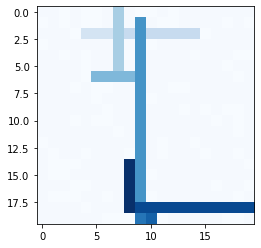

Run: 0
Team: e4aa5a10-2a90-4a5b-992d-be992fcbb716
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ↓ ? ? ↓ ? X ? ? ? X X 

? ? ? ? X ? ? ↓ ? ↓ ? ? ↓ ? ? ? ? X ? ? 

? ? ? ? X → → → → ↓ ← ← ↓ ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ? ↑ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ ? ↑ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ↓ ? ↑ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↑ ? ? ? ? ? ? ? ? X ? 

X ← ← ← ← ← ← ← ← ↑ ← X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↑ → → → → → → ? ? ? X 

? X X ? ? ? ? ? ? ↑ X ? ? ? ? ↑ ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ↑ X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ↑ ? ? X ? 

? ? ? ? X → → → → ↑ → → → → → ↑ ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ↑ ? X X ? 



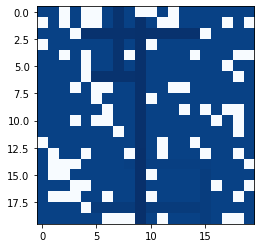

Run: 0
Team: 4d390c91-ee3a-4473-af33-482a0948fcbf
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → ↓ ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ↓ ? ? ↓ ? X ? ? ? X X 

? ? ? ? X ? ? ↓ ? ↓ ? ? ↓ ? ? ? ? X ? ? 

? ? ? ? X → → → → ↓ ← ← ↓ ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ↓ ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ← ← ← ← ← ← ← ← ↓ ← X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ↓ X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ? ? ↑ ↓ ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ↑ ↓ X ? ? X 

? X X X ? ? X ? ? ↓ X ← ← ← ↑ ← ← ← X ? 

? ? ? ? X → → → → → → → → → ↑ ↑ ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ? ? ↑ ↑ ? X X ? 



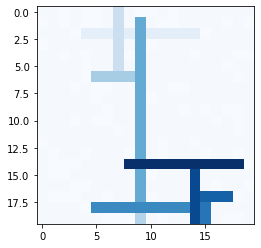

Run: 1
Team: 1a7806b7-3b16-473c-9740-a869f8836496
? ↓ X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ↓ X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ↓ ? X S → → ↓ ← ↓ ← ← ← ← ← X ? ? ? ? 

X → → → → ↑ ← ↓ ← ↓ X ? ↓ ? ? ? ? ? ? ? 

? ↓ X ? X ↑ ? ↓ X ↓ ? ? ↓ ? X ? ? ? X X 

? ↓ ↓ ? X ↑ ? ↓ ? ↓ ? ? ↓ ? ? ? ? X ? ? 

? ↓ ↓ ? X → → → → ↓ ← ← ↓ ← ← ← ← ← X ? 

? ↓ ↓ X ↓ X X ↓ ? ↓ ? ? X X ? ? ? ? ? ? 

? ↓ ↓ ? ↓ X ? ↓ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ↓ ↓ ? ↓ ? X ↓ ? ↓ ? ? ? X ? X ? X X ? 

? ↓ ↓ X ↓ X X ↓ ? ↓ ? ? ? ? ? ? X ? X ? 

→ → → → ↓ ↓ ↓ X ? ↓ ? ? ? ? ? ? ? ? X ? 

X → → → → ↓ ↓ ← ← ↓ ← X ? ? X ? ? ? ? ? 

↓ X ↓ ? X ↓ ↑ ← X ↓ ? X ? ? ? X ? ? X ? 

↓ X X X ? ↓ ↑ ? G ↓ ? ↓ ? ? ? ? ? ? ? X 

↓ X X ← ← ↓ ↑ ← ↑ ↓ X ↓ ? ? ? ? ? ? ? ? 

↓ ? ? X X → ← ← ↑ ↓ ← ← ← ← ← ← X ? ? X 

↓ X X X ← ↑ X ← ↑ ← X ↓ ? ? ? ? ? ? X ? 

→ ↓ ↓ ↓ X ↑ ? ? ↑ ↑ ? ↓ ? ? ? ? ? ? ? ? 

→ → → → → ↑ X X X ↑ ← X ? ? ? ? ? X X ? 



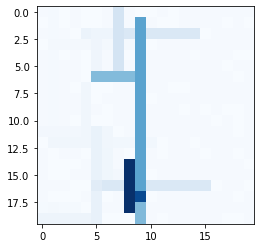

Run: 1
Team: ee7bc1a6-ab71-4012-bee4-6ccee23b93ce
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X → → → ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↑ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ↑ X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ↑ ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ← ← ↑ ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ← ↑ ← ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↑ ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ↑ ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ? ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



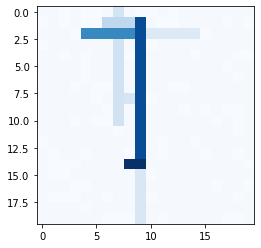

Run: 1
Team: adebc781-b674-4c41-b6ec-92b2949dd353
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↑ ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ↑ X ↓ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ? ? ↑ ? ↓ ? ↓ ? ? ? ? ? X ? ? 

? ? ? ? X ← ← ↑ ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ? ↓ ? ↓ X X ? ? ? ? ? ? 

? ? ? ? ? X ← ↑ ← ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↑ ? ↓ ? ↓ ? X ? X ? X X ? 

? ? ? X ? X X ↑ ? ↓ ? ↓ ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ↓ ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



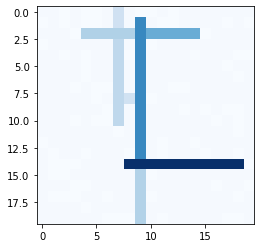

Run: 1
Team: 9ae39522-65ae-48b8-9717-05451eb9f1b9
? ↓ X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ↓ X ? X X ← ↓ ← ↓ ← X X ? ? ? ? X ? X 

? ↓ ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X → → → → → → → → ↓ X ? ? ? ? ? ? ? ? ? 

? ↓ X ↓ X ↓ ? ↑ X ↓ ? ? ? ? X ? ? ? X X 

? ↓ ? ↓ X ↓ ? ↑ ↓ ↓ ? ? ? ? ? ? ? X ? ? 

? ↓ ? ↓ X ↓ ? ↑ ↓ ↓ ? ? ? ? ? ? ? ? X ? 

? ↓ ? X ? X X ↑ ↓ ↓ ? ? X X ? ? ? ? ? ? 

? ↓ ? ? ? X ← ↑ ↓ ↓ X ? ? ? ? ? ? ? ? ? 

? ↓ ? ? ? ? X ↑ ↓ ↓ ← ← ← X ? X ? X X ? 

? ↓ ? X ? X X → → ↓ ← ← ← ← ← ← X ? X ? 

? ↓ ? ? ? ? ? X ← ↓ ← ← ← ← ← ← ← ← X ? 

X → ← ← ← ← ← ← ← ↓ ← X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ? ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ↑ ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ← ↑ ← X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



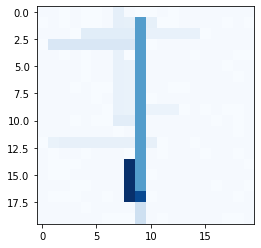

Run: 1
Team: 117c27aa-65b4-43c8-a454-e17651210dcd
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ← ↓ ← ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X → → → → → → → → ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ↓ X ↓ ? ↑ X ↓ ? ? ? ? X ? ? ? X X 

? ? ↓ ↓ X ↓ ? ↑ ↓ ↓ ? ? ? ? ? ? ? X ? ? 

? ? ↓ ↓ X ↓ ? ↑ ↓ ↓ ? ? ? ? ? ? ? ? X ? 

? ? ↓ X ? X X ↑ ↓ ↓ ? ? X X ? ? ? ? ? ? 

? ? ↓ ? ? X ← ↑ ↓ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ↓ ? ? ? X ↑ ↓ ↓ ← ← ← X ? X ? X X ? 

? ? ↓ X ? X X → → ↓ ← ← ← ← ← ← X ? X ? 

? ? ↓ ? ? ↓ ? X ← ↓ ← ← ← ← ← ← ← ← X ? 

X → → → → ↓ ← ← ← ← ← X ? ? X ? ? ? ? ? 

? X ↓ ? X ↓ ? ? X ↑ ? X ? ? ? X ? ? X ? 

? X X X ? ↓ ? ? G ↑ ? ↓ ? ? ? ? ? ? ? X 

? X X ? ? ↓ ? ? ↑ ↑ X ↓ ? ? ? ? ? ? ? ? 

? ? ? X X ↓ ← ← ↑ ← ← ← ← ← ← ← X ? ? X 

? X X X ? ↓ X ? ↑ ↑ X ↑ ? ? ? ? ? ? X ? 

? ? ? ? X → → → ↑ → → ↑ ← ← ← ← ← ← ← ← 

? ? ? ? ? ↓ X X X ↑ ? X ? ? ? ? ? X X ? 



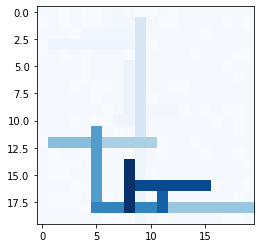

Run: 2
Team: 6e9dc30c-38d5-4487-89e9-457d613b1884
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ← ↓ ← ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X → → → → → → → → ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ↓ X ↓ ? ↑ X ↓ ? ? ? ? X ? ? ? X X 

? ? ↓ ↓ X ↓ ? ↑ ↓ ↓ ? ? ? ? ? ? ? X ? ? 

? ? ↓ ↓ X ↓ ? ↑ ↓ ↓ ? ? ? ? ? ? ? ? X ? 

? ? ↓ X ? X X ↑ ↓ ↓ ? ? X X ? ? ? ? ? ? 

? ? ↓ ? ? X ← ↑ ↓ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ↓ ? ? ? X ↑ ↓ ↓ ← ← ← X ? X ? X X ? 

? ? ↓ X ? X X → → ↓ ← ← ← ← ← ← X ? X ? 

? ? ↓ ? ? ↓ ↓ X ← ↓ ← ← ← ← ← ← ← ← X ? 

X → → → → → → ↓ ← ← ← X ? ? X ? ? ? ? ? 

? X ↓ ? X ↓ ↑ ↓ X ↑ ? X ? ? ? X ? ? X ? 

? X X X → → → → G ↑ ? ↓ ? ? ? ? ? ? ? X 

? X X → → → ↑ ↑ ← ← X ↓ ? ? ? ? ? ? ? ? 

? ? ? X X ↓ ↑ ↑ ← ← ← ← ← ← ← ← X ? ? X 

? X X X ? ↓ X ↑ ? ↑ X ↑ ? ? ? ? ? ? X ? 

? ? ? ? X → ← ↑ ← ← ← ↑ ← ← ← ← ← ← ← ← 

? ? ? ? ? ↓ X X X ↑ ? X ? ? ? ? ? X X ? 



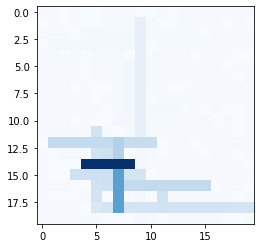

Run: 2
Team: 52690203-5152-4e42-baaf-40a2d4969ac2
? ? X ? X X ← ↓ ← X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → ↓ → ↓ → → ↓ ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ↓ ? ? ↓ ? X ? ? ? X X 

? ? ? ? X → → → → ↓ ← ← ↓ ← ← ← ← X ? ? 

? ? ? ? X ← ← ↑ ↓ ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ↓ ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ← ↑ ← ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↑ ↓ ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ↑ ↓ ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ↓ ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ↓ ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ? ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



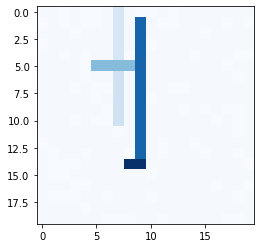

Run: 2
Team: e1037ef2-38f8-43cb-81a2-297fe5aa53f4
? ? X ? X X ← ↓ ← X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↑ ? ? ? X X ? ? ? ? X ? X 

? ? ? X S → → ↑ → → → → ↓ ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↑ ? ? X ? ↓ ? ? ? ? ? ? ? 

? ? X ? X ? ? ↑ X ? ↓ ? ↓ ? X ? ? ? X X 

? ? ? ? X → → → → → → → → → ↓ ← ← X ? ? 

? ? ? ? X ← ← ↑ ↓ ← ← ← ↑ ← ↓ ← ← ← X ? 

? ? ? X ? X X ↑ ↓ ? ↓ ? X X ↓ ? ? ? ? ? 

? ? ? ? ? X ← ↑ ← ← X ← ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X ↑ ↓ ? ? ? ↓ X ↓ X ? X X ? 

? ? ? X ? X X ↑ ↓ ? ? ? ↓ ? ↓ ? X ? X ? 

? ? ? ? ? ? ? X ↓ ? ? ? ↓ ? ↓ ? ? ? X ? 

X ? ? ? ? ? ? ? ↓ ? ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ? ? X ↓ ? ↓ X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ? X → → → ↑ ← ← ← ← ← 

? ? ? X X ? ? ? ? ? ? ? ↓ ? ↑ ? X ? ? X 

? X X X ? ? X ? ? ? X ? ↓ ? ↑ ? ? ? X ? 

? ? ? ? X ? ? ? ? ? ? ? ↓ ? ↑ ? ? ? ? ? 

? ? ? ? ? ? X X X ? ? X ↓ ? ↑ ? ? X X ? 



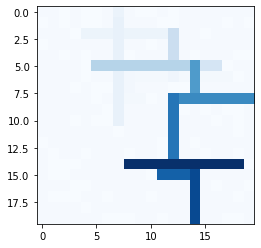

Run: 2
Team: b6d1b9ab-df08-4eb6-b992-09ff05d51183
? ? X ? X X ← ↓ ← X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ? ? X X ? ? ? ? X ? X 

? ? ? X S → → ↓ → → → → ↓ ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ? X ? ↓ ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ? ↓ ? ↓ ? X ? ? ? X X 

? ? ? ? X → → → → → → → → → ↓ ← ← X ? ? 

? ? ? ? X ← ← ↑ ↓ ← ← ← ↑ ← ↓ ← ← ← X ? 

? ? ? X ? X X ↑ ↓ ? ↓ ? X X ↓ ? ? ? ? ? 

? ? ? ? ? X ← ↑ ← ← X ← ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X ↑ ↓ ? ? ? ↓ X ↓ X ? X X ? 

? ? ? X ? X X ↑ ↓ ? ? ? ↓ ? ↓ ? X ? X ? 

? ? ? ? ? ? ? X ↓ ? ? ? ↓ ? ↓ ? ? ? X ? 

X ? ? ? ? ? ? ? ↓ ? ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ? ? X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ? X ↑ ← ← ← ← ← ← ← ← 

? ? ? X X ? ? ? ? ? ? ↑ ↓ ? ? ? X ? ? X 

? X X X ? ? X ? ? ? X ↑ ↓ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ? ? ↑ ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ? ? X ↓ ? ? ? ? X X ? 



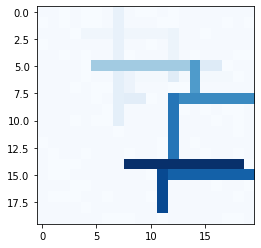

Run: 2
Team: 5082413c-a160-4a03-9286-69d30a165686
? ? X ? X X ← ↓ ← X X ? X ? ↓ ? ↓ ? ↓ ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ↓ ? ↓ X ↓ X 

? ? ? X S → → → → ↓ → → ↓ ← ← X ↓ ? ↓ ? 

X ? ? ? ? ? ? ↑ ? ↓ X ↓ ↓ → ↑ ← ← ← ← ← 

? ? X ? X ? ? ↑ X ↓ ← ← ← ← X ? ↑ ? X X 

? ? ? ? X → → → → ↓ → → ↑ ← ← ← ← X ? ↓ 

? ? ? ? X → → ↑ ↓ ↓ → ↓ ↑ → ↓ → ↑ ↓ X ↓ 

? ? ? X ? X X ↑ ↓ ↓ → ↓ X X ↓ ← ↑ ↓ ← ← 

? ? ? ? ? X ← ↑ ← ↓ X → ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X ↑ ↓ ↓ ? ↓ ↓ X ↓ X ↑ X X ↑ 

? ? ? X ? X X ↑ ↓ ↓ ← ← ← ← ← ← X ? X ↑ 

? ? ? ? ? ? ? X → ↓ → → → → → ↑ ← ← X ↑ 

X ? ? ? ? ? ? ? ↓ ↓ ? X ↑ ? X ↑ ? ? ? ↑ 

? X ? ? X ? ? ? X ↓ ? X ↑ ? ? X ? ? X ↑ 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↑ X ← ↑ ← ← ← ← ← ← ← 

? ? ? X X ? ? ? ? ↑ ? ? ↑ ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ↑ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ↑ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ↑ ← ← ← ← X X ? 



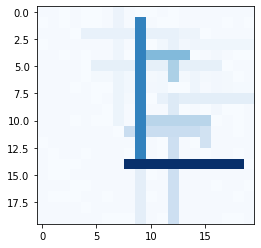

Run: 3
Team: 01a09b4e-747a-43dc-a7c9-901bc7f6abd4
? ? X ? X X ← ↓ ← X X ? X ? ↓ ? ↓ ? ↓ ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ↓ ? ↓ X ↓ X 

? ? ? X S → → ↓ → → → → ← ← ← X ↓ ? ↓ ? 

X ? ? ? ? ? ? ↓ ? ↓ X → ↓ → → → → → ← ← 

? ? X ? X ? ? ↓ X ↓ ← ← ↓ ← X ? ↑ ? X X 

? ? ? ? X → → → → → → → ← ← ← ← ← X ? ↓ 

? ? ? ? X → → ↑ → ← ← ← ↑ ← ← ← ← ← X ↓ 

? ? ? X ? X X ↑ ↓ ↓ → ↓ X X ↓ ← ↑ ↑ ← ← 

? ? ? ? ? X ← ↑ ← ← X → ↓ ← ← ← ↑ ↑ ← ← 

? ? ? ? ? ? X ↑ ↓ ↓ ↓ ↓ ↓ X ↓ X ↑ X X ↑ 

? ? ? X ? X X ↑ ↓ ↓ ← ← ↓ ← ← ← X ? X ↑ 

? ? ? ? ? ? ? X → → → → ↓ → → ↑ ← ← X ↑ 

X ? ? ? ? ? ? ? ↓ ↑ ↓ X ↓ ? X ↑ ? ? ? ↑ 

? X ? ? X ? ? ? X ↑ ↓ X ↓ ? ? X ? ? X ↑ 

? X X X ? ? ? ? G ↑ → ? ↓ ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↑ X ← ↓ ← ← ← ← ← ← ← 

? ? ? X X ? ? ? ? ↑ ? ? ↓ ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ↑ ← ← ← ← X X ? 



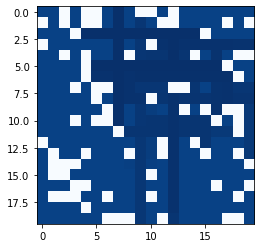

Run: 3
Team: c7a5a6a4-238d-4f29-bbf9-d546185401e6
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



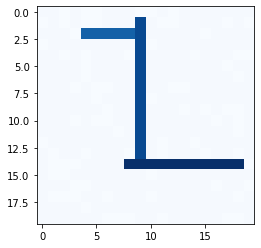

Run: 3
Team: 5843a57c-03df-406a-ab19-b7f1a603e2e5
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X → → ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ↓ ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ↓ ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ? ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



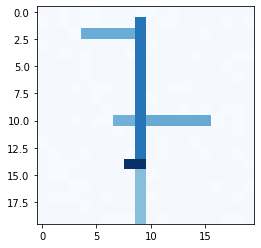

Run: 3
Team: 1284b34d-5696-4117-8ef6-1b537d657f66
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ↓ ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ↓ ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ↓ ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ← ← ↓ ← X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ↓ ↑ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ← ↓ ↑ ← ← ← ↓ ← ← X ? X ? 

? ? ? ? ? ? ↓ X → → → → → ↓ ← ← ← ← X ? 

X → → → → → → ↓ ↑ ↑ ← X ? ↓ X ? ? ? ? ? 

? X ? ? X ? ↓ ↓ X ↑ ? X ? ↓ ? X ? ? X ? 

? X X X → → → → G ↑ ? ? ? ↓ ? ? ? ? ? X 

? X X ? ? ? ↑ ↓ ? ↑ X ? ? ↓ ? ? ? ? ? ? 

? ? ? X X ← ↑ ← ← ← ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ↑ ← ↑ X ? ? ↓ ? ? ? ? X ? 

? ? ? ? X ← ← ↑ ← ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ? ↓ ? ? ? X X ? 



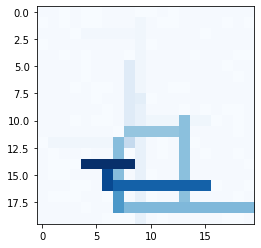

Run: 3
Team: a0833158-7f59-4f7f-b4d6-8cf18eae1f91
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ↓ ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ↓ ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ↓ ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ← ← ↓ ← X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ↓ ↑ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ← ↓ ← ← ← ← ↓ ← ← X ? X ? 

? ? ? ? ? ? ? X → → → → → ↓ ← ← ← ← X ? 

X → → → → → → → ↑ ↑ ← X ? ↓ X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ? X ← ↓ ← X ? ? X ? 

? X X X ? ? ? ? G ↑ ? ↓ ? ↓ ? ↓ ? ? ? X 

? X X ? ? ? ? ? ↑ ↑ X ↓ ? ↓ ? ↓ ? ? ? ? 

? ? ? X X → → → ↑ ← ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ? ? ↑ X → → → → ↑ ← ← X ↓ 

? ? ? ? X → → → → → → → → → → ↑ ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ? ↑ ? ↑ ? X X ↓ 



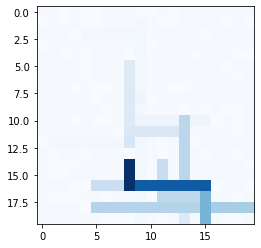

Run: 4
Team: 6f94c88f-714c-4926-995f-62edf54af864
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ↓ ↓ ? ↓ ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ↓ ↓ ? ↓ ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ↓ ↓ ? ↓ X X ? ? ? ? ? ? 

? ? ? ? ? X ← ← ↓ ← X ↓ ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X → ↓ ↑ → → ↓ X ? X ? X X ? 

? ? ? X ? X X → ↓ ↑ ← ← ← ↓ ← ← X ? X ? 

? ? ? ? ? ↓ ? X ↓ ↑ → → → ↓ ← ← ← ← X ? 

X → → → → → → ↓ ← ← ← X → ↓ X ? ? ? ? ? 

? X ? ? X ↓ ? ↓ X ↑ ? X → ↓ ← X ? ? X ? 

? X X X ↓ ↓ ? ↓ G ↑ ? ↓ ↓ ↓ ? ↓ ? ? ? X 

? X X → → → → → ↑ ← X ↓ → ↓ ← ↓ ← ← ← ← 

? ? ? X X → → ↑ ← ← ← ← ← ← ← ← X ? ? X 

? X X X ? ↓ X ↑ ? ↑ X ↓ → → → ↑ ← ← X ↓ 

? ? ? ? X → → ↑ ← ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↓ X X X ↑ ? X ↑ ↑ ? ↑ ? X X ↓ 



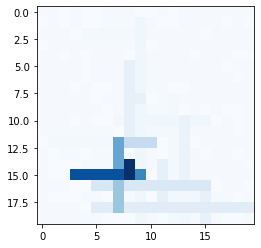

Run: 4
Team: ed78be32-f118-4968-ad12-16f4dfc54d84
? ? X ? X X ↓ ↓ ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ? ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → → ↓ → ↓ → ↓ ← ← ← X ? ? ? ? 

X → → → → → → ↓ ← ↓ X ↓ ? ↓ ? ↓ ? ? ? ? 

? ? X ? X ? ↑ ↓ X ↓ ← ← ← ← X ↓ ? ? X X 

? ? ? ? X → → ↓ ← ← ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → ↑ ↓ → → → → → ↑ ← ← ← ← X ? 

? ? ? X ? X X ↓ ? ↓ ? ↓ X X ? ↑ ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↓ X ↓ ↓ ? ? ↑ ? ? ? ? 

? ? ? ? ? ? X ↓ ? ↓ ? ↓ ↓ X ? X ? X X ? 

? ? ? X ? X X → → → → → ↓ ← ← ← X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ↓ ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ↓ ? ? ? X ? ? X 

? X X X ? ? X ? ? ↓ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↓ ? ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ↓ ? ? ? ? X X ? 



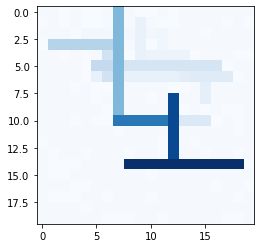

Run: 4
Team: 8b679581-11ca-43ca-989f-68b135b60d4a
? ? X ? X X ↓ ↓ ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ← ↓ ← X X ↓ ? ? ? X ? X 

? ? ? X S → → → → ↓ → ↓ ← ← ← X ? ? ? ? 

X → → → → → → ↓ ← ↓ X ↓ ? ↓ ? ? ? ? ? ? 

? ? X ? X ? ↑ ↓ X ↓ ← ← ← ← X ? ? ? X X 

? ? ? ? X → → → ↓ ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → ↓ ↓ → → → ↑ ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ↓ ? ↓ X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↓ X ↓ ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X → → → → → ↓ X ? X ? X X ? 

? ? ? X ? X X ↑ ↓ ↑ ← ↓ ↓ ← ← ← X ? X ? 

? ? ? ? ? ? ? X → ↑ ← ↓ ↓ ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ↓ ↑ ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ? X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↑ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ↓ ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ↓ ? ? ? ? X X ? 



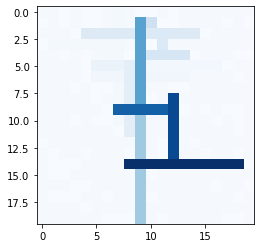

Run: 4
Team: b3cf5276-8e4c-46b6-8c2e-8c324d6cb14a
? ? X ? X X ↓ ↓ ? X X ? X ↓ ← ← ← ← ← ← 

X ? X ? X X ↓ ↓ ← ↓ ← X X ↓ ↑ ? ↓ X ? X 

? ? ? X S → → ↓ → → → ↓ ← ↓ ← X ↓ ? ? ? 

X → → → → → → ↓ ← ↓ X ↓ ? ↓ ↑ ? ↓ ? ? ? 

? ? X ? X ? ↑ ↓ X ↓ ← ↓ ← ↓ X ? ↓ ? X X 

? ? ? ? X → ↑ → → → → ↓ → ← ← ← ← X ? ? 

? ? ? ? X → ↑ ↑ → ↓ → ↓ ← ↑ ← ← ← ← X ? 

? ? ? X ↓ X X ↑ → → → ↓ X X ? ? ↓ ? ? ? 

? ? ? ? ↓ X ? ↑ ↓ ↓ X → ↓ ← ← ← ↓ ← ← ← 

? ? ? ? ↓ ? X ↑ ↓ ↓ ? ↓ ↓ X ? X ↓ X X ? 

? ? ? X ↓ X X ↑ ← ← ← ↓ ↓ ← ← ← X ? X ? 

← ← ← ← ↓ ← ← X → ↑ ← ↑ ↓ ← ← ← ← ← X ? 

X → → → → → → → → ↑ ← X ↓ ? X ? ? ? ? ? 

? X ? ? X ↑ ↓ ? X ↑ ? X ↓ ? ? X ? ? X ? 

? X X X ? ↑ → → G ↑ ? ? ↓ ? ? ? ? ? ? X 

? X X ? ? ↑ ↑ ? ? ↑ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ↑ ↑ ← ← ← ← ← ← ← ← ← X ? ? X 

? X X X ? ↑ X ? ? ↑ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ↑ ← ← ← ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ? X ↓ ? ? ? ? X X ? 



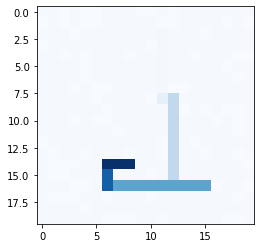

Run: 5
Team: 21ffae67-4e0f-4466-af5a-65b20b0ee373
? ? X ? X X ↓ ↓ ? X X ? X ↓ ← ← ← ← ← ← 

X ? X ? X X ↓ ↓ ← ↓ ← X X ↓ ↑ ? ↓ X ? X 

? ? ? X S → → → → ↓ → ↓ ← ← ← X ↓ ? ? ? 

X → → → → → → ↓ ← ↓ X ↓ ? ↓ ↑ ? ↓ ? ? ? 

? ? X ? X ? ↑ ↓ X → → ↓ ← ← X ? ↓ ? X X 

? ? ? ? X → → → → → → ↓ → ↑ ← ← ← X ? ? 

? ? ? ? X → → → → ↓ → ↓ ← ← ← ← ← ← X ? 

? ? ? X ↓ X X → → → → ↓ X X ? ? ↓ ? ? ? 

? ? ? ? ↓ X ? ↑ ↓ ↑ X → ↓ ← ← ← ↓ ← ← ← 

? ? ? ? ↓ ? X ↑ ↓ ↑ ? ↑ ↓ X ? X ↓ X X ? 

? ? ? X ↓ X X ↑ ← ↑ ← ↑ ↓ ← ← ← X ? X ? 

← ← ← ← ↓ ↓ ← X → ↑ ← ↑ ↓ ← ← ← ← ← X ? 

X → → → → ↓ → → → ↑ ← X ↓ ? X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↑ ? X ↓ ? ? X ? ? X ? 

? X X X ? ↓ ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ↓ ? ? ? ↑ X ? ↑ ? ? ? ? ? ? ? 

? ? ? X X → ← ← ← ← ← ← ↑ ← ← ← X ? ? X 

? X X X ? ↑ X ? ? ↑ X ? ↑ ? ? ? ? ? X ? 

? ? ? ? X ↑ ← ← ← ← ← ← ↑ ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ? X ↑ ? ? ? ? X X ? 



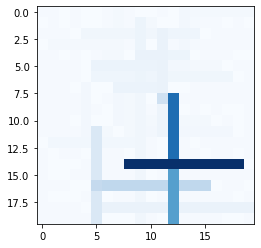

Run: 5
Team: c0f3d3d2-da02-4040-a546-0b0e615bc199
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ? ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ↑ ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ← ↑ ← X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ↑ ↓ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



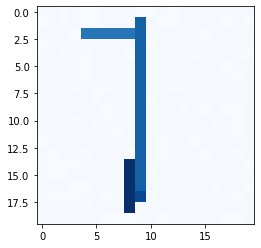

Run: 5
Team: 8315b9a2-451c-42f4-9614-39890e82b487
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X → → → → → ↓ X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ? ↓ ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ? ? ↓ ? ? ? ? ? ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ↑ ↓ ? ? ↓ ? ? ? X ? ? X 

? X X X ? ? X ? ↑ ↓ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X → → → ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↓ ↓ X ↑ ? ? ? ? X X ? 



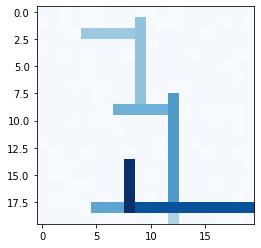

Run: 5
Team: 77edd111-808e-4881-bba4-44516c7386af
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ↓ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ? ? ↓ ? ↓ ? ↓ ? ? ? ? ? X ? ? 

? ? ? ? X ← ← ↓ ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ? ↓ ? ↑ X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↓ X ↑ ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X → → ↓ → ↑ ← X ? X ? X X ? 

? ? ? X ? X X → → ↓ ↑ ↑ ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ? ↓ ↑ ↑ ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ↑ X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ↑ X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↑ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ↓ ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ↓ ? ? ? ? X X ? 



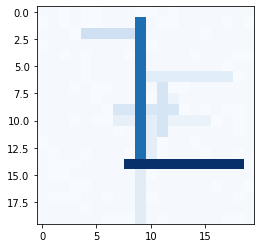

Run: 5
Team: 40949cbe-93ee-41c0-8e1d-3147694e6de0
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ↓ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ? ? ↓ ↓ ↓ ? ↓ ? ? ? ? ? X ? ? 

? ? ? ? X → → → ↓ ← ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ↓ ? ↑ X X ? ? ? ? ? ? 

? ? ? ? ? X ← ↓ ↓ ← X ↑ ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X → ↓ ↑ → → ← X ? X ? X X ? 

? ? ? X ? X X → ← ↑ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X → ↑ ↑ ↑ ↓ ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ↑ ↑ ↑ X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ↑ X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ↑ ↑ ? ↓ ? ? ? ? ? ? X 

? X X ? ? ? ? ? ↓ ↑ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ↓ ↑ ? ? ↓ ? ? ? X ? ? X 

? X X X ? ? X ← ↓ ↑ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ↓ ? ? ? ? X X ? 



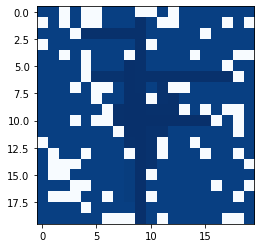

Run: 6
Team: af83aa4a-6662-4d35-9777-5149b1d8e752
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ↓ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ? ? ↓ ↓ ↓ ? ↓ ? ? ? ? ? X ? ? 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ↑ ↓ ? ↑ X X ? ? ? ? ? ? 

? ? ? ? ? X ← ↓ ↑ ↓ X ↑ ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X → ↑ ↓ → ↑ ← X ? X ? X X ? 

? ? ? X ? X X → ↑ ↓ ↑ ↑ ↓ ↓ ← ← X ? X ? 

? ? ? ? ? ? ? X ↑ ↓ ↑ ↑ ↓ ↓ ← ← ← ← X ? 

X ? ? ? ? ? ? ? ↑ ↓ ↑ X → ↓ X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ↑ X ↑ ↓ ? X ? ? X ? 

? X X X → → → → G ↓ ↑ ? ↑ ↓ ? ? ? ? ? X 

? X X ← ↑ ← ← ← ← ← X ? ↑ ↓ ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ↑ ↓ ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ↑ ↓ ? ? ? ? X ? 

? ? ? ? X ← ← ← ← ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ↑ ↓ ? ? ? X X ? 



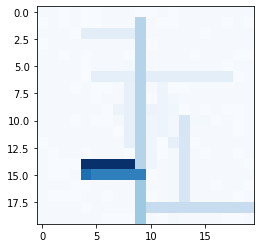

Run: 6
Team: 0fc1879d-8d7b-4c88-94f4-67fc32498296
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ← ← ← ← ↓ ← ↓ ← ↓ X ↓ ↓ ? ? ? ? ? ? ? 

? ? X ? X ↓ ? ↓ X ↓ ↓ ↓ ↓ ? X ? ? ? X X 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → ↓ ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ↓ ↓ ↓ X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↓ X ↓ ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X → → ↓ → → ↓ X ? X ? X X ? 

? ? ? X ? X X ↑ ↓ ↓ ? ↓ ↓ ? ? ? X ↓ X ? 

? ? ? ? ? ? ? X ↓ ↓ ? ↓ ↓ ? ? ? ? ↓ X ? 

X ← ← ← ← ← ← ← ↓ ↓ ← X ↓ ? X ? ? ↓ ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ? ↓ X ? ↓ X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ↓ ? ↓ ? ? ↑ ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ↓ ? ↓ ? X ↑ ← X 

? X X X ? ? X ? ? ↓ X → → → ↓ ← ← ↑ X ? 

? ? ? ? X → → → → → → → → → → → → ↑ ← ← 

? ? ? ? ? ? X X X → ↑ X ↓ ? ↓ ? ? X X ? 



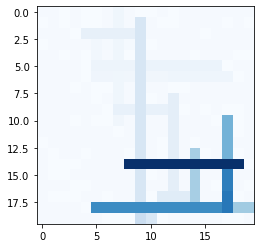

Run: 6
Team: 1296738a-1c0c-4683-a3be-e0c1652fbeba
? ? X ? X X ? ↓ ↓ X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ? ↓ ↓ ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ↓ ? ? ? 

X → → → → → → ↓ ← ↓ X ↓ ↓ ← ← ↓ ← ← ← ← 

? ? X ? X ↓ ? ↓ X ↓ ↓ ↓ ↓ ? X ↓ ↓ ? X X 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ↓ ↓ ← ← X X ↓ ↑ ↓ ? ? ? 

? ? ? ? ? X ← ↑ ↓ ↓ X ↑ ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X ↑ ↓ ↓ ? ↑ ? X ↓ X ↓ X X ? 

? ? ? X ? X X ↑ ↓ ↓ ? ↑ ? ? ↓ ? X ? X ? 

? ? ? ? ? ↓ ? X ↓ ↓ ? ↑ ? ? ↓ ? ? ? X ? 

X → → → → ↓ ← ← ← ← ← X ? ? X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↓ ← X ? ? ? X ? ? X ? 

? X X X ? ↓ ? ? G ↓ ? ? ? ? ? ? ? ? ? X 

? X X → → → → → ↑ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ↓ ? ? ↑ ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ↓ X ← ↑ ← X ? ? ? ? ? ↓ ? X ? 

? ? ? ? X → → → ↑ ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↓ X X X ↑ ↑ X ? ? ? ? ↓ X X ? 



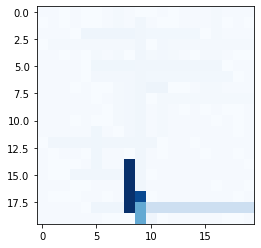

Run: 6
Team: c2654ffd-b412-4dbc-8977-b927caeb4497
? ? X ? X X ? ↓ ↓ X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ? ↓ ↓ ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S ↓ → ↓ → ↓ → ↓ ↓ ← ← X ↓ ? ? ? 

X → → → → → → → ← ↓ X ↓ ↓ ← ← ← ← ← ← ← 

? ? X ? X ↓ ? ↓ X ↓ ↓ ↓ ↓ ? X ↓ ↓ ? X X 

? ? ? ? X ↓ → → → ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → ← ← ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ↑ ↓ ← ← X X ↓ ↑ ↓ ? ? ? 

? ? ? ? ? X ← ↑ ↑ ↑ X ↑ ← ← ← ↑ ← ← ← ← 

? ? ? ? ? ? X ↑ ↑ ↑ ? ↑ ? X ↓ X ↓ X X ? 

? ? ? X ? X X ↑ ↑ ↑ ? ↑ ? ? ↓ ? X ? X ? 

? ? ? ? ? ↓ ? X ↑ ↑ ? ↑ ? ? ↓ ? ? ? X ? 

X → → → → → → → ↑ ↑ ← X ? ? X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↑ ← X ? ? ? X ? ? X ? 

? X X X ? ↓ ? ? G ↑ ? ? ? ? ? ? ? ? ? X 

? X X → → → → → → ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ↓ ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ↓ X ? ? ↑ X ? ? ? ? ? ↓ ? X ? 

? ? ? ? X → → → → ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↓ X X X ↑ ← X ? ? ? ? ↓ X X ? 



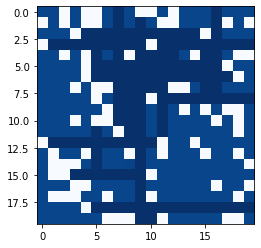

Run: 6
Team: 818bd825-0862-45d6-a29a-200c514fc04f
? ? X ? X X ? ↓ ↓ X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ? ↓ ↓ ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S → → ↓ → ↓ ← ↓ ← ← ← X ↓ ? ? ? 

X → → → → ↓ → ↓ ← ↓ X ↓ ↓ ← ← ↓ ← ← ← ← 

? ? X ? X ↓ ? ↓ X ↓ ↓ ↓ ↓ ? X ↓ ↓ ? X X 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → ↓ ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X → → ↓ ← ← X X ↓ ↑ ↓ ? ? ? 

? ? ? ? ? X ← ↑ ↓ ↓ X ↑ ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X ↑ ↓ ↓ ? ↑ ? X ↓ X ↓ X X ? 

? ? ? X ? X X ↑ ↓ ↓ ? ↑ ? ? ↓ ? X ? X ? 

? ? ? ? ? ↓ ? X ↓ ↓ ? ↑ ? ? ↓ ? ? ? X ? 

X → → → → → → → → ↓ ← X ? ? X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↓ ← X ? ? ? X ? ? X ? 

? X X X ? ↓ ? ? G ↓ ? ? ? ? ? ? ? ? ? X 

? X X → → → → → ↑ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ↓ ? ? ↑ ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ↓ X ← ↑ ← X ? ? ? ? ? ↓ ? X ? 

? ? ? ? X → → → ↑ ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↓ X X X ↑ ← X ? ? ? ? ↓ X X ? 



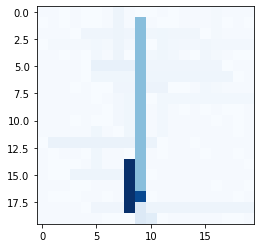

Run: 7
Team: 1348507c-56d2-4e49-b613-a90011799b2e
? ? X ? X X ? ↓ ↓ X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ? ↓ ↓ ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S ↓ → ↓ → ↓ → ↓ ↓ ← ← X ↓ ? ? ? 

X → → → → ↓ ← ← ← ← X ↓ ↓ ← ← ← ← ← ← ← 

? ? X ? X ↓ ? ↓ X ↓ ↓ ↓ ↓ ? X ↓ ↓ ? X X 

? ? ? ? X ↓ → ↓ ↓ ↓ ↓ ↓ ↓ → ↓ ↓ ← X ? ↓ 

? ? ? ? X → → → → → → ← ← ← ← ← ← ↓ X ↓ 

? ? ? X ↓ X X → ↑ ↑ ↑ ↑ X X → → → → → ↓ 

? ? ? ? ↓ X ← ↑ ↑ ↑ X ↑ ← ← ↑ ↑ ← ↑ ← ↓ 

? ? ? ? ↓ ? X ↑ ↑ ↑ ? ↑ ↓ X ↑ X ↓ X X ↓ 

? ? ? X ↓ X X ↑ ↑ ↑ ? ↑ ↓ ? ↑ ? X ↓ X ↓ 

→ → → → → → ↓ X ↑ → → → → → ↑ ← ← ↓ X ↓ 

X → → → → → → → ↑ ↑ ← X ↑ ? X ← ← ↓ ← ← 

? X ? ? X ↑ ↓ ? X ↑ ← X ↑ ? ? X ? ↓ X ↓ 

? X X X ? ↑ ↓ ? G ← ← ← ← ← ← ← ← ← ← X 

? X X → → → ↓ → → ↑ X ? ↑ ? ? ? ? ↓ ? ? 

? ? ? X X → → → → ↑ → → ↑ ← ← ← X ↓ ? X 

? X X X ? ↑ X ? ? ↑ X ? ↑ ? ? ? ↓ ↓ X ? 

? ? ? ? X → → → → ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ← X ↑ ? ? ? ↓ X X ? 



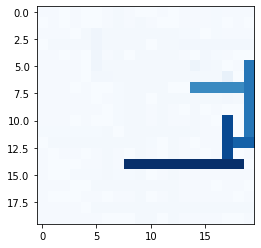

Run: 7
Team: 063c9ca7-556e-447e-9c69-006f454b204b
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S ↓ ← ← ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ↓ ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X → → → → → → → ↑ ← 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ? ↑ X ? ↑ X 

? X X X ? ? X ? ? ↓ X ? ? ? ? ↑ ? ? X ? 

? ? ? ? X → → → → → → → → → → ↑ ← ← ← ← 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ↑ ? X X ? 



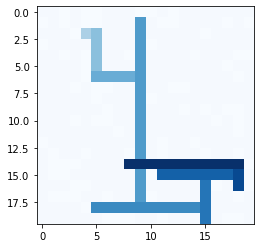

Run: 7
Team: abe33436-7d43-4d8b-94bf-05c250c546b8
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S ↓ ← ← ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ↓ ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ? ↓ X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ? ↓ ? ? ? X ↓ X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ↓ ? ? ? ? ↓ X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ↓ ? X ? ? ↓ ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ? ? X ? ↓ X ? 

? X X X ? ? ? ? G ↓ ? ? ↓ ? ? ↓ ? ↓ ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ↓ ? ? ↓ ? ↓ ? ? 

? ? ? X X ← ← ← ↑ ← ← ← ← ← ← ← X ↓ ? X 

? X X X ? ? X ? ↑ ↓ X → → → → ↑ ← ← X ? 

? ? ? ? X → → → ↑ → → → → → → ↑ → ↑ ← ← 

? ? ? ? ? ? X X X ↓ ? X ↓ ? ? ↑ ? X X ? 



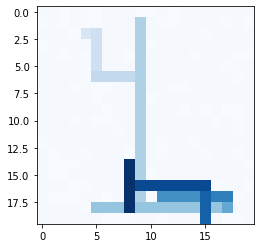

Run: 7
Team: 727ba6fb-4740-407a-8159-9419eb65c6be
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S ↓ ← ← ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ↓ ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X ← ← ↓ ← ← ↓ X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ? ↑ ? ? ? X ? X ? 

? ? ? ? ? ↓ ? X ? ↓ ? ? ↑ ? ? ? ? ? X ? 

X ? ? ? ? ↓ ? ? ? ↓ ? X ↑ ? X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↓ ? X ↑ ? ? X ? ? X ? 

? X X X ? ← ← ← G ↓ ? ? ↑ ? ? ↓ ? ? ? X 

? X X ? ? ↑ ? ? ? ↓ X ? ↑ ? ? ↓ ? ? ? ? 

? ? ? X X ↑ ← ← ← ↓ ← ← ↑ ← ← ← X ? ? X 

? X X X ? ↑ X ? ? ↓ X → ↑ → → ↑ ↓ ← X ? 

? ? ? ? X → → → → → → → ↑ → → ↑ ← ← ← ← 

? ? ? ? ? ↑ X X X ↓ ? X ↑ ? ? ↑ ↓ X X ? 



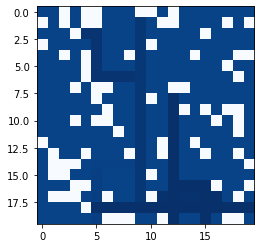

Run: 7
Team: fb53c47e-e45d-47c5-8785-1c72c4537241
? ? X ? X X ← ↓ ← X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X → → → ↓ ← X X ? ? ? ↓ X ? X 

? ? ? X S ↓ ← ↑ ← ↓ ← ← ← ← ← X ↓ ? ? ? 

X ? ? ? ? ↓ ? ↑ ↑ ↓ X ? ↓ ? ? ↓ ↓ ? ? ? 

? ? X ? X ↓ ? ↑ X ↓ ? ? ↓ ? X ↓ ↓ ? X X 

? ? ? ? X ↓ → ↑ ← ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ↑ ↓ ? ? X X ? ↓ ↓ ? ? ? 

? ? ? ? ? X ? ↑ ↑ ↓ X ? ↓ ? ? ↓ ↓ ? ? ? 

? ? ? ? ? ? X ↑ ↑ ↓ ← ← ↓ X ? X ↓ X X ? 

? ? ? X ? X X ↑ ↑ ↓ ← ← ↓ ← ← ← X ? X ? 

? ? ? ? ? ? ? X ↑ ↓ ? ? ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ↑ ↓ ? X ↓ ← X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ← ← X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ↑ ? ↑ ↓ ? ? ? ? 

? ? ? X X ← ← ← ← ↓ ← ← ↑ ← ← ← X ? ? X 

? X X X ? ? X ? ? ↓ X ? ↑ ? ↑ ↑ ? ? X ? 

? ? ? ? X → → → → → → → ↑ → ↑ ↑ ← ← ← ← 

? ? ? ? ? ? X X X ↑ ← X ↑ ? ↑ ↑ ? X X ? 



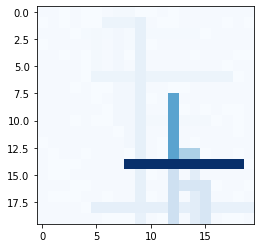

Run: 8
Team: 286d5c02-2a67-4373-b706-02abfabb33c7
? ? X ? X X ← ↓ ↓ X X ? X ↓ ? ? ↓ ? ? ? 

X ? X ? X X → → → ↓ ← X X ↓ ? ? ↓ X ? X 

? ? ? X S ↓ → ↑ → ↓ → → ↓ ↓ ← X ↓ ? ? ? 

X ? ? ? ? ↓ ? ↑ ↑ ↓ X ↓ ↓ ↓ ? ↓ ↓ ? ? ? 

? ? X ? X ↓ ? ↑ X ↓ → → ↓ ↓ X ↓ ↓ ? X X 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → ↑ → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ↑ ↓ ↓ ↓ X X ↑ ↑ ↓ ↓ ? ? 

? ? ? ? ? X ? ↑ ↑ ↓ X ↓ ↓ ? ↑ ↑ ↓ ↓ ? ? 

? ? ? ? ? ? X ↑ ↑ ↓ → → ↓ X ↑ X ↓ X X ? 

? ? ? X ? X X ↑ ↑ ↓ ← ← ← ← ↑ ← X ↓ X ? 

? ? ? ? ? ↓ ? X ↑ ↓ → → ↑ ↑ ↑ ← ← ← X ? 

X ? ? ? ? ↓ ? ↓ ↑ ↓ ? X ↑ ↑ X ? ? ↓ ? ? 

? X ? ? X ↓ ? ↓ X ↓ ? X ↑ ← ← X ? ↓ X ? 

? X X X → → → → G ↓ ? ? ↑ ↑ ↑ ↓ ? ↓ ? X 

? X X ← ← ↑ ← ← ← ← X ? ↑ ↑ ↑ ↓ ? ↓ ? ? 

? ? ? X X ↑ → ↑ ← ← ← ← ← ← ← ← X ↓ ? X 

? X X X ? ↑ X ↑ ? ↓ X → → → → ↑ ← ← X ? 

? ? ? ? X ↑ → ↑ ← ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ← X ↑ ↑ ↑ ↑ ? X X ? 



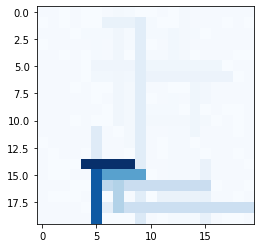

Run: 8
Team: 4f540ca6-ea1c-4042-8e72-07dd86d6b04e
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S → ↓ ↓ ↓ ↓ ← ← ← ← ← X ↓ ? ? ? 

X ← ← ← ← ← ↓ ← ← ↓ X ← ↑ ← ← ← ↓ ← ← ← 

? ? X ? X ? ↓ ↓ X ↓ ? ? ↑ ? X ? ↓ ? X X 

? ? ? ? X → → → → ↓ → → → → → → ↓ X ? ? 

? ? ? ? X → ↑ ↓ → ↓ → → ↑ → ↑ ← ↓ ← X ? 

? ? ? X ? X X ↓ ? ↓ ? ? X X ↑ ? ↓ ? ? ? 

? ? ? ? ? X ? ↓ ? ↓ X ← ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X → → ↓ ← ← ↓ X ↑ X ↓ X X ? 

? ? ? X ? X X ↓ ? ↓ ? ? ↓ ↓ ↑ ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ↓ ↓ ↑ ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ↓ ↓ X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ↓ ↓ X ? ? X ? 

? X X X ? ? ? ? G ↓ → → ↓ → ↓ ? ? ? ? X 

? X X ? ? ? ? ? ? ↓ X ? ↓ ↑ ↓ ? ? ? ? ? 

? ? ? X X ← ← ← ← ↓ ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ? ? ↓ X ? ↓ ↑ ↑ ? ? ? X ? 

? ? ? ? X → → → → ↑ → → ↓ ↑ ↑ ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X → → ↑ ← ← X X ? 



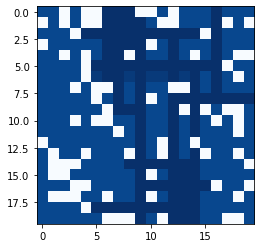

Run: 8
Team: 8d9537b1-cf28-493a-b1e5-1515d7f7c696
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S → → → → → → → ← ← ← X ↓ ? ? ? 

X ← ← ← ← ← ↓ ← ← ← X ← ↑ ← ← ← ↓ ← ← ← 

? ? X ? X ? ↓ ↓ X ↑ ? ? ↑ ? X ? ↓ ? X X 

? ? ? ? X → ↓ → ← ← ← ← ↑ ← ← ← ← X ? ? 

? ? ? ? X → → → → → → → → → ↑ ← ↓ ← X ? 

? ? ? X ? X X ↓ ? ↑ ? ? X X ↑ ? ↓ ? ? ? 

? ? ? ? ? X ? ↓ ? ↑ X ← ↓ ← ↑ ← ← ← ← ← 

? ? ? ? ? ? X → → ↑ ← ← ↓ X ↑ X ↓ X X ? 

? ? ? X ? X X ↓ ? ↑ ? ? ↓ ↓ ↑ ? X ? X ? 

? ? ? ? ? ? ? X ? ↑ ? ? ↓ ↓ ↑ ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↑ ? X ↓ ↓ X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ? X ↓ ↓ ↓ X ? ? X ? 

? X X X ? ? ? ? G ↑ ? ? ↓ ↓ ↓ ↓ ? ? ? X 

? X X ? ? ? ? ? ↓ ↑ X → ↓ → → ↓ ← ← ← ← 

? ? ? X X → → → → ↑ ← ← ↓ ↑ ← ← X ? ? X 

? X X X ? ? X ? ? ↑ X ? ↓ ↑ ↑ ↓ ? ? X ? 

? ? ? ? X → → → → ↑ → → → ↑ ↑ ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X → ↑ ↑ ← ← X X ? 



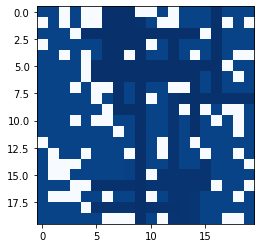

Run: 8
Team: d6c18b73-7cb0-47d9-b28f-e5bb9026a7bb
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S → ↓ ↓ ↓ ↓ ← ← ← ← ← X ↓ ? ? ? 

X ← ← ← ← ← ↓ ↓ ← ↓ X ← ↑ ← ← ← ↓ ← ← ← 

? ? X ? X ? ↓ ↓ X ↓ ? ? ↑ ? X ? ↓ ? X X 

? ? ? ? X → → → → → → → → → → → ↓ X ? ? 

? ? ? ? X → → ↓ → ↓ → → → → ↑ ← ↓ ← X ? 

? ? ? X ? X X ↓ ? ↓ ? ? X X ↑ ? ↓ ? ? ? 

? ? ? ? ? X ? ↓ ? ↓ X ← ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X → → ↓ ← ← ↓ X ↑ X ↓ X X ? 

? ? ? X ? X X ↓ ? ↓ ? ? ↓ ↓ ↑ ? X ? X ? 

? ? ? ? ? ↓ ? X ? ↓ ? ? ↓ ↓ ↑ ? ? ? X ? 

X ? ? ? ? ↓ ? ? ? ↓ ? X ↓ ↓ X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↓ ? X ↓ ↓ ↓ X ? ? X ? 

? X X X ? ↓ ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ↓ ? ? ? ↓ X ↑ ↓ → → ↓ ← ← ← ← 

? ? ? X X → → → → → → ↑ ← ← ← ← X ? ? X 

? X X X ? ↓ X ? ? ↑ X ↑ ↓ ↑ ↑ ↓ ? ? X ? 

? ? ? ? X → → → → ↑ → ↑ ↓ ↑ ↑ ← ← ← ← ← 

? ? ? ? ? ↓ X X X ↑ ? X → → ↑ ← ← X X ? 



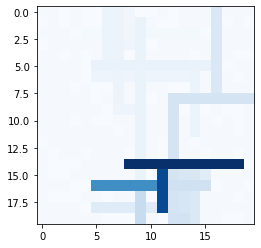

Run: 8
Team: 9b02a172-a75b-45bc-bbc6-31c0db7881e1
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S → ↓ ↓ ↓ ↓ ← ← ← ← ← X ↓ ? ? ? 

X ← ← ← ← ← ↓ ↓ ← ↓ X ← ↑ ← ← ← ↓ ← ← ← 

? ? X ? X ? ↓ ↓ X ↓ ? ? ↑ ? X ? ↓ ? X X 

? ? ? ? X → → ↓ ← ↓ ← ← ← ← ← ← ↓ X ? ? 

? ? ? ? X → ↑ ↓ → ↓ → → → → ↑ ← ↓ ← X ? 

? ? ? X ? X X ↓ ? ↓ ? ? X X ↑ ? ↓ ? ? ? 

? ? ? ? ? X ? ↓ ? ↓ X ← ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X → → ↓ ← ← ↓ X ↑ X ↓ X X ? 

? ? ? X ? X X ↓ ? ↓ ? ? ↓ ↓ ↑ ? X ? X ? 

? ? ? ? ? ↓ ? X ? ↓ ? ? ↓ ↓ ↑ ? ? ? X ? 

X ? ? ? ? ↓ ? ? ? ↓ ? X ↓ ↓ X ? ? ? ? ? 

↓ X ? ? X ↓ ? ? X ↓ ? X ↓ ↓ ↓ X ? ? X ? 

↓ X X X ? ↓ ? ? G ↓ ? ? ↓ ↓ ↓ ↓ ? ? ? X 

↓ X X ? ? ↓ ? ? ↑ ↓ X → ↓ → → ↓ ← ← ← ← 

↓ ? ? X X → → → ↑ ← ← ← ← ← ← ← X ? ? X 

↓ X X X ? ↑ X ? ↑ ↑ X ? ↓ ↑ ↑ ↓ ? ? X ? 

↓ → ↓ ← X ↑ → → ↑ ↑ → → ↓ ↑ ↑ ← ← ← ← ← 

→ → → → → ↑ X X X ↑ ? X → → ↑ ← ← X X ? 



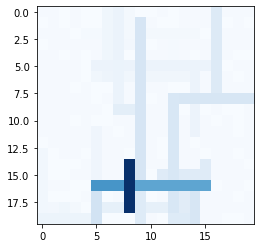

Run: 9
Team: f9b6dbbf-0c47-4c20-8e5e-b00614d9ee21
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ← X X ? ? ? ↓ X ? X 

? ? ? X S → ↓ ↓ ↓ ↑ ← ← ← ← ← X ↓ ? ? ? 

X → → → → → ↓ ↓ ← ↑ X ← ↑ ← ← ← ↓ ← ← ← 

? ? X ? X ? ↓ ↓ X ↑ ? ? ↑ ? X ? ↓ ? X X 

? ? ? ? X → → → → ↑ → → → → → → ↓ X ? ? 

? ? ? ? X → ↑ ↓ → ↑ → → → → ↑ ← ↓ ← X ? 

? ? ? X ? X X ↓ ? ↑ ? ? X X ↑ ? ↓ ? ? ? 

? ? ? ? ? X ? ↓ ? ↑ X ← ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X → → ↑ ← ← ↓ X ↑ X ↓ X X ? 

? ? ? X ? X X ↓ ? ↑ ? ? ↓ ↓ ↑ ? X ? X ? 

? ? ? ? ? ↓ ↓ X ? ↑ ? ? ↓ ↓ ↑ ? ? ? X ? 

X ? ? ? ? ↓ ↓ ? ? ↑ ? X ↓ ↓ X ? ? ? ? ? 

↓ X ? ? X ↓ ↓ ← X ↑ ? X ↓ ↓ ↓ X ? ? X ? 

↓ X X X ? ↓ ↓ ? G ↑ ? ? ↓ ↓ ↓ ↓ ? ? ? X 

↓ X X → → ↓ → → ↑ ↑ X → ↓ → → ↓ ← ← ← ← 

↓ ? ? X X → → → ↑ ← ← ← ← ← ← ← X ? ? X 

↓ X X X ? ↑ X ? ↑ ↑ X ? ↓ ↑ ↑ ↓ ? ? X ? 

↓ → ↓ ← X ↑ → → ↑ ↑ → → ↓ ↑ ↑ ← ← ← ← ← 

→ → → → → ↑ X X X ↑ ? X → → ↑ ← ← X X ? 



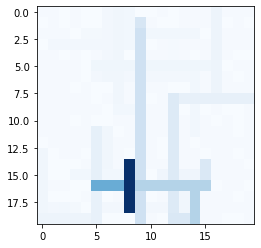

Run: 9
Team: 25ed03cd-b6dd-4fe4-a9c4-a34d3fd5f179
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



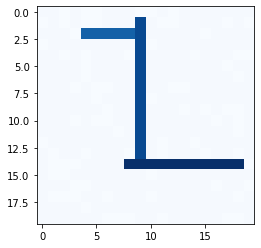

Run: 9
Team: f625c7dd-5544-4851-a2bb-4b00e27839b0
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X → → → → → → ↓ ← ← X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ↓ ? ↓ ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ↓ X ↓ ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ↓ ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ? ↓ ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ↓ ? ? X ? ? X 

? X X X ? ? X ? ? ↓ X ? ? ↓ ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ↓ ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ↓ ? ? ? X X ? 



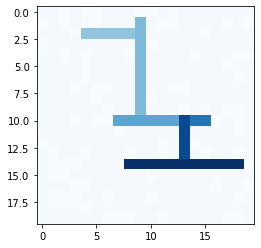

Run: 9
Team: 93312ca9-648e-4daa-9809-761dbd72889e
? ? X ? X X ↓ ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X → → → ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ↓ ← ← ← X ? ? ? ? 

X ? ? ? ? ? ↑ ↓ ? ↓ X ↓ ← ← ← ← ← ← ← ← 

? ? X ? X ← ↑ ← X ↓ ← ↓ ← ← X ↑ ? ? X X 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → ↑ ↑ ↑ ↓ ← ↑ ← ← ↑ ← ← ← X ? 

? ? ? X ? X X ↑ ↑ ↓ ? ↑ X X ↑ ↑ ? ? ? ? 

? ? ? ? ? X ? ↑ ↑ ↓ X ↑ ? ? ↑ ↑ ? ? ? ? 

? ? ? ? ? ? X ↑ ↑ ↓ ? ↑ ? X ↑ X ? X X ? 

? ? ? X ? X X ↑ ↑ ↓ → ↑ → → ↑ ← X ? X ? 

? ? ? ? ? ? ? X ↑ ↓ ← ↑ ← ← ↑ ← ← ← X ? 

X ? ? ? ? ? ? ? ↑ ↓ ? X ? ↓ X ↓ ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ↓ ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ? ? ? ↓ ? ? ? ? ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ? ↓ ? ? ? ? ? ? 

? ? ? X X ? ? ? ↑ ↓ ? ? ? ↓ ? ? X ? ? X 

? X X X ? ? X ? ↑ ↓ X ? ? ↓ ? ? ? ? X ? 

? ? ? ? X ← ← ← ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ? ↓ ? ? ? X X ? 



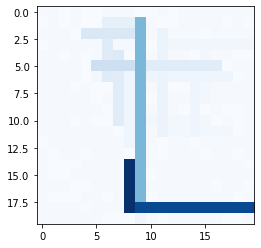

Run: 9
Team: abc504d8-145c-48a5-a8ba-6beeda02e0fa
? ? X ? X X ↓ ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X → → → ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → ↑ → → ↓ ← ↓ ← ← ← X ? ? ? ? 

X ? ? ? ? ? ↑ ↓ ? ↓ X ↓ ← ← ← ← ← ← ← ← 

? ? X ? X ← ↑ ← X ↓ ← ↓ ← ← X ↑ ? ? X X 

? ? ? ? X → → → → → → → ← ← ← ← ← X ? ? 

? ? ? ? X → → → ↑ → → ↑ → → → ↑ ← ← X ? 

? ? ? X ? X X ↑ ↑ ↑ ? ↑ X X ↑ ↑ ? ? ? ? 

? ? ? ? ? X ? ↑ ↑ ↑ X ↑ ↓ ? ↑ ↑ ? ? ? ? 

? ? ? ? ? ? X ↑ ↑ ↑ ? ↑ ↓ X ↑ X ? X X ? 

? ? ? X ? X X → ↑ ← ← ↑ ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ↑ ↑ ← ↑ ← ↑ ↑ ← ← ← X ? 

X ? ? ? ? ? ? ? ↑ ↑ ? X ↓ ↑ X ↓ ? ? ? ? 

? X ? ? X ? ? ? X ↑ ? X ↓ ↑ ? X ? ? X ? 

? X X X ? ? ? ? G ↑ ? ? ↓ ↑ ? ? ? ? ? X 

? X X ? ? ? ? ? ↓ ↑ X ? ↓ ↑ ? ? ? ? ? ? 

? ? ? X X ← ← ← ↓ ↑ ← ← ← ↑ ← ← X ? ? X 

? X X X ? ? X ? ? ↑ X ? ↑ ↑ ? ? ? ? X ? 

? ? ? ? X → → → → ↑ ↓ ← ← ↑ ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ← X ↑ ↑ ? ? ? X X ? 



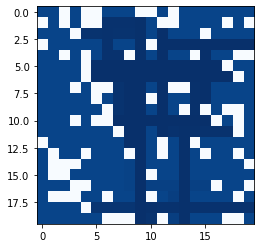

Run: 10
Team: 84a54e8f-4301-467e-ae3a-1fbc340f4045
? ? X ? X X ↓ ↓ ? X X ? X → → → ↓ ← ↓ ← 

X ? X ? X X → → → ↓ ← X X → → ↑ ↓ X ↓ X 

? ? ? X S → → → → ↓ ← ↓ ↓ ↑ ← X ↓ ↓ ← ← 

X ? ? ? ? ? ↑ ↓ ? ↓ X ↓ ↓ ← ← ← ← ← ← ← 

? ? X ? X ← ↑ ← X ↓ ← ↓ ↓ ↑ X ↑ ↑ ↑ X X 

? ? ? ? X → ↑ ↑ ← ↓ ← ← ← ← ↓ ← ← X ? ? 

? ? ? ? X → ↑ ↑ ↑ ↓ ← ↑ ← ← ↓ ← ← ← X ? 

? ? ? X ? X X ↑ ↑ ↓ ? ↑ X X ↓ ↑ ↑ ← ← ← 

? ? ? ? ? X ? ↑ ↑ ↓ X ↑ ↓ ? ↓ ↑ ↑ ? ? ? 

? ? ? ? ? ? X ↑ ↑ ↓ ↓ ↑ ↓ X ↓ X ↑ X X ? 

? ? ? X ? X X ↑ ↑ ↓ ↓ ← ↓ ← ↓ ← X ↓ X ? 

? ? ? ? ? ? ? X → ↓ → → → → → → → ↓ X ? 

X ← ← ← ← ← ← ← ↑ ↓ ← X ↑ ↓ X ↓ ? ↓ ? ? 

? X ? ? X ? ? ? X ↓ ↑ X ↑ ↓ ? X ? ↓ X ? 

? X X X ? ? ? ? G ↓ ↑ ? ↑ ↓ ? ↓ ? ↓ ? X 

? X X ? ? ? ? ? ↑ ↓ X ← ↑ ↓ ← ↓ ← ← ← ← 

? ? ? X X → → → ↑ ← ← ← ← ← ← ← X ↓ ? X 

? X X X ? ? X ? ? ↑ X ? ↑ ↓ ? ↓ ↓ ↓ X ? 

? ? ? ? X → → → → → ↓ ← ↑ ↓ ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ← X ↑ ← ← ← ← X X ? 



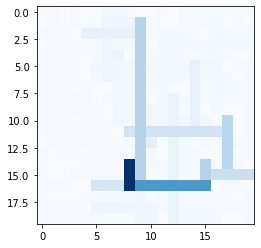

Run: 10
Team: 3cae5788-2827-471c-ac51-2189948e5ab6
? ? X ? X X ↓ ↓ ↓ X X ? X ? ↓ ? ? ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ? X X ? ↓ ? ? X ? X 

? ? ? X S → → → ↓ ↓ ← ← ← ← ← X ? ? ? ? 

X → → → → → → → → ↓ X ↓ ← ← ← ← ← ← ← ← 

? ? X ? X ? ↑ ↑ X ↓ ↓ ↓ ? ? X ? ? ? X X 

? ? ? ? X → ↑ ← ← ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → ↑ ← ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ↑ ↓ ↑ ↑ X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↑ ↑ ↓ X ↑ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↑ ↑ ↓ ? ↑ ? X ? X ? X X ? 

? ? ? X ? X X → ↑ ↓ ← ↑ ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ↑ ↓ ? ↑ ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ↑ ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ? ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ↑ ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ← ↑ ← X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ↑ ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



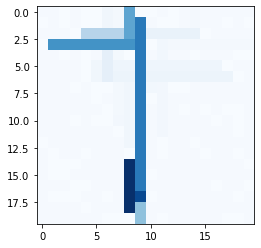

Run: 10
Team: f97a8099-7539-4de1-a65a-5eba72baba25
? ↓ X ? X X ↓ ↓ ↓ X X ? X ↓ ↓ ? ? ? ? ? 

X ↓ X ? X X ↓ ↓ ↓ ↓ ? X X ↓ ↓ ? ? X ? X 

? ↓ ? X S → → ↓ ← ↓ ← ↓ ← ← ← X ? ? ? ? 

X → → → → → → ↓ → ↓ X ↓ ← ← ← ← ← ← ← ← 

? ↓ X ? X ? ↑ ↓ X ↓ ↓ ↓ ? ↑ X ? ? ? X X 

? ↓ ? ? X → → ↓ ↓ ↓ ← ↓ ← ← ← ← ← X ? ? 

? ↓ ? ? X → ↑ ↓ ↓ ↓ → ↓ → ↑ ← ← ← ← X ? 

? ↓ ? X ? X X → → ↓ → ↓ X X ? ? ? ? ? ? 

? ↓ ? ? ? X → → → ↓ X ↓ ↓ ? ? ? ? ? ? ? 

← ↓ ← ← ← ← X ↑ ↓ ↓ ? ↓ ↓ X ? X ? X X ? 

? ↓ ? X ? X X ↑ → ↓ ← ↓ ← ↓ ← ← X ? X ? 

← ↑ ← ← ← ← ← X → ↓ → → → ↓ ← ← ← ← X ? 

X → → → → → → → ↑ ↓ ← X ↑ ↓ X ? ? ? ? ? 

? X ? ? X ? ↑ ↓ X ↓ ? X ↑ ↓ ? X ? ? X ? 

? X X X ? ? ↑ ↓ G ↓ ? ? ↑ ↓ ? ? ? ? ? X 

? X X ? ? ? ↑ ↓ ↑ ↓ X ? ↑ ↓ ? ? ? ? ? ? 

? ? ? X X ← ↑ ← ↑ ↓ ← ← ↑ ↓ ← ← X ? ? X 

? X X X ? ? X ↓ ↑ ↓ X ? ↑ ↓ ? ? ? ? X ? 

? ? ? ? X → → → ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ← X ↑ ↓ ? ? ? X X ? 



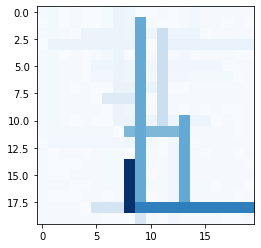

Run: 11
Team: 17957392-81db-46c6-bc2b-228bc92062cc
? ↓ X ? X X ↓ ↓ ↓ X X ? X ↓ ↓ ? ? ? ? ? 

X ↓ X ? X X ↓ ↓ ↓ ↓ ? X X ↓ ↓ ? ? X ? X 

? ↓ ? X S → → → → → → → → → ← X ? ? ? ? 

X → → → → → ↑ ↑ ← ← X ↓ ← ← ← ← ← ← ← ← 

? ↑ X ? X ? ↑ ↑ X ↓ ↓ ↓ ? ↑ X ? ? ? X X 

? ↑ ? ? X → ↑ ↑ ← ← ← ↓ ← ← ← ← ← X ? ? 

? ↑ ? ? X → → → → → → → → ← ← ← ← ← X ? 

? ↑ ? X ? X X ↑ ↑ ↑ ↑ ↑ X X ? ? ? ? ? ? 

? ↑ ? ? ? X → ↑ ↑ ↑ X ↑ ↓ ? ? ? ? ? ? ? 

← ↑ ← ← ← ← X ↑ ↑ ↑ ? ↑ ↓ X ? X ? X X ? 

? ↑ ? X ? X X ↑ ↑ ↑ ← ↑ ← ← ← ← X ? X ? 

← ↑ ← ← ← ← ← X ↑ ↑ → ↑ ↑ ↓ ← ← ← ← X ? 

X → → → → → → → ↑ ↑ ← X ↑ ↓ X ? ? ? ? ? 

? X ? ? X ↓ ↑ ↓ X ↑ ? X ↑ ↓ ? X ? ? X ? 

? X X X ? ← ↑ ↓ G ↑ ? ? ↑ ↓ ? ? ? ? ? X 

? X X ? ? ↑ ↑ ↓ ? ↑ X ? ↑ ↓ ? ? ? ? ? ? 

? ? ? X X ↑ ↑ ← ← ↑ ← ← ↑ ↓ ← ← X ? ? X 

? X X X ? ↑ X ↓ ? ↑ X ? ↑ ↓ ? ? ? ? X ? 

? ? ? ? X → → → → ↑ → → ↑ ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ← X ↑ ↓ ? ? ? X X ? 



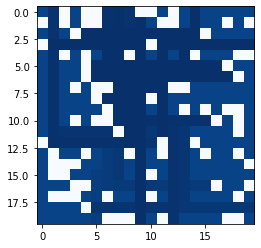

Run: 11
Team: 38e5ee8a-a234-4335-bfb9-37edd7efb47f
? ? X ? X X ? ↓ ? X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S ↓ ← ← ← ↓ ← ↓ ← ← ← X ↓ ? ? ? 

X → → → → ↓ ← ↓ ← ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? X ? X ↓ ← ↓ X ↓ ? ↓ ? ? X ? ↓ ? X X 

? ? ? ? X ↓ → → ← ← ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↑ → ↓ ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ← ↑ ← ↓ X X ? ? ↓ ? ? ? 

? ? ? ? ? X ? ↑ ? ↑ X ↓ ↓ ? ? ? ↓ ? ? ? 

? ? ? ? ? ? X ↑ ? ↑ ? ↓ ↓ X ? X ↓ X X ? 

? ? ? X ? X X ↑ ← ↑ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ↓ ? X ? ↑ ? ↓ ↓ ? ? ? ? ? X ? 

X ? ? ? ? ↓ ? ? ? ↑ ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↑ ? X ↓ ← ← X ? ? X ? 

? X X X ? ↓ ? ? G ↑ → → ↑ ? ? ? ? ? ? X 

? X X ? ? ↓ ? ? ? ↑ X ? ↑ ? ? ? ? ? ? ? 

? ? ? X X ↓ ? ? ? ↑ ? ? ↑ ? ? ? X ? ? X 

? X X X ? ↓ X ? ? ↑ X ? ↑ ? ? ? ? ? X ? 

? ? ? ? X → → → → ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↓ X X X ↑ ↓ X ↑ ? ? ? ? X X ? 



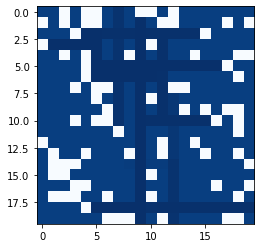

Run: 11
Team: 229568fa-fc85-4c4b-820c-5e2619411d53
? ? X ? X X ? ↓ ? X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S ↓ ← ↓ ← ↓ ← ↓ ← ← ← X ↓ ? ? ? 

X → → → → ↓ ← ↓ ← ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? X ? X ↓ ← ↓ X ↓ ? ↓ ? ? X ? ↓ ? X X 

? ? ? ? X → → → → ↓ ← ↓ ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↓ → ↓ ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ← ↓ ← ↓ X X ? ? ↓ ? ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? ? ? ? ? X ↑ ? ↓ ? ↓ ? X ? X ↓ X X ? 

? ? ? X ? X X ↑ ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ← ↓ ← ← ← ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ↑ X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ↑ ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ? ? ? ↑ ? ↓ ? ? ? X 

? X X ← ← ← ← ← ↑ ↓ X ? ? ↑ ? ↓ ? ? ? ? 

? ? ? X X ? ? ? ↑ ↓ ? ? ? ↑ ? ↓ X ? ? X 

? X X X ? ? X ← ↑ ← X ? ? ↑ ? ↓ ↓ ? X ? 

? ? ? ? X → → → → ↑ → → → ↑ → → ↓ ← ← ← 

? ? ? ? ? ? X X X ↑ ? X → ↑ ← ← ← X X ? 



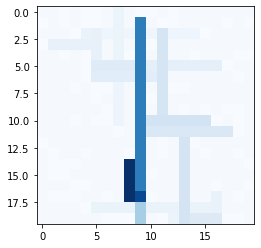

Run: 11
Team: abb505fc-7960-4d26-bb86-6556920b9714
? ? X ? X X ? ↓ ? X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S ↓ ← ↓ ← ↓ ← ↓ ← ← ← X ↓ ? ? ? 

X → → → → ↓ ← ↓ ← ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? X ? X ↓ ← ↓ X ↓ ? ↓ ? ? X ? ↓ ? X X 

? ? ? ? X ↓ → → → ↓ ← ↓ ← ← ← ← ← X ? ? 

? ? ? ? X → → → → → → ↓ ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ← ↓ ← ↓ X X ? ? ↓ ? ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? ? ? ? ? X ↑ ? ↓ ? ↓ ? X ? X ↓ X X ? 

? ? ? X ? X X ↑ ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ← ↓ ← ← ← ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ↑ X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ↑ ↓ X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ? ↑ ↑ ↓ ? ? ? ? 

? ? ? X X → → → → → → → → → ↑ ↓ X ? ? X 

? X X X ? ? X ? ? ↓ X ? ? ↑ ↑ ↓ ↓ ? X ? 

? ? ? ? X → → → → → → → → → ↑ ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X → ↑ ↑ ← ← X X ? 



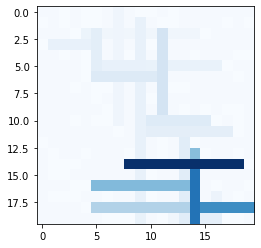

Run: 11
Team: fb5c2193-2406-4f9c-a676-dc2e2c2e2cff
? ? X ? X X ? ↓ ? X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S ↓ → ↓ ← ↓ ← ↓ ← ← ← X ↓ ? ? ? 

X → → → → ↓ ← ↓ ← ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? X ? X ↓ ← ↓ X ↓ ? ↓ ? ? X ? ↓ ? X X 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↓ → ↓ ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ← ↓ ← ↓ X X ? ? ↓ ? ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? ? ? ? ? X ↑ ? ↓ ? ↓ ? X ? X ↓ X X ? 

? ? ? X ? X X ↑ ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ← ↓ ← ← ← ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ↑ X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ↑ ↓ X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ? ↑ ↑ ↓ ? ? ? ? 

? ? ? X X → → → → → → → → ↑ ↑ ↓ X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ↑ ↑ ↓ ↓ ? X ? 

? ? ? ? X → → → → → → → → → ↑ ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X → ↑ ↑ ← ← X X ? 



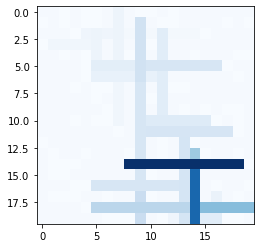

Run: 12
Team: cfda58db-0373-4bac-93b1-225d5a805038
? ? X ? X X ? ↓ ? X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X S ↓ → ↓ ← ↓ ← ↓ ← ← ← X ↓ ? ? ? 

X → → → → ↓ ← ↓ ← ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? X ? X ↓ ← ↓ X ↓ ? ↓ ? ? X ? ↓ ? X X 

? ? ? ? X → → → → ↓ → → → → → → ← X ? ? 

? ? ? ? X → → → → ↓ → ↓ ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ← ↓ ← ↓ X X ? ? ↓ ? ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? ? ? ? ? X ↑ ? ↓ ? ↓ ? X ? X ↓ X X ? 

? ? ? X ? X X ↑ ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ← ↓ ← ← ← ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ↑ X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ↑ ? X ? ? X ? 

? X X X ? ? ? ? G ← ? ? ? ↑ ? ↓ ? ? ? X 

? X X ← ← ← ← ← ← ↑ X ? ? ↑ ? ↓ ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ↑ ? ↓ X ? ? X 

? X X X ? ? X ← ← ↑ X ? ? ↑ ? ↓ ↓ ? X ? 

? ? ? ? X → → → → ↑ → → → ↑ → → ↓ ← ← ← 

? ? ? ? ? ? X X X ↑ ← X → ↑ ← ← ← X X ? 



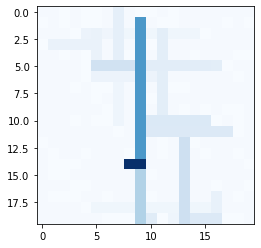

Run: 12
Team: f05ea723-dd49-4771-95cd-c97136e462db
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S ↓ → ↓ ← ↓ ← ← ← ← ← X ? ? ? ? 

X ← ← ← ← ↓ ← ← ← ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ? ↓ X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ↓ ? ↓ ↓ ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X → → → ↓ ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ ↓ ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X → → ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ↓ ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ↓ ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



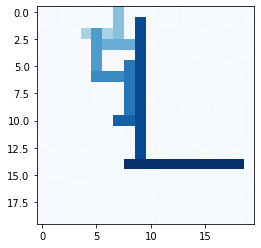

Run: 12
Team: 5edb168e-f2c5-4f4c-b428-ef81b2c134f2
? ? X ? X X ? ↓ ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → → ↓ ← ↓ ← ← ← ← ← X ? ? ? ? 

X → → → → → → → → ↓ X ↓ ? ↑ ? ↓ ? ? ? ? 

? ? X ? X ↑ ? ↓ X ↓ ? ↓ ? ↑ X ↓ ? ? X X 

? ? ? ? X ↑ ← ↓ ↓ ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X ↑ → → ↓ ↓ → → → ↑ ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ↓ ? ↓ X X ? ↑ ? ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↓ X ↓ ↓ ? ? ↑ ? ? ? ? 

? ? ? ? ? ? X → → ↓ → → ↓ X ? X ? X X ? 

? ? ? X ? X X ↓ ↓ ↓ ? ↓ ↓ ? ? ? X ↓ X ? 

? ? ? ? ? ? ? X ↓ ↓ ? ↓ ↓ ? ? ? ? ↓ X ? 

X ? ? ? ? ? ? ? ↓ ↓ ? X ↓ ? X ? ? ↓ ? ? 

? X ? ? X ? ? ? X ↓ ← X ↓ ? ? X ? ↓ X ? 

? X X X ? ? ? ? G ↓ ? ? ↓ ? ? ? ? ↓ ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ↓ ? ? ? ? ↓ ? ? 

? ? ? X X ? ? ? ↑ ↓ ? ? ↓ ? ? ? X ↓ ? X 

? X X X ? ? X ← ↑ ← X → → → → → → ↓ X ? 

? ? ? ? X ← ← ← ↑ ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ↓ ? ? ? ? X X ? 



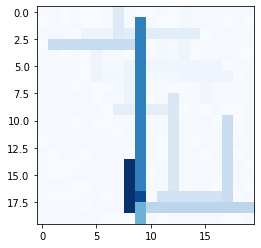

Run: 12
Team: be1a7bae-bb01-4959-9f93-ce987aa080fa
? ? X ? X X ? ↓ ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ? ↓ ? ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → → ↓ ← ↓ ← ← ← ← ← X ? ? ? ? 

X → → → → → ← ← ← ↓ X ↓ ? ↑ ? ↓ ? ? ? ? 

? ? X ? X ↑ ? ↓ X ↓ ? ↓ ? ↑ X ↓ ? ? X X 

? ? ? ? X ↑ ← ↓ ↓ ↓ ← ← ← ↑ ← ← ← X ? ? 

? ? ? ? X ↑ → → ↓ ↓ → → → ↑ ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ↓ ? ↓ X X ? ↑ ? ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↓ X ↓ ↓ ? ? ↑ ? ? ? ? 

? ? ? ? ? ? X → → ↓ → → ↓ X ? X ? X X ? 

? ? ? X ? X X ↓ ↓ ↓ ? ↓ ↓ ? ? ? X ↓ X ? 

? ? ? ? ? ? ? X ↓ ↓ ? ↓ ↓ ? ? ? ? ↓ X ? 

X ? ? ? ? ? ? ? ↓ ↓ ? X ↓ ? X ? ? ↓ ? ? 

? X ? ? X ? ? ? X ↓ ← X ↓ ? ? X ? ↓ X ? 

? X X X ? ? ? ? G ↓ ? ? ↓ ? ? ? ? ↓ ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ↓ ? ? ? ? ↓ ? ? 

? ? ? X X ? ? ? ↑ ↓ ? ? ↓ ? ? ? X ↓ ? X 

? X X X ? ? X ← ↑ ← X → → → → → → ↓ X ? 

? ? ? ? X ← ← ← ↑ ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ↓ ? ? ? ? X X ? 



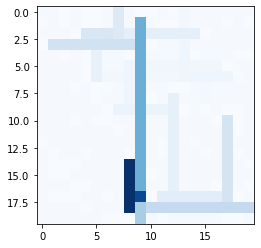

Run: 12
Team: bd8a20b5-1837-49f8-b179-3b6780d67987
← ↓ X ? X X ? ↓ ? X X ? X ↓ ? ? ? ? ? ? 

X ↓ X ? X X ? ↓ ? ↓ ? X X ↓ ? ? ? X ? X 

? ↓ ? X S → → → → → → ↓ ← ↓ ← X ? ? ? ? 

X ↓ → ↓ ← ← ← ← ← ← X ↓ ? ↓ ? ↓ ? ? ? ? 

↓ ↓ X ↓ X ↑ ? ↓ X ↑ ? ↓ ? ↓ X ↓ ? ? X X 

↓ ↓ ↓ ↓ X ↑ ← ↓ ↓ ← ← ← ← ← ← ← ← X ? ? 

→ ↓ ↓ ← X → → → ↓ → → → → → → ↑ ← ← X ? 

↓ ↓ ↓ X ↓ X X ↓ ↓ ↑ ? ↓ X X ? ↑ ? ? ? ? 

→ ↓ ↓ ← ← X ? ↓ ↓ ↑ X ↓ ↓ ? ? ↑ ? ? ? ? 

↑ ↓ ↓ ← ← ← X → ↓ ↑ → → ↓ X ? X ? X X ? 

↑ ↓ ↓ X ↓ X X ↓ ↓ ↑ ? ↓ ↓ ? ? ? X ↓ X ? 

→ → → → → ↓ ↓ X ↓ ↑ ? ↓ ↓ ? ? ? ? ↓ X ? 

X → → → ↑ ↓ ← ← ← ← ← X ↓ ? X ? ? ↓ ? ? 

? X ↑ ? X ↓ ↓ ↑ X ↑ ← X ↓ ? ? X ? ↓ X ? 

? X X X ? → → → G ↑ ? ? ↓ ? ? ? ? ↓ ? X 

? X X ? ? ↑ ↓ ↑ ? ↑ X ? ↓ ? ? ? ? ↓ ? ? 

? ? ? X X ↑ → ↑ ← ↑ ← ← ↓ ← ← ← X ↓ ? X 

? X X X ? ↑ X ↑ ← ↑ X → → → → → → ↓ X ? 

? ? ? ? X ↑ ← ↑ ← ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ? X ↓ ? ? ? ? X X ? 



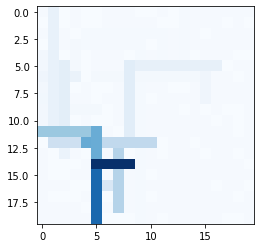

Run: 13
Team: c8ebd19e-80ac-49fb-9ca7-a1556a339620
← ↓ X ? X X ? ↓ ? X X ? X ↓ ? ? ? ? ? ? 

X ↓ X ? X X ? ↓ ? ↓ ? X X ↓ ? ? ? X ? X 

? ↓ ? X S → → ↓ ← ↓ ← ↓ ← ↓ ← X ? ? ? ? 

X ↓ → ↓ ← ← ← ← ← ← X ↓ ? ↓ ? ↓ ? ? ? ? 

↓ ↓ X ↓ X ↑ ? ↓ X ↓ ? ↓ ? ↓ X ↓ ? ? X X 

↓ ↓ ↓ ↓ X ↑ ← ↓ ↓ ← ← ← ← ← ← ← ← X ? ? 

→ ↓ ↓ ← X → → → ↓ → → → → → → ↑ ← ← X ? 

↓ ↓ ↓ X ↓ X X ↓ ↓ ↓ ? ↓ X X ? ↑ ? ? ? ? 

↓ ↓ ↓ ← ← X ? ↓ ↓ ↓ X ↓ ↓ ? ? ↑ ? ? ? ? 

↓ ↓ ↓ ← ← ← X → ↓ → → → ↓ X ? X ? X X ? 

→ ↓ ↓ X ↓ X X ↓ ↑ ↓ ? ↓ ↓ ? ? ? X ↓ X ? 

→ ↓ → → → ↓ ↓ X ↑ ↓ ? ↓ ↓ ? ? ? ? ↓ X ? 

X → → → → ↓ ↓ ↓ ↑ ← ← X ↓ ? X ? ? ↓ ? ? 

? X ↑ ? X ↓ ↓ ↓ X ↑ ← X ↓ ? ? X ? ↓ X ? 

? X X X ? ↓ ↓ ↓ G ↑ ? ↓ ↓ ? ? ? ? ↓ ? X 

? X X → → → → → ↑ ← X ↓ ↓ ? ? ? ? ↓ ? ? 

? ? ? X X ↓ ↑ ↑ ↑ ↑ ← ← ↓ ← ← ← X ↓ ? X 

? X X X ? ↓ X ↑ ↑ ↑ X → → → → → → ↓ X ? 

? ? ? ? X → → ↑ ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ? X ↓ ? ? ? ? X X ? 



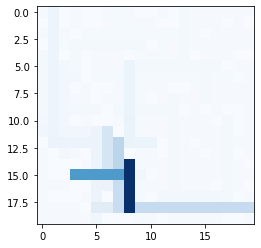

Run: 13
Team: 606333cd-27b2-4796-81ff-b81b45e13202
? ↓ X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ↓ X ? X X ? ↓ ? ↓ ? X X ? ? ? ? X ? X 

← ↓ ← X S → → → → → → ↓ ← ← ← X ? ? ? ? 

X ↑ ? ? ? ? ? ↓ ? ↑ X ↓ ↓ ? ? ? ? ? ? ? 

? ↑ X ? X ? ? ↓ X ↑ ? ↓ ↓ ? X ? ? ? X X 

? ↑ ? ? X → → → → → → → ← ← ← ← ← X ? ? 

? ↑ ? ? X ← ← ↓ ↓ ↑ ← ← ← ← ← ← ← ← X ? 

? ↑ ? X ? X X ↓ ↓ ↑ ? ↓ X X ? ? ? ? ? ? 

? ↑ ? ? ? X ? ↓ ↓ ↑ X ↓ ? ? ? ? ? ? ? ? 

? ↑ ? ? ? ? X ↓ ↓ ↑ ? ↓ ? X ? X ? X X ? 

? ↑ ? X ? X X → ↓ ↑ ← ← ← ← ← ← X ? X ? 

→ ↑ → → → ↓ ← X ↓ ↑ ? ↓ ? ? ? ? ? ? X ? 

X ↑ ← ← ← ← ← ← ← ↑ ← X ? ? X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↑ ? X ? ? ? X ? ? X ? 

? X X X ? ← ← ← G ↑ ? ? ? ? ? ? ? ? ? X 

? X X ← ← ← ← ← ← ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ↓ ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ↓ X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ↓ ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ↓ X X X ↑ ? X ? ? ? ? ? X X ? 



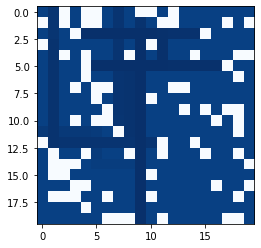

Run: 13
Team: 749f753c-1dd9-45e9-9dc9-16e7b6f08310
? ? X ? X X ? ↓ ? X X ? X → → → ↓ → ↓ ← 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ↓ X ↓ X 

? ? ? X S → → ↓ ← ← ← ↓ ← ← ← X ↓ ? ↓ ? 

X ? ? ? ? ↓ ? ↓ ? ↑ X ↓ ↑ ← ← ← ← ← ← ← 

? ? X ? X ↓ ? ↓ X ↑ ? ↓ ↑ ? X ? ↑ ? X X 

? ? ? ? X → → ↓ → ↑ → ↓ ↑ ← ↓ ← ↑ X ? ? 

? ? ? ? X → → ↓ → ↑ → ↓ → → ↓ ← ← ← X ? 

? ? ? X ? X X ↓ ? ↑ ? ↓ X X ↓ ? ↑ ? ? ? 

? ? ? ? ? X ? ↓ ? ↑ X ↓ ↓ ? ↓ ? ↑ ? ? ? 

? ? ? ? ? ? X ↓ ? ↑ ↓ ↓ ↓ X ↓ X ↑ X X ? 

? ? ? X ? X X → → → → → ↓ ↓ ← ← X ? X ? 

? ? ? ? ? ? ? X → ↑ → ↑ ↓ ↓ ↓ ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↑ ↓ X ↓ ↓ X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ↓ X ↓ ↓ ? X ? ? X ? 

? X X X ? ? ? ? G ↑ ↓ ? ↓ ↓ ? ? ? ? ? X 

? X X ← ← ← ← ← ↑ ↑ X ? ↓ ↓ ? ? ? ? ? ? 

? ? ? X X ? ? ? ↑ ↑ ? ? ↓ ↓ ? ? X ? ? X 

? X X X ? ? X ? ↑ ↑ X ← ↓ ← ← ← ← ← X ? 

? ? ? ? X ← ← ← ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ↓ ↑ ? ? ? X X ? 



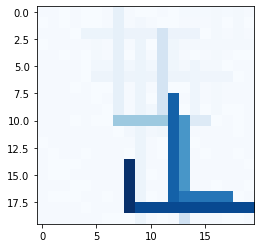

Run: 13
Team: 21950d1d-3a3c-4770-820f-49154bda0832
? ? X ? X X ? ↓ ? X X ? X → → → ↓ → ↓ ← 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ↓ X ↓ X 

? ? ? X S → → ↓ ← ← ← ↓ ↓ ← ← X ↓ ? ↓ ? 

X ? ? ? ? ↓ ? ↓ ? ↑ X ↓ ↓ → → → ↓ ← ← ← 

? ? X ? X ↓ ? ↓ X ↑ ? ↓ ↓ ? X ? ↓ ? X X 

? ? ? ? X → → ↓ → ↑ → ↓ ↓ ← ↓ ← ← X ? ? 

? ? ? ? X → → ↓ → → → ↓ → → ↓ ← ← ← X ? 

? ? ? X ? X X ↓ ? ↑ ? ↓ X X ↓ ? ↑ ? ? ? 

? ? ? ? ? X ? ↓ ? ↑ X ↓ ↓ ? ↓ ? ↑ ? ? ? 

? ? ? ? ? ? X ↓ ? ↑ ↓ ↓ ↓ X ↓ X ↑ X X ? 

? ? ? X ? X X → → → → ← ↓ ← ← ← X ↓ X ? 

? ? ? ? ? ? ? X → → → → ↓ ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↑ ↓ X ↓ ↑ X ? ? ↑ ? ? 

? X ? ? X ? ? ? X ↑ ↓ X ↓ ↑ ? X ? ↑ X ? 

? X X X ? ? ? ? G ↑ ↓ ↓ ↓ ↑ ? ? ? ↑ ? X 

? X X ← ← ← ← ← ↑ ↑ X ↓ ← ← ← ← ← ← ← ← 

? ? ? X X ← ← ← ↑ ← ← ← ← ← ← ← X ↑ ? X 

? X X X ? ? X ? ? ↑ X ↓ ↑ ↑ ? ? ↓ ↑ X ? 

? ? ? ? X → → → → → → → ↑ → → → → ↑ ← ← 

? ? ? ? ? ? X X X ↑ ? X ↑ → → → ↑ X X ? 



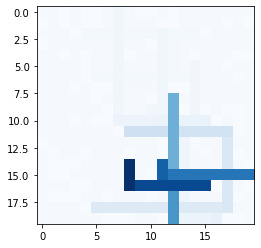

Run: 14
Team: 2fdc3809-e5a3-4c51-8ca2-93613d41dc70
? ? X ? X X ? ↓ ? X X ? X → → → ↓ → ↓ ← 

X ? X ? X X ? ↓ ? ↓ ? X X ? ? ? ↑ X ↓ X 

? ? ? X S ↓ → ↓ ← ← ← ↓ ← ← ← X ↑ ? ↓ ? 

X ? ? ? ? ↓ ? ↓ ? ↑ X ↓ ↑ ← ← ↓ ← ← ← ← 

? ? X ? X ↓ ? ↓ X ↑ ? ↓ ↑ ? X ↓ ↑ ? X X 

? ? ? ? X → → → → → → → → → → ↓ ← X ? ? 

? ? ? ? X → → ↓ ↑ ↑ → ↑ ↑ → ↓ ↓ ← ← X ? 

? ? ? X ? X X ↓ ↑ ↑ ? ↑ X X ↓ ↓ ↑ ? ? ? 

? ? ? ? ? X ? ↓ ↑ ↑ X ↑ ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X ↓ ↑ ↑ ↓ ↑ ↓ X ↓ X ↑ X X ? 

? ? ? X ? X X → → → → → ↓ ↓ ← ← X ↓ X ? 

? ? ? ? ? ? ? X → → → → ↓ ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ↑ ↑ ↓ X ↓ ↑ X ? ? ↑ ? ? 

? X ? ? X ? ? ? X ↑ ↓ X ↓ ↑ ? X ? ↑ X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ← ← ← ← ← ← ↑ X ↓ ↑ ↑ ← ← ← ↑ ← ← 

? ? ? X X → → → → → → → ↑ ↑ ← ← X ↑ ? X 

? X X X ? ? X ? ? ↑ X ↓ ↑ ↑ ? ? ↓ ↑ X ? 

? ? ? ? X → → → → → → → ↑ → → → → ↑ ← ← 

? ? ? ? ? ? X X X ↑ ? X ↑ ↑ → → ↑ X X ? 



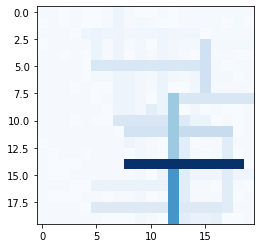

Run: 14
Team: 9e484e9f-22ac-4300-b952-a19db4277897
? ? X ? X X ? ? ? X X ? X ↓ ↓ ? ↓ ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ↓ ↓ ? ↓ X ? X 

? ? ? X S → ← ← ← ← ← ← ← ← ← X ↓ ? ? ? 

X ? ? ? ? ↓ ? ? ? ↓ X → → ↑ → → ↓ ← ← ← 

? ? X ? X ↓ ? ? X ↓ ? ↓ ? ↑ X ? ↓ ? X X 

? ? ? ? X ↓ ? ? ? ↓ ? ↓ ? ↑ ? ? ↓ X ? ? 

? ? ? ? X → → → → → → → ← ← ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ↓ X X ? ? ↓ ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ↓ ? X ? X ↓ X X ? 

? ? ? X ? X X ? ? ↓ ? ↓ ? ? ? ? X ↓ X ? 

? ? ? ? ? ? ? X ? ↓ ? ↓ ? ? ? ? ? ↓ X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ↓ ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ↓ X ? 

? X X X ? ? ? ? G ↓ → → → → → → → → ? X 

? X X ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ↑ ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ? ? X ↑ ? X 

? X X X ? ? X ? ? ↓ X ? ? ? ? ? ? ↑ X ? 

? ? ? ? X → → → → → → → → → → → → ↑ ← ← 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



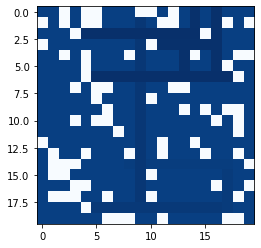

Run: 14
Team: 41768e07-1576-4773-8c36-ba52c8e4a5a7
? ? X ? X X ? ? ? X X ? X ↓ ↓ ? ↓ ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ↓ ↓ ? ↓ X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ↓ ? ? ? 

X ? ? ? ? ↓ ? ? ? ↓ X → → ↑ → → ↓ ← ← ← 

? ? X ? X ↓ ? ? X ↓ ? ↓ ? ↑ X ? ↓ ? X X 

? ? ? ? X ↓ ? ? ? ↓ ? ↓ ? ↑ ? ? ↓ X ? ? 

? ? ? ? X → → → → ↓ → → → ↑ ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ↓ X X ? ? ↓ ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ↓ ? X ? X ↓ X X ? 

? ? ? X ? X X ? ? ↓ ? ↓ ? ? ? ? X ↓ X ? 

? ? ? ? ? ? ? X ? ↓ ? ↓ ? ? ? ? ? ↓ X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ↓ ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ↓ X ? 

? X X X ? ? ? ? G ↓ ? ? ? ? ? ↓ ? ↓ ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ? ? ? ↓ ? ↓ ? ? 

? ? ? X X ← ← ← ↑ ← ← ← ← ← ← ← X ↓ ? X 

? X X X ? ? X ? ↑ ↓ X ? ? ? ? ↑ ? ↓ X ? 

? ? ? ? X → → → ↑ → → → → → → ↑ ← ← ← ← 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ↑ ? X X ? 



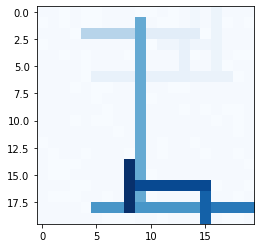

Run: 14
Team: aed9e1be-63db-46a6-8455-763f5625c3ab
? ? X ? X X ? ? ? X X ? X ↓ ↓ ? ↓ ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ↓ ↓ ? ↓ X ? X 

? ? ? X S → → → → ↓ → → → → ← X ↓ ? ? ? 

X ? ? ? ? ↓ ? ? ? ↓ X → → ↑ → → ↓ ← ← ← 

? ? X ? X ↓ ? ? X ↓ ? ↓ ? ↑ X ? ↓ ? X X 

? ? ? ? X ↓ ? ? ? ↓ ? ↓ ? ↑ ? ? ↓ X ? ? 

? ? ? ? X → → → → ↓ → → → ↑ ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ↓ X X ? ? ↓ ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ↓ ? ? ? ? ↓ ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ↓ ? X ? X ↓ X X ? 

? ? ? X ? X X ? ? ↓ ? ↓ ? ? ? ? X ↓ X ? 

? ? ? ? ? ? ↓ X ? ↓ ? ↓ ? ? ? ? ? ↓ X ? 

X ? ? ? ? ? ↓ ? ? ↓ ? X ? ? X ? ? ↓ ? ? 

? X ? ? X ? ↓ ? X ↓ ? X ? ? ? X ? ↓ X ? 

? X X X ? ? → → G ↓ ? ? ? ? ? ↓ ? ↓ ? X 

? X X → → → ↑ ← ← ← X ? ? ? ? ↓ ? ↓ ? ? 

? ? ? X X ← ↑ ← ← ↑ ← ← ← ← ← ← X ↓ ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ↑ ? ↓ X ? 

? ? ? ? X → → → → ↑ → → → → → ↑ ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ↑ ? X X ? 



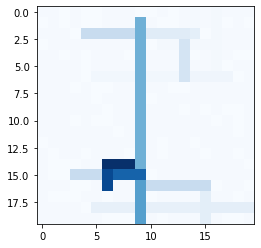

Run: 14
Team: e6cb91d1-f10a-43b1-90bf-65134bfd5345
? ? X ? X X → → ↓ X X ? X ↓ ↓ ? ↓ ? ? ? 

X ? X ? X X → → → ↓ ← X X ↓ ↓ ? ↓ X ? X 

? ? ? X S → ← ← ← ↓ ← ← ← ← ← X ↓ ? ? ? 

X ? ? ? ? ↓ ↑ ↓ ↓ ↓ X ↓ → ↑ → → ↓ ← ← ← 

? ? X ? X ↓ ↑ ↓ X ↓ → ↓ ← ↑ X ? ↓ ? X X 

? ? ? ? X ↓ ↑ ← ← ↓ ← ← ← ↑ ← ← ← X ? ? 

? ? ? ? X → → → → ↓ → → → ↑ ← ← ← ← X ? 

? ? ? X ? X X ↑ ? ↓ ? ↓ X X ? ? ↓ ? ? ? 

? ? ? ? ? X ← ↑ ← ↓ X ↓ ↓ ? ? ? ↓ ? ? ? 

? ? ? ? ? ? X ↑ ? ↓ ? ↓ ↓ X ? X ↓ X X ? 

? ? ? X ? X X → → ↓ → → ↓ ← ← ← X ↓ X ? 

? ? ? ? ? ? ? X ? ↓ ? ↑ ↓ ? ? ? ? ↓ X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ↓ ? X ? ? ↓ ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ? ? X ? ↓ X ? 

? X X X ? ? ? ? G ← ? ? ↓ ? ? ↓ ? ↓ ? X 

? X X ? ? ? ? ? ? ↑ X ? ↓ ? ? ↓ ? ↓ ? ? 

? ? ? X X ← ← ← ← ↑ ← ← ← ← ← ← X ↓ ? X 

? X X X ? ? X ? ? ↑ X ? ↓ ? ? ↑ ? ↓ X ? 

? ? ? ? X → → → → ↑ → → → → → ↑ ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ↓ ? ? ↑ ? X X ? 



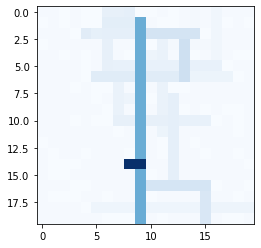

Run: 15
Team: 3ef203de-cc01-4f59-9cef-4b4e55077651
? ? X ? X X → ↓ ↓ X X ? X ↓ ↓ ? ↓ ? ? ? 

X ? X ? X X → → → ↓ ← X X ↓ ↓ ? ↓ X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ↓ ? ? ? 

X ? ? ? ? ↓ ↑ ↓ ↓ ↓ X ↓ ↓ ↑ → → ↓ ← ← ← 

? ? X ? X ↓ ↑ ↓ X ↓ ↓ ↓ ↓ ↑ X ↓ ↓ ? X X 

? ? ? ? X → → ↓ ↓ ↓ ↓ ↓ ↓ ↑ ← ← ↓ X ? ? 

? ? ? ? X → → → ↓ ↓ ← ← ← ↑ ← ← ← ← X ? 

? ? ? X ? X X ↑ ↓ ↓ ← ↓ X X ? ↑ ↓ ↓ ↓ ? 

? ? ? ? ? X → → ↓ ↓ X ↓ ↓ → → ↑ ← ← ← ← 

? ? ? ? ? ? X ↑ ↓ ↓ ? ↓ ↓ X ? X ↓ X X ? 

? ? ? X ? X X → ↓ ↓ → → ↓ ← ← ← X ↓ X ? 

? ? ? ? ? ↓ ? X ↓ ↓ ? ↑ ↓ ? ? ? ? ↓ X ? 

X ← ← ← ← ↓ ← ← ← ↓ ← X ↓ ? X ? ? ↓ ? ? 

? X ? ? X ↓ → ↑ X ↓ ? X ↓ ? ? X ? ↓ X ? 

? X X X ? ↓ ? ↑ G ↓ ? ? ↓ ? ? ↓ ? ↓ ? X 

? X X ? ? ↓ ? ↑ ↑ ↓ X ? ↓ ? ? ↓ ? ↓ ? ? 

? ? ? X X ↓ ← ↑ ↑ ↓ ← ← ← ← ← ← X ↓ ? X 

? X X X ? ↓ X ↑ ↑ ↓ X ? ↓ ? ? ↑ ? ↓ X ? 

? ? ? ? X → → → ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ? X ↓ ? ? ↑ ? X X ? 



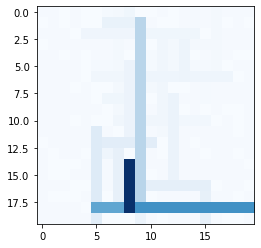

Run: 15
Team: 94970e95-ac6f-43ee-80ff-7317d6f62fcd
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → → → ↓ ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ↓ ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ↓ ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ↓ X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ↓ ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X → → → → → ↓ X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ↓ ↓ ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ↓ ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↑ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ← ← ← ← ↑ ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ? ? ↑ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ↓ ? ? ? ? X X ? 



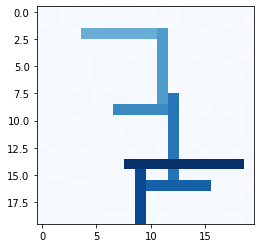

Run: 15
Team: 38844b4d-b674-457e-8925-9306f0b9af26
? ? X ? X X ? ↓ ? X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ← ↓ ← ↓ ← X X ? ? ? ↓ X ? X 

? ? ? X S → → → → → → ↓ ← ← ← X ↓ ? ? ? 

X ? ? ? ? ? ? ↓ ? ↑ X ↓ → → → → ↓ ← ← ← 

? ? X ? X ? ? ↓ X ↑ ↓ ↓ ↓ ? X ↑ ↓ ? X X 

? ? ? ? X → → → → → → ↓ → → → → ↓ X ? ? 

? ? ? ? X → → → → ↑ ↑ ↓ ← ← ← ← ↓ ← X ? 

? ? ? X ? X X ↑ ? ↑ ↑ ↓ X X ? ↑ ↓ ? ? ? 

? ? ? ? ? X ? ↑ ? ↑ X ↓ ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X → → → → → ↓ X ? X ↑ X X ? 

? ? ? X ? X X ↑ ← ↑ ← ↓ ↓ ← ← ← X ? X ? 

? ? ? ? ? ? ? X ? ↑ ? ↓ ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↑ ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ? X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↑ X → → → → → → → ↑ ← 

? ? ? X X ← ← ← ← ↑ ← ← ↑ ← ← ← X ? ↑ X 

? X X X ? ? X ? ? ↑ X ? ↑ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ↑ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ↑ ? ? ? ? X X ? 



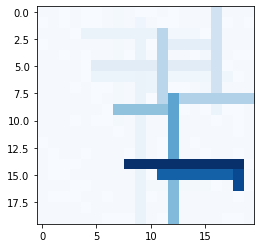

Run: 15
Team: 4063d0ae-5c8f-457c-9d64-2eb2d5b056f3
? ? X ? X X ? ↓ ? X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ← ↓ ← ↓ ← X X ? ? ? ↓ X ? X 

? ? ? X S → → ↓ → ↓ → ← ← ← ← X ↓ ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ↓ ↓ ? ? ↓ ↓ ? ? ? 

? ? X ? X ? ? ↓ X ↓ ↓ ↓ ↓ ? X ↓ ↓ ? X X 

? ? ? ? X → → → → ↓ → → → → → → ← X ? ? 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ↓ ↓ ↑ ↓ X X ? ↓ ↓ ? ? ? 

? ? ? ? ? X → ↑ ↓ ↓ X ↓ ↓ ? ? ↓ ↓ ? ? ? 

? ? ? ? ? ? X ↑ ↓ ↓ ↓ → ↓ X ? X ↓ X X ? 

? ? ? X ? X X ↑ ← ↓ ↓ ← ↓ ← ← ← X ↓ X ? 

? ? ? ? ? ? ? X → → → → → → → → ← ← X ? 

X → → → → → → → → ↑ ← X ↑ ? X ? ↓ ↑ ? ? 

? X ? ? X ? ? ? X ↑ ↓ X ↑ ? ? X ↓ ↑ X ? 

? X X X ? ? ? ? G ↑ → → ↑ ? ? ? ↓ ↑ ? X 

? X X ? ? ? ? ? ? ↑ X → → → → → → ↑ ← ← 

? ? ? X X ← ← ← ← ↑ ← ← ↑ ← ← ← X ↑ ? X 

? X X X ? ? X ? ? ↑ X ? ↑ ? ? ? ? ↑ X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ↑ ? ? ? ? ↑ ? ? 

? ? ? ? ? ? X X X ↑ ? X ↑ ? ? ? ? X X ? 



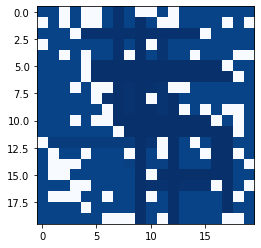

Run: 16
Team: 9c9bb012-765e-4b61-9278-73b94888f92b
? ? X ? X X ↓ ↓ ? X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ↓ ↓ ← ↓ ← X X ? ? ? ↓ X ? X 

? ? ? X S → → ↓ → ↓ → ↓ ← ← ← X ↓ ? ? ? 

X ? ? ? ? ? ↓ ↓ ? ↓ X ↓ ← ← ← ← ← ← ← ← 

? ? X ? X ? ↓ ↓ X ↓ → ↓ ↓ ← X ↑ ↓ ? X X 

? ? ? ? X → → → → → → ↓ → → → ← ← X ? ? 

? ? ? ? X → → ↓ ↓ ↓ ↑ ↓ ← ← ← ← ↑ ← X ? 

? ? ? X ? X X ↓ ↓ ↓ ↑ ↓ X X ↑ ↑ ↑ ? ? ? 

? ? ? ? ? X → ↓ ↓ ↓ X ↓ ↓ ← ↑ ↑ ↑ ← ← ← 

? ? ? ? ? ? X ↓ ↓ ↓ ↓ ↓ ↓ X ↑ X ↑ X X ? 

? ? ? X ? X X → → → → → → → ← ← X ↓ X ? 

? ? ? ? ? ? ? X → → → → ← ← ← ← ← ← X ? 

X → → → → → → → → → ↑ X ↑ ? X ? ↓ ↑ ? ? 

? X ? ? X ? ? ? X ↑ ↑ X ↑ ? ? X ↓ ↑ X ? 

? X X X ? ? ? ? G ↑ ↑ ? ↑ ? ? ? ↓ ↑ ? X 

? X X ? ? ? ? ? ? ↑ X → ↑ → → → → ↑ ← ← 

? ? ? X X ← ← ← ← ↑ ← ← ↑ ← ← ← X ↑ ? X 

? X X X ? ? X ? ? ↑ X ? ↑ ? ? ? ? ↑ X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ↑ ? ? ? ? ↑ ? ? 

? ? ? ? ? ? X X X ↑ ? X ↑ ? ? ? ? X X ? 



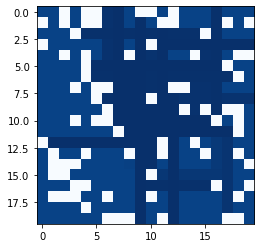

Run: 16
Team: 64ebc4b7-9e9e-4231-9615-1516b5b56d44
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ← ← ← ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ↑ ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ↓ ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ↓ X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ↓ G ↓ ? ? ? ? ? ? ? ? ? X 

? X X → → → → → ↑ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ← ← ↑ ↑ ← ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ↑ ↑ ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ↑ ↑ ↓ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



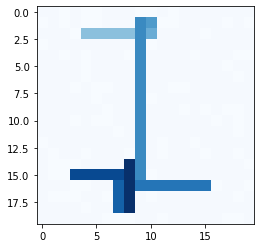

Run: 16
Team: d0c551b6-412a-4ffa-b7ca-02b59986f7a2
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ← ↓ ← ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → ↓ → → ↑ ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ← ← ↓ ← ← ← ← ← ← ← ← ← X ? ? 

? ? ? ? X ← ← ↓ ↑ ← ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ↑ ↑ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X → → → ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ ↑ ↑ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ↓ ↑ ↑ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ↓ ? X ↑ ↑ ? ? ? ? ? ? ? ? X ? 

X ← ← ← ← ↓ ← ← ↑ ↑ ← X ? ? X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↑ ? X ? ? ↓ X ? ? X ? 

? X X X ? ↓ ? ? G ↑ → → → → → ? ? ? ? X 

? X X ? ? ↓ ? ? ? ↑ X ? ? ? ↑ ? ? ? ? ? 

? ? ? X X ↓ ? ? ? ↑ ? ? ? ? ↑ ? X ? ? X 

? X X X ? ↓ X ? ? ↑ X ? ? ? ↑ ? ↓ ? X ? 

? ? ? ? X → → → → ↑ → → → → → → ↓ ← ← ← 

? ? ? ? ? ↓ X X X ↑ ? X ← ← ↑ ← ← X X ? 



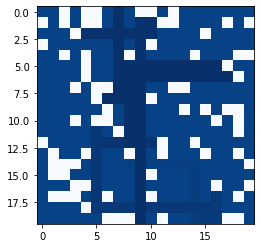

Run: 16
Team: 17a7172a-dcf5-40cd-bb54-aaf930ea5675
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ← ↓ ← ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → → ↑ ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ← ← ↓ ← ← ← ← ← ← ← ← ← X ? ? 

? ? ? ? X ← ← ↓ ↑ ← ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ↑ ↑ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X → → ↑ ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ ↑ ↑ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ↓ ↑ ↑ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ↓ ? X ↑ ↑ ? ? ? ? ? ? ? ? X ? 

X ← ← ← ← ↓ ← ← ↑ ↑ ← X ? ? X ? ? ? ? ? 

? X ? ? X ↓ ← ← X ↑ ? X ? ? ? X ? ? X ? 

? X X X ? ↓ ← ↑ G ↑ ? ? ? ? ? ? ? ? ? X 

? X X ? ? ↓ ? ↑ ? ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ↓ ? ↑ ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ↓ X ↑ ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X → → ↑ ← ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ? X ? ? ? ? ? X X ? 



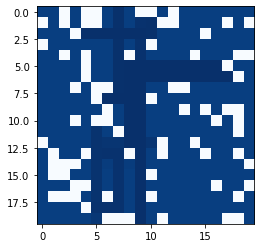

Run: 16
Team: 85541f04-2830-4060-a4d7-b9f0e22471d4
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ← ↓ ← ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ↑ ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ← ← ↓ ← ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X ← ← ↓ ↑ ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ↑ ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X → → → ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ ↑ ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ↓ ↑ ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ↓ ? X ↑ ↓ ? ? ? ? ? ? ? ? X ? 

X ← ← ← ← ↓ ← ← ← ← ← X ? ? X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↑ ? X ? ? ↓ X ? ? X ? 

? X X X ? ↓ ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ↓ ? ? ? ↑ X ? ? ? ↑ ? ? ? ? ? 

? ? ? X X ↓ ? ? ? ↑ ? ? ? ? ↑ ? X ? ? X 

? X X X ? ↓ X ? ? ↑ X ? ? ? ↑ ? ↓ ? X ? 

? ? ? ? X → → → → → → → → → ↑ → ↓ ← ← ← 

? ? ? ? ? ↓ X X X ↑ ? X ← ← ↑ ← ← X X ? 



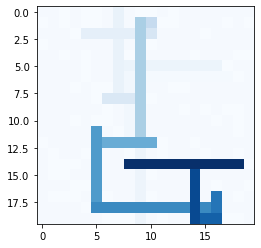

Run: 17
Team: 7d441463-81fc-4589-976d-326b5e2c07b7
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ← ↓ ← ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ↑ ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ? ↓ X ? ? ? ? ? ? ? ? ? 

↓ ? X ? X ? ? ↓ X ↓ ? ? ? ? X ? ? ? X X 

↓ ? ↓ ? X ← ← ↓ ← ↓ ← ← ← ← ← ← ← X ? ? 

↓ ? ↓ ? X ← ← ↓ ↑ ↓ ← ← ← ← ← ← ← ← X ? 

↓ ? ↓ X ↓ X X ↓ ↑ ↓ ? ? X X ? ? ? ? ? ? 

↓ ← ↓ ← ← X → → → ↓ X ? ? ? ? ? ? ? ? ? 

→ → ↓ ← ↓ ← X ↓ ↑ ↓ ← ← ← X ? X ? X X ? 

↓ ? ↓ X ↓ X X ↓ ↑ ↓ ↑ ? ? ? ? ? X ? X ? 

↓ ← ↓ ↓ ← ↓ ← X ↑ ↓ ↑ ? ? ? ? ? ? ? X ? 

X → → → → → → → → ↓ ↑ X ? ? X ? ? ? ? ? 

↓ X → ↑ X ↑ ← ← X ↓ ↑ X ? ? ? X ? ? X ? 

↓ X X X ? ↑ ? ↑ G ↓ ↑ ? ? ? ? ? ? ? ? X 

↓ X X ← ← ↑ ← ↑ ↑ ← X ? ? ? ? ? ? ? ? ? 

↓ ? ? X X ↑ ? ↑ ↑ ↑ ? ? ? ? ? ? X ? ? X 

↓ X X X ← ↑ X ↑ ↑ ↑ X ? ? ? ? ? ? ? X ? 

→ → → ↓ X ↑ → ↑ ↑ ↑ ← ← ← ← ← ← ← ← ← ← 

→ → → → → ↑ X X X ↑ ? X ? ? ? ? ? X X ? 



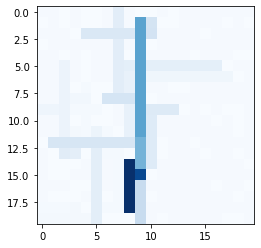

Run: 17
Team: bca79602-c931-4271-87b8-b6d3f72dfca7
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S ↓ ← ← ← ↓ ← ↓ ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ? ? ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ? ? X ↓ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ↓ ? ? ? ↓ ? ↓ ? ? ? ? ? X ? ? 

? ? ? ? X → → → → ↓ → ↓ ← ← ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ↓ X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X → → ↓ ← ← ← X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ↓ ↓ ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ↓ ↓ ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ↓ X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ← X ? ? ↓ X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ? ? ↑ ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ↑ ? X ? ? X 

? X X X ? ? X ← ← ↓ X ? ? ? ↑ ? ? ? X ? 

? ? ? ? X → → → → → → → → → ↑ ← ← ← ← ← 

? ? ? ? ? ? X X X → ↑ X ? ? ↑ ? ? X X ? 



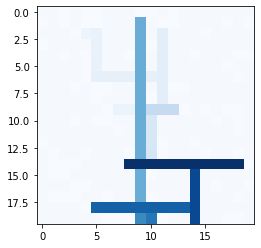

Run: 17
Team: 80d3f14b-972d-400b-98b6-d1c3da338093
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S ↓ ← ← ← ↓ ← ↓ ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ? ? ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ? ? X ↓ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ↓ ← ← ← ↓ ← ↓ ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↓ → ↓ ← ← ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ↓ X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X → → ↓ ← ← ← X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ↓ ↓ ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ↓ ↓ ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ↓ X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ← X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ↓ ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ← ← ← ↑ ← ← ← ← ← ← ← X ? ? X 

? X X X ? ? X → → ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



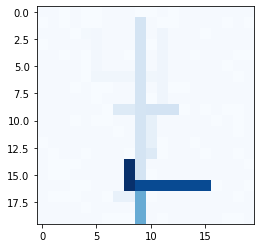

Run: 17
Team: 1bd0d013-c4a9-49cd-8e2e-479c9172638e
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ← ↓ ← ← ← X X ? ? ? ? X ? X 

? ? ? X S → → → → → → ↓ ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ? ↓ ? ↑ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ← ← X ↑ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ↓ ← ← ↓ ↑ ← ↓ ← ← ← ← ← X ? ? 

? ? ? ? X → → → ↓ → → ↓ ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ← ← ← X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↑ X ↑ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X → ↓ ↑ ↓ ↑ ← X ? X ? X X ? 

? ? ? X ? X X ↓ ↓ ↑ ↓ ↑ ? ↓ ? ? X ? X ? 

? ? ? ? ? ? ? X ↓ ↑ ↓ ↑ ? ↓ ? ? ? ? X ? 

X ← ← ← ← ← ← ↓ ← ← ← X ? ↓ X ? ? ? ? ? 

? X ? ? X ? ? ↓ X ↑ ← X ? ↓ ? X ? ? X ? 

? X X X ? ? ? ↓ G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ↓ ? ↑ X ? ? ↑ ? ? ? ? ? ? 

? ? ? X X → → → → → → → → ↑ ← ← X ? ? X 

? X X X ? ? X ← ← ↑ X ? ? ↑ ? ? ? ? X ? 

? ? ? ? X ? ? ↓ ? ↑ ? ? ? ↑ ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ← ↑ ← ← ← X X ? 



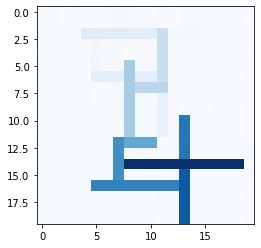

Run: 17
Team: 0af24f30-dec5-4f8d-9dcb-bccd9a8e3d5a
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ← ↓ ← ← ← X X ? ? ? ? X ? X 

? ? ? X S ↓ ← ← ← ← ← ↓ ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ? ↓ ? ↑ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ← ← X ↑ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ↓ ← ← ↓ ↑ ← ↓ ← ← ← ← ← X ? ? 

? ? ? ? X → → → ↓ → → ↓ ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ← ← ← X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↑ X ↑ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X → ↓ ↑ ← ↑ ← X ? X ? X X ? 

? ? ? X ? X X ↓ ↓ ↑ ↓ ↑ ? ↓ ? ? X ? X ? 

? ? ? ? ? ? ? X ↓ ↑ ↓ ↑ ? ↓ ? ? ? ? X ? 

X ← ← ← ← ← ← ↓ ← ← ← X ? ↓ X ? ? ? ? ? 

? X ? ? X ? ? ↓ X ↑ ← X ? ↓ ? X ? ? X ? 

? X X X ? ? ? ↓ G ↑ ↓ ? ? ↓ ? ? ? ? ? X 

? X X ? ? ? ? ↓ ↑ ↑ X ? ? ↓ ? ? ? ? ? ? 

? ? ? X X → → → ↑ → → → → ↓ ← ← X ? ? X 

? X X X ? ? X ← ↑ ↑ X ? ? ↓ ? ? ? ? X ? 

? ? ? ? X ← ← ↓ ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ← ↑ ← ← ← X X ? 



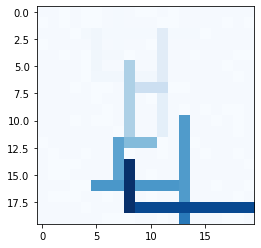

Run: 18
Team: 3292655f-3ff9-43e2-ab4a-d2b1c93b006f
? ? X ? X X ? ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ← ↓ ← ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ → ↓ ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ? ↓ ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ← ← X ↓ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ↓ ← ← ↓ ↓ ← ↓ ← ← ← ← ← X ? ? 

? ? ? ? X → → → ↓ ↓ → ↓ ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ↓ ← ← X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ↑ ↓ X ↓ ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X → → ↓ ← ← ← X ? X ? X X ? 

? ? ? X ? X X ↓ ↑ ↓ ↓ ↑ ↓ ↓ ? ? X ? X ? 

? ? ? ? ? ? ? X ↑ ↓ ↓ ↑ ↓ ↓ ? ? ? ? X ? 

X ← ← ← ← ← ← ↓ ↑ ↓ ← X ↓ ↓ X ? ? ? ? ? 

? X ? ? X ? ? ↓ X ↓ ← X ↓ ↓ ? X ? ? X ? 

? X X X ? ? ? ↓ G ↓ → → ↓ ↓ → ↓ ? ? ? X 

? X X ? ? ? ? ↓ ? ↓ X ? ↓ ↓ ? ↓ ? ? ? ? 

? ? ? X X → → → → ↓ → → → ↓ ← ← X ? ? X 

? X X X ? ? X ← ← ↑ X ? ↓ ↓ ? ↑ ? ? X ? 

? ? ? ? X ← ← ↓ ← ↑ ← ← ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X → ↑ → ← ← X X ? 



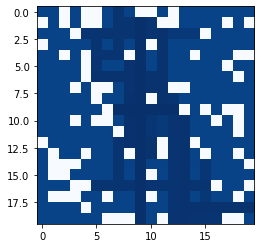

Run: 18
Team: 1fbee42e-44cf-4f9b-a49a-30c8d49354f5
? ? X ? X X ↓ ? ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ↓ ? ? ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → → → → ↓ → ↓ → ↓ ← X ? ? ? ↓ 

X ← ← ← ↑ ← ← ← ← ↓ X ↓ ← ← ← ← ← ← ← ← 

? ? X ? X ? ↓ ? X ↓ ? ↓ ? ↓ X ? ? ? X X 

? ? ? ? X ? ↓ ? ? ↓ ? ↓ ? ↓ ↓ ? ? X ? ? 

? ? ? ? X ← ↓ ← ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ↓ X X ↑ ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X → → → ↑ ← ← ← ← ← 

? ? ? ? ? ? X ? ? ↓ ? ↓ ? X ↑ X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ↓ ? ? ↑ ? X ? X ? 

? ? ? ? ? ? ? X ← ↓ ← ↓ ← ← ↑ ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



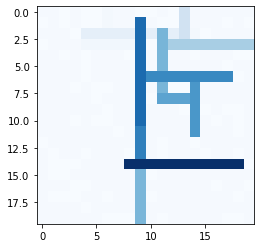

Run: 18
Team: 8576ad26-84c2-402f-98a4-4337f4d0544b
? ? X ? X X ↓ ? ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ↓ ? ? ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → → → → ↓ → ↓ → ↓ ← X ? ? ? ↓ 

X ← ← ← ↑ ← ← ← ← ↓ X ↓ ← ← ← ← ← ← ← ← 

? ? X ? X ? ↓ ? X ↓ ? ↓ ? ↓ X ? ? ? X X 

? ? ? ? X ? ↓ ? ? ↓ ? ↓ ? ↓ ↓ ? ? X ? ? 

? ? ? ? X ← ↓ ← ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ↓ X X ↑ ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X → → → ↑ ← ← ← ← ← 

? ? ? ? ? ? X ? ? ↓ ↓ ↓ ? X ↑ X ? X X ? 

? ? ? X ? X X ? ? ↓ ↓ ↓ ? ? ↑ ? X ? X ? 

? ? ? ? ? ? ? X ← ↓ ↓ ↓ ← ← ↑ ← ← ← X ? 

X ? ? ? ? ? ? ↓ ? ↑ ↓ X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ↓ X → ↓ X ? ? ? X ? ? X ? 

? X X X ? ? ? ↓ G ← ← ? ? ? ? ? ? ? ? X 

? X X ← ← ← ← ↓ ← ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X → → → → ↑ ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ↓ ← ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ↓ ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



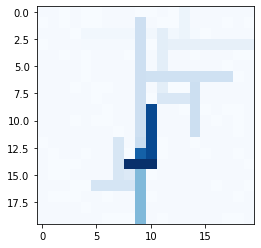

Run: 18
Team: 2b09053f-7877-4455-8bec-43b8a26ede1c
? ? X ? X X ↓ ? ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ↓ ? ? ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → → → → ↓ → ↓ → ↓ ← X ? ? ? ↓ 

X ← ← ← ↑ ← ← ← ← ↓ X ↓ → → → → → → → ← 

? ? X ? X ? ↓ ? X ↓ ? ↓ ? ↓ X ? ? ? X X 

? ? ? ? X ? ↓ ? ? ↓ ? ↓ ? ↓ ↓ ? ? X ? ? 

? ? ? ? X ← ↓ ← ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ↓ X X ↑ ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X → → → ↑ ← ← ← ← ← 

? ? ? ? ? ? X ? ? ↓ ? ↓ ? X ↑ X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ↓ ? ? ↑ ? X ? X ? 

? ? ? ? ? ? ? X ← ↓ ← ↓ ← ← ↑ ← ← ← X ? 

X ? ? ? ? ? ? ↓ ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ↓ X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? → G ↓ ? ? ? ? ? ? ? ? ? X 

? X X ← ← ← ← ↑ ← ← X ? ? ? ? ? ? ? ? ? 

? ? ? X X → → ↑ → ↑ ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ↑ ← ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ↑ ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



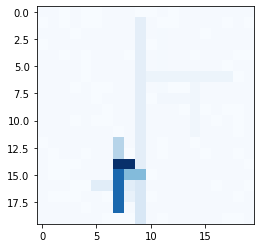

Run: 19
Team: db03499b-d8eb-46e2-b99b-9e98db889142
? ↓ X ? X X ↓ ↓ ? X X ? X ↓ ↓ ? ↓ ? ? ? 

X ↓ X ? X X ↓ ↓ ? ↓ ? X X ↓ ↓ ← ↓ X ? X 

? ↓ ? X S ↓ → ↓ → ↓ → ↓ → → ← X ↓ ? ? ↓ 

X → → → → → → → → ↓ X ↓ → → ↑ ← ↓ ← ← ← 

? ↓ X ? X ↓ → ↑ X ↓ ↓ ↓ ← ← X ← ↓ ← X X 

? ↓ ↓ ? X ↑ ↑ ↑ ↓ ↓ ↓ ↓ ← ← ← ← ← X ? ↓ 

? ↓ ↓ ? X → → → ↓ ↓ ← ← ← ← ← ← ← ← X ↓ 

? ↓ ↓ X ? X X ↑ ↓ ↓ ← ↓ X X ↑ ← ← ← ← ← 

? ↓ ↓ ? ? X → → → ↓ X ↓ → → ↑ ← ↑ ↑ ← ← 

? ↓ ↓ ? ? ? X ↑ ↑ ↓ ↓ ↓ ? X ↑ X ↑ X X ↑ 

? ↓ ↓ X ? X X ↑ ↑ ↓ ← ← ← ← ← ← X ? X ↑ 

→ → ← ← ← ← ← X → ↓ ← ← ← ← ← ← ← ← X ↑ 

X ← ↑ ← ← ← ← ↓ ↑ ↓ ↑ X ? ? X ← ← ← ← ↑ 

? X ↑ ? X ? ↓ ↓ X ↑ ← X ? ? ? X ? ? X ↑ 

? X X X ? ? ← ↓ G ↑ ↑ ? ? ? ? ? ? ? ? X 

? X X ← ← ← ← ↓ ← ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X → → → → ↑ ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ↓ ← ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ↓ ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



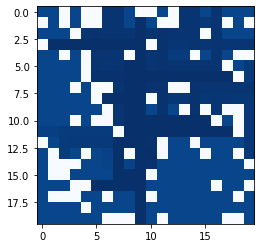

Run: 19
Team: 4282e1aa-460c-4cae-8a80-35673641d56a
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ? ? X X ? ? ? ? X ? X 

? ? ? X S → → → → → → ↓ ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ? X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ? ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ? ? ↓ ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ? ? ↓ ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ? ? ↓ X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ? X ↓ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ← ← ← ← ↓ ← X ? X ? X X ? 

? ? ? X ? X X ? ? ? ? ↓ ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X → → → → → → → → ↓ ← X ? 

X ? ? ? ? ? ? ? ? ? ? X ? ? X ? ↓ ? ? ? 

? X ? ? X ? ? ? X ? ? X ? ? ? X ↓ ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ? X ? ? ? ? ? ↓ ? ? ? 

? ? ? X X ? ? ? ? ? ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ? X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ? ? X ? ? ? ? ? X X ? 



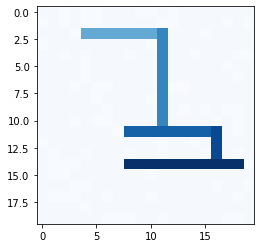

Run: 19
Team: aa768215-8a7f-4a5f-bec1-bb67f4c8f724
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X → → → → → → → → ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ↑ ↑ X ↓ ↓ ↓ ? ? X ? ? ? X X 

? ? ? ? X ↓ ↑ ↑ ? ↓ ↓ ↓ ? ? ↓ ? ? X ? ? 

? ? ? ? X → ↑ ↑ ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ? ↓ ↓ ↑ X X ↓ ? ? ↓ ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ↑ ? ? ↓ ? ? ↓ ? ? 

? ? ? ? ? ? X ↑ ← ↓ ↓ ↑ ← X ↓ X ? X X ? 

? ? ? X ? X X ↑ ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ← ↓ ↑ ↑ ← ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↓ ↑ X ? ? X ↓ ? ? ? ? 

? X ? ? X ? ? ? X ↓ ↑ X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ↑ ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



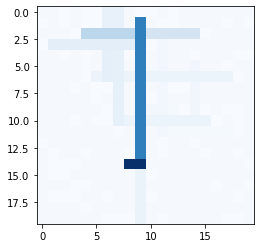

Run: 19
Team: 5b5a592d-1b19-4842-954f-750f85e297dc
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X → → → → → → → ↑ ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ↑ ↑ X ↓ ↓ ↓ ? ? X ? ? ? X X 

? ? ? ? X ↓ ↑ ↑ ? ↓ ↓ ↓ ? ? ↓ ? ? X ? ? 

? ? ? ? X → ↑ ↑ ← ↓ ← ← ← ← ↓ ← ← ← X ? 

? ? ? X ? X X ↑ ? ↓ ↓ ↓ X X ↓ ? ? ↓ ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ↓ ? ? ↓ ? ? ↓ ? ? 

? ? ? ? ? ? X ↑ ← ↓ ↓ ← ← X ↓ X ? X X ? 

? ? ? X ? X X ↑ ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ↓ X ← ↓ ↓ ↑ ← ← ← ← ← ← X ? 

X ? ? ? ? ? ↓ ? ? ↓ ↓ X ? ? X ↓ ? ? ? ? 

? X ? ? X ? ↓ ? X ↓ ↓ X ? ? ? X ? ? X ? 

? X X X → → → → G ↓ ↓ ? ? ? ? ? ? ? ? X 

? X X ? ? ? ↑ ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ← ↑ ← ← ← ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



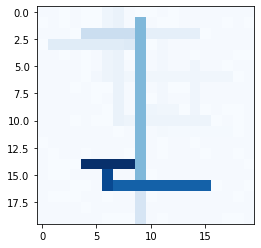

Run: 20
Team: e7f316e0-4479-4663-8fe3-000c32a240ee
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X → → → → → → → → ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ↑ ↑ X ↓ ↓ ↓ ? ? X ? ? ? X X 

? ? ? ? X ↓ ↑ ↑ ? ↓ ↓ ↓ ? ? ↓ ? ? X ? ? 

? ? ? ? X → ↑ ↑ ← ↓ ← ← ← ← ↓ ← ← ← X ? 

? ? ? X ? X X ↑ ? ↓ ↓ ↑ X X ↓ ? ? ↓ ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ↑ ? ? ↓ ? ? ↓ ? ? 

? ? ? ? ? ? X ↑ ← ↓ ↓ ↑ ← X ↓ X ? X X ? 

? ? ? X ? X X ↑ ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ↓ X ← ↓ ↓ ↑ ← ← ← ← ← ← X ? 

X ? ? ? ? ? ↓ ? ? ↓ ↓ X ? ? X ↓ ? ? ? ? 

? X ? ? X ? ↓ ? X ↓ ↓ X ? ? ? X ? ? X ? 

? X X X ↓ ? ↓ ? G ↓ ↓ ? ? ? ? ? ? ? ? X 

? X X → → → → → ↑ ← X ? ? ? ? ? ? ? ? ? 

? ? ? X X ← ↑ ← ↑ ← ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ? ↑ ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ↑ ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



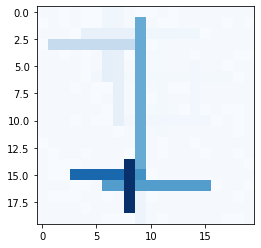

Run: 20
Team: c8a90143-7959-4d2b-be43-ba533b273619
? ? X ? X X ? ↓ ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X → ↓ → → ↓ X X ? ? ? ? X ? X 

? ? ? X S → → ↓ ← ← ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ↓ ↑ ? X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ↓ X ? ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ↓ ? ? ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ↓ ? ? ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ↓ ? ? ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ? ? X ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ ? ? ? ? ↓ X ? X ? X X ? 

? ? ? X ? X X → → → → → ↓ ← ← ← X ? X ? 

? ? ? ? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ? ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ? ? X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ? ? ? ↓ ? ? ? X ? ? X 

? X X X ? ? X ? ? ? X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ? ? ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ? ? X ↓ ? ? ? ? X X ? 



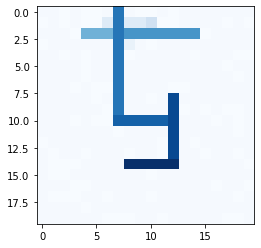

Run: 20
Team: 3fa297a0-4f2c-4049-a76b-21e2c891aac1
? ? X ? X X ↓ ? ? X X ? X ↓ ? ? ↓ ? ? ? 

X ? X ? X X ↓ ? ? ↓ ? X X ↓ ? ? ↓ X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ↓ ? ? ? 

X ? ? ? ? ? ↓ ? ? ↓ X ← ← ↑ ← ← ← ← ← ← 

? ? X ? X ? ↓ ? X ↓ ? ? ? ↑ X ? ↑ ? X X 

? ? ? ? X → → → → ↓ → → → ↑ → → ↑ X ? ? 

? ? ? ? X ? ↓ ? ↓ ↓ ? ? ? ↑ ? ? ↑ ? X ? 

? ? ? X ? X X ? ↓ ↓ ? ? X X ? ? ↑ ? ? ? 

? ? ? ? ? X ? ? ↓ ↓ X ? ? ? ? ? ↑ ? ? ? 

? ? ? ? ? ? X ? ↓ ↓ ? ? ? X ? X ↑ X X ? 

? ? ? X ? X X ? ↓ ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ↓ ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ↓ ↓ ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ↓ X ↓ ? X ? ? ? X ? ? X ? 

? X X X → → → → G ↓ ? ? ? ? ? ? ? ? ? X 

? X X ← ← ← ← ↑ ← ← X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ↑ ? ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ↑ ? ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ↑ ? ↓ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



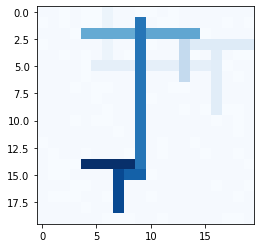

Run: 20
Team: 44e3a10e-f93e-43bf-8f5d-fb64dcbbbee0
? ? X ? X X ↓ ? ? X X ? X ↓ ? ? ↓ ? ? ? 

X ? X ? X X ↓ ? ? ↓ ? X X ↓ ? ? ↓ X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ↓ ? ? ? 

X ? ? ? ? ? ↓ ? ? ↓ X ← ← ↑ ← ← ← ← ← ← 

? ? X ? X ? ↓ ? X ↓ ? ? ? ↑ X ? ↑ ? X X 

? ? ? ? X → → → → ↓ → → → ↑ → → ↑ X ? ? 

? ? ? ? X ? ↓ ? ↓ ↓ ? ? ? ↑ ? ? ↑ ? X ? 

? ? ? X ? X X ? ↓ ↓ ? ? X X ? ? ↑ ? ? ? 

? ? ? ? ? X ? ? ↓ ↓ X ? ? ? ? ? ↑ ? ? ? 

? ? ? ? ? ? X ? ↓ ↓ ? ? ? X ? X ↑ X X ? 

? ? ? X ? X X ? ↓ ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ↓ ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ↓ ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ← ← ← ← ← ← ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



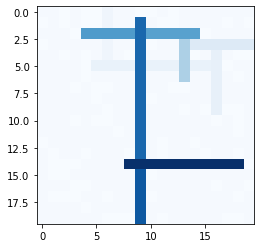

Run: 21
Team: c891eccd-45c8-4fa3-8a3b-b6e77eed21ec
? ? X ? X X ↓ ↓ ? X X ? X ↓ ? ? ↓ ? ? ? 

X ? X ? X X ↓ ↓ ← ↓ ← X X ↓ ? ? ↓ X ? X 

? ? ? X S → ↓ ↓ ← ↓ ← ↓ ↓ ← ← X ↓ ? ? ? 

X → → → → → ↓ ↓ → ↓ X ↓ ↓ ← ← ← ← ← ← ← 

? ? X ? X ↓ ↓ ↑ X ↓ ← ↓ ↓ ← X ↑ ↓ ? X X 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X ↑ → ↑ → ↓ → ↓ ↑ ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ← ↓ ← ↓ X X → ↑ ↓ ← ← ← 

? ? ? ? ? X ? ↑ ↓ ↓ X ↓ ↓ ? ↓ ↑ ↓ ? ? ? 

? ? ? ? ? ? X ↑ ↓ ↓ ↓ ↓ ↓ X ↓ X ↓ X X ? 

? ? ? X ? X X ↑ ↓ ↓ ↓ ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ↓ X ↓ ↓ ↓ ↑ ← ← ← ← ← ← X ? 

X ← ← ← ← ← ← ← ↓ ↓ ← X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ↓ ? X ↓ ↓ X ↓ ? ? X ? ? X ? 

? X X X → → → → G ↓ ↓ ? ↓ ? ? ? ? ? ? X 

? X X ← ← ← ↑ ← ← ← X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ← ↑ ← ← ↑ ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ? ? ↑ X ? ↑ ? ? ? ? ? X ? 

? ? ? ? X → → → → ↑ → → ↑ ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ↑ X ↑ ? ? ? ? X X ? 



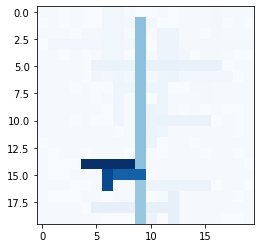

Run: 21
Team: 24b2847d-6988-4ed5-aafe-8c10ffa5fc56
? ? X ? X X ? ? ? X X ? X ↓ ↓ ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ↓ X X ↓ ↓ ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ↓ ? ? ? ? ↓ X ? ? ↓ ↓ ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ↓ X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ↓ ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ↓ ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ? ? ? ? ? ? ? ? ? X 

? X X ← ← ← ← ← ↑ ← X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ← ← ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



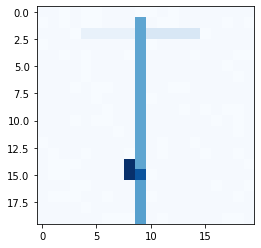

Run: 21
Team: 7ce96adc-7e15-4b1f-9ace-4302f204d6ba
? ? X ? X X ? ? ? X X ? X ↓ ↓ ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ↓ X X ↓ ↓ ? ? X ? X 

? ? ? X S → → → → → → → → ← ← X ? ? ? ? 

X ? ? ? ↓ ? ? ? ? ↓ X ? ? ↓ ↓ ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ↓ X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ↓ ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ↓ ? ? ? ↓ X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ↓ ? ? 

? ? ? ? ? X ? ? ? ↓ X → → → → → → ← ← ← 

? ? ? ? ? ? X → → ↓ → → ↓ X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ↓ ? ↓ ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ↓ ? ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ↓ X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ↓ X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ↓ → → ↓ ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ← ← ← ← ↓ ← ← ↑ ← ← ← X ? ? X 

? X X X ? ? X ← ← ↑ X ? ↑ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ↑ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ↑ ? ? ? ? X X ? 



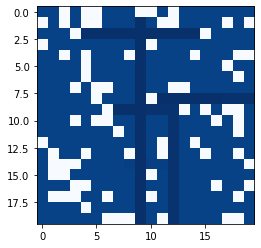

Run: 22
Team: 951077d0-2430-42d3-95ef-46ee4f92e189
? ? X ? X X ↓ ↓ ? X X ? X ↓ ↓ ? ↓ ? ? ? 

X ? X ? X X → ↓ → ↓ ← X X → → → ↓ X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ↓ ? ? ? 

X ? ? ? ↓ ? ↑ ↓ ? ↓ X ↓ ? ↑ ↓ ? ↓ ? ? ? 

? ? X ? X ? ↑ ↓ X ↓ ↓ ↓ ? ↑ X ? ↓ ? X X 

? ? ? ? X ← ↑ ↓ ↓ ↓ ← ← ← ← ← ← ↓ X ? ? 

? ? ? ? X → ↑ ↓ ↓ ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X → ↓ ↓ ← ↑ X X ? ? ↓ ↓ ? ? 

? ? ? ? ? X ? ↑ ↓ ↓ X → ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X → → ↓ → → ↓ X ? X ↓ X X ? 

? ? ? X ? X X ↑ ↓ ↓ ← ← ↓ ← ← ← X ? X ? 

? ? ? ? ? ↓ ? X → ↓ → → ↓ ← ← ← ← ← X ? 

X ? ? ? ? ↓ ? ? ↓ ↓ ↓ X ↓ ↓ X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↓ ↓ X ↓ → ↓ X ? ? X ? 

? X X X ? ↓ ? ? G ↓ ↓ ? ↓ ↑ ↓ ? ? ? ? X 

? X X → → → → → ↑ ↓ X ? ↓ ↑ ↓ ? ? ? ? ? 

? ? ? X X ↑ → → → ↓ → → ↓ ↑ ↓ ← X ? ? X 

? X X X ? ↑ X ← ← ↓ X ? ↓ ↑ ↓ ? ? ? X ? 

? ? ? ? X ↑ ← ← ← ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ? X ↑ ← ← ← ← X X ? 



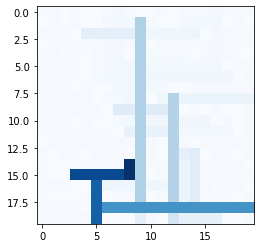

Run: 22
Team: 086042f7-2986-4631-9318-6a0334b028aa
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X → ↓ → ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → → → ↓ ← ← ← X ? ? ? ? 

X → → → → → ↑ ← ← ← X ↓ ? ? ? ↓ ? ? ? ? 

? ? X ? X ? ↑ ↓ X ↑ ? ↓ ? ? X ↓ ? ? X X 

? ? ? ? X → ↑ → → ↑ → ↓ → → → ← ← X ? ? 

? ? ? ? X ? ↑ ↓ ? ↑ ? ↓ ? ? ? ↓ ? ? X ? 

? ? ? X ? X X ↓ ← ↑ ← ↓ X X ? ↓ ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↑ X ↓ ↓ ← ← ↓ ← ← ← ← 

? ? ? ? ? ? X → → → → → ↓ X ? X ? X X ? 

? ? ? X ? X X ↓ ? ↑ ? ↑ ↓ ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↑ ? ↑ ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ↓ ? ↑ ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ↓ X ↑ ? X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ↓ G ↑ ? ? ↓ ? ? ? ? ? ? X 

? X X ? ? ? ? ↓ ↑ ↑ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X → → → ↑ ↑ ← ← ↓ ← ← ← X ? ? X 

? X X X ? ? X ↑ ↑ ↑ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ← ← ↑ ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ↓ ? ? ? ? X X ? 



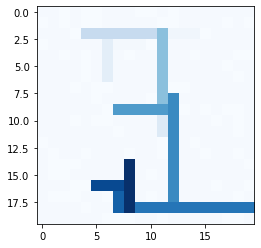

Run: 22
Team: ab19535b-1cf7-4fe5-a9e7-2058cdbb4235
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X → ↓ → ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → → → ↓ ← ← ← X ? ? ? ? 

X → → → → → ↑ ← ← ← X ↓ ? ? ? ↓ ? ? ? ? 

? ? X ? X ? ↑ ↓ X ↑ ? ↓ ? ? X ↓ ? ? X X 

? ? ? ? X → ↑ → → ↑ ← ↓ ← ← ← ← ← X ? ? 

? ? ? ? X ? ↑ ↓ ? ↑ ? ↓ ? ? ? ↓ ? ? X ? 

? ? ? X ? X X ↓ ← ↑ ← ↓ X X ? ↓ ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↑ X ↓ ↓ ← ← ↓ ← ← ← ← 

? ? ? ? ? ? X → → → → → ↓ X ? X ? X X ? 

? ? ? X ? X X ↓ ? ↑ ? ↑ ↓ ↓ ? ? X ? X ? 

? ? ? ? ? ↓ ? X ? ↑ ? ↑ ↓ ↓ ? ? ? ? X ? 

X ? ? ? ? ↓ ? ↓ ? ↑ ? X ↓ ↓ X ? ? ? ? ? 

? X ? ? X ↓ ? ↓ X ↑ ? X ↓ ↓ ? X ? ? X ? 

? X X X ? ↓ ? ↓ G ↑ ? ? ↓ ↓ ? ? ? ? ? X 

? X X ? ? ↓ ? ↓ ↑ ↑ X ? ↓ ↓ ? ? ? ? ? ? 

? ? ? X X → → → ↑ ← ← ← ← ← ← ← X ? ? X 

? X X X ? ↑ X ↓ ? ↑ X ? ↓ ↓ ? ? ? ? X ? 

? ? ? ? X ↑ ← ← ← ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ? X ↓ ↓ ? ? ? X X ? 



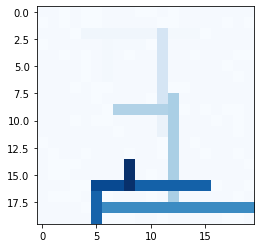

Run: 22
Team: 1f2ba8ed-3e43-4ad2-b31d-bdaec34ff024
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X → ↓ → ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → → → ↓ ← ← ← X ? ? ? ? 

X → → → → → ↑ ← ← ← X ↓ ? ? ? ↓ ? ? ? ? 

? ? X ? X ? ↑ ↓ X ↑ ? ↓ ? ? X ↓ ? ? X X 

? ? ? ? X → ↑ → → ↑ ← ↓ ← ← ← ← ← X ? ? 

? ? ? ? X ? ↑ ↓ ? ↑ ? ↓ ? ? ? ↓ ? ? X ? 

? ? ? X ? X X ↓ ← ↑ ← ↓ X X ? ↓ ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↑ X ↓ ↓ ← ← ↓ ← ← ← ← 

? ? ? ? ? ? X → → → → → ↓ X ? X ? X X ? 

? ? ? X ? X X ↓ ? ↑ ? ↑ ↓ ↓ ? ? X ↓ X ? 

? ? ? ? ? ↓ ? X ? ↑ ? ↑ ↓ ↓ ? ? ? ↓ X ? 

X ? ? ? ? ↓ ? ↓ ? ↑ ? X ↓ ↓ X ← ← ↓ ← ← 

? X ? ? X ↓ ? ↓ X ↑ ? X ↓ ↓ ? X ? ↓ X ? 

? X X X ? ↓ ? ↓ G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ↓ ? ↓ ? ↑ X ? ↓ ↓ ? ? ? ↑ ? ? 

? ? ? X X → → → → → → → → ↓ ← ← X ↑ ← X 

? X X X ? ↑ X ↓ ? ↑ X → → → → → → ↑ X ? 

? ? ? ? X ↑ ← ← ← ← ← ← ← ↑ ← ← ← ↑ ← ← 

? ? ? ? ? ↑ X X X ↑ ? X ↓ ↑ ? ? ? X X ? 



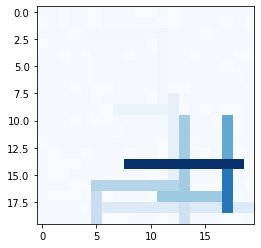

Run: 23
Team: b5713035-2f65-4eee-a176-b6e055521f86
? ? X ? X X ↓ ↓ ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X → → → ↓ ← X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ → ↓ ← ← ← X ? ? ? ? 

X → → → → → ↑ ← ← ↓ X ↓ ? ? ? ↓ ? ? ? ? 

? ? X ? X ? ↑ ↓ X ↓ ? ↓ ? ? X ↓ ? ? X X 

? ? ? ? X → ↑ → → ↓ ← ↓ ← ← ← ← ← X ? ? 

? ? ? ? X ? ↑ ↓ ↓ ↓ ? ↓ ? ? ? ↓ ? ? X ? 

? ? ? X ? X X → → ← ← ↓ X X ? ↓ ? ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↓ X ↓ ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X → → → ↓ → ↓ X ? X ? X X ? 

? ? ? X ? X X ↓ ↓ ↓ ↓ ↓ ↓ ↓ ? ? X ↓ X ? 

? ? ? ? ? ↓ ? X → → ↓ → ↓ ← ← ← ← ← X ? 

X → → → → → → → → → ↓ X ↓ ↓ X ← ↑ ↓ ← ← 

? X ? ? X ↓ ? ↑ X ↑ ↓ X ↓ → ↓ X ↑ ← X ? 

? X X X ? ↓ ? ↑ G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ↓ ? ↑ ? ↑ X ? ↓ ↑ ↓ ? ↑ ↑ ↓ ? 

? ? ? X X → → ↑ → → → → ↓ ↑ ↓ ← X ↑ ← X 

? X X X ? ↑ X ↑ ? ↑ X → ↓ ↑ ↓ → → ↑ X ? 

? ? ? ? X → → ↑ ← ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ? X ↑ ↑ ↓ ? ? X X ? 



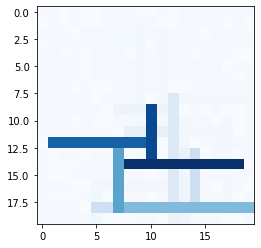

Run: 23
Team: 43581b50-9886-441e-9393-19758bfded6e
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → → → ↓ ← ← ← X ? ? ? ? 

X ← ← ← ← ← ← ← ← ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↑ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↑ ? ↓ ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↑ ? ↓ ? ? ? ? ? ? X ? 

? ? ? X ? X X ← ← ↑ ← ← X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↑ X ↓ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↑ ? ↓ ? X ? X ? X X ? 

? ? ? X ? X X ? ? ↑ ? ↓ ? ? ? ? X ? X ? 

? ? ? ? ? ↓ ? X ? ↑ ? ↓ ? ? ? ? ? ? X ? 

X ? ? ? ? ↓ ? ? ? ↑ ? X ? ? X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↑ ? X ? ? ? X ? ? X ? 

? X X X ? ← ← ← G ↑ ? ? ? ? ? ? ? ? ? X 

? X X ← ← ↑ ← ← ← ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ↑ ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ↑ X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ↑ ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ↑ X X X ↑ ? X ? ? ? ? ? X X ? 



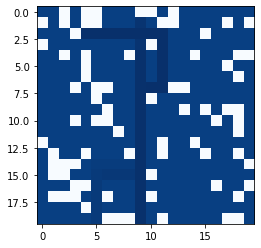

Run: 23
Team: 1944705f-0608-4362-973f-04960858edb0
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ → ↓ ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ← ← ← ← ↓ ← ↓ ← ← ← ← ← X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ↓ ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ↓ X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ↓ ? X ? X ? X X ? 

? ? ? X ? X X ← ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ↑ ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ? ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



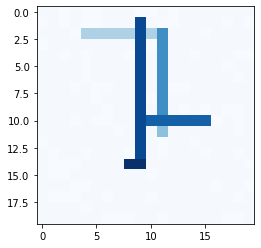

Run: 23
Team: 84c223f3-b3b8-4f1e-9de1-94543306e6b4
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → → → ↓ ← ← ← X ? ? ? ? 

X ← ← ← ← ← ← ← ← ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↑ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↑ ? ↓ ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↑ ? ↓ ? ? ? ? ? ? X ? 

? ? ? X ? X X ← ← ↑ ← ← X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↑ X ↓ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↑ ? ↓ ? X ? X ? X X ? 

? ? ? X ? X X ? ? ↑ ? ↓ ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↑ ? ↓ ? ? ? ? ? ? X ? 

X ← ← ← ← ← ← ← ← ↑ ← X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↑ ? ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



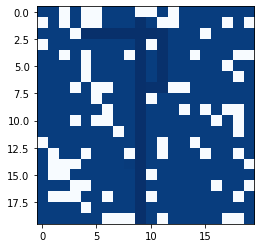

Run: 24
Team: bdda56a9-6afb-4dda-aeec-f75528eaf3f7
? ? X ? X X ? ? ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ → ↓ ← ← ← X ? ? ? ? 

X ← ← ← ← ← ← ← ← ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ↓ ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ↓ ? ? ↓ ? ? X ? ? 

? ? ? ? X ← ← ← ← ↓ ← ↓ ← ← ↓ ← ← ← X ? 

? ? ? X ? X X ← ← ↓ ← ← X X ↓ ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ↓ ↓ ? ↓ ? ? ? ? ? 

? ? ? ? ? ? X ← ← ↓ ← ← ← X ↓ X ? X X ? 

? ? ? X ? X X ← ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ↓ ↓ X → ↓ → → ↑ → ↑ ← ← ← X ? 

X → → → → ↓ → → → ↓ ← X ↑ ? X ? ? ? ? ? 

? X ? ? X ↓ ↑ ↑ X ↓ ↑ X ↑ ← ← X ? ? X ? 

? X X X ? ↓ ↑ ↑ G ← ↑ ? ↑ ? ↑ ? ? ? ? X 

? X X → → → → → → ↑ X → ↑ → ↑ ← ← ← ← ← 

? ? ? X X → ↑ ↑ → ↑ → → ↑ ← ↑ ← X ? ? X 

? X X X ? ↓ X ↑ ? ↑ X ? ↑ ? ↑ ? ? ? X ? 

? ? ? ? X ↓ ? ↑ ? ↑ ? ? ↑ ? ↑ ? ? ? ? ? 

? ? ? ? ? ↓ X X X ↑ ← X ↑ ? ↑ ? ? X X ? 



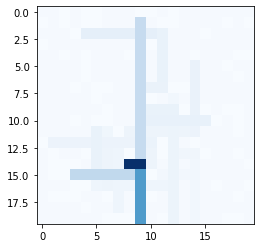

Run: 24
Team: c2ab6e44-28d2-4be9-bf89-93b8a6911339
? ? X ? X X ↓ ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ → ↓ ↓ ← ← X ? ? ? ? 

X → → → → → → → → ↓ X ↓ ↓ ? ? ? ? ? ? ? 

? ? X ? X ? ↑ ↑ X ↓ ? ↓ ↓ ? X ? ? ? X X 

? ? ? ? X ← ↑ ↑ ← ↓ ← ↓ ← ← ← ← ← X ? ? 

? ? ? ? X ← ↑ ← ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ← ↓ ← ↑ X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ↑ ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↑ ? ↓ ? ↑ ↓ X ? X ? X X ? 

? ? ? X ? X X → → → → → ↓ ← ← ← X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ↑ ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ↓ ? ? ? X ? ? X 

? X X X ? ? X ? ? ↓ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↓ ? ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ↓ ? ? ? ? X X ? 



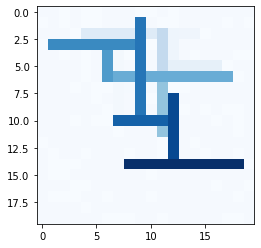

Run: 24
Team: b34b85c2-6df2-4f20-998d-78872cf6365a
? ? X ? X X ↓ ↓ ↓ X X ? X ↓ ? ? ↓ ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ← X X ↓ ← ← ← X ? X 

? ? ? X S → → → → ↓ ← ↓ ← ← ← X ↑ ? ? ? 

X → → → → → → → → ↓ X ↓ ↓ ↓ ? ? ↑ ? ? ? 

? ? X ? X ↓ ↑ ↑ X ↓ ↓ ↓ ↓ ↓ X ? ↑ ? X X 

? ? ? ? X ↓ ↑ ↑ ↓ ↓ → ↓ ← ↓ ← ← ← X ? ? 

? ? ? ? X → → → ↓ ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ↓ ↓ ← ↑ X X ? ? ↑ ? ? ? 

? ? ? ? ? X ? ↑ ↓ ↓ X ↑ ↓ ? ? ? ↑ ? ? ? 

? ? ? ? ? ? X ↑ ↓ ↓ ← ← ← X ? X ↑ X X ? 

? ? ? X ? X X → → ↓ ↑ ← ← ← ← ← X ? X ? 

? ? ? ? ? ↓ ? X ↓ ↓ ↑ ↑ ↓ ↓ ← ← ← ← X ? 

X → → → → → → → → ↓ ↑ X ↓ ↓ X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↓ ↑ X ↓ ↓ ? X ? ? X ? 

? X X X ? ↓ ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ↓ ? ? ? ↑ X ? ↓ ↓ ? ? ? ? ? ? 

? ? ? X X ← ← ← ← ↑ ← ← ← ← ← ← X ? ? X 

? X X X ? ↓ X ? ? ↑ X → → ↑ ← ← ← ← X ? 

? ? ? ? X ↓ ? ? ? ↑ ? ? ↓ ↑ ? ? ? ? ? ? 

? ? ? ? ? ↓ X X X ↑ ? X ↓ ↑ ? ? ? X X ? 



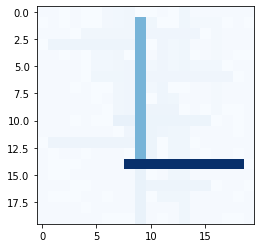

Run: 24
Team: 24c9ff73-43eb-4e3a-99bf-97a4a94a0b14
? ? X ? X X ↓ ↓ ↓ X X ? X ↓ ? ? ↓ ? ? ? 

X ? X ? X X → ↓ ↓ ↓ ← X X ↓ ← ← ← X ? X 

? ? ? X S → → ↓ ↓ ↓ ← ← ← ← ← X ↑ ? ? ? 

X → → → → → → ↓ → ↓ X ↓ ↓ ↓ ? ? ↑ ? ? ? 

? ? X ? X ↓ ↑ ↓ X ↓ ↓ ↓ ↓ ↓ X ? ↑ ? X X 

? ? ? ? X → ↑ ↓ → ↓ → ↓ ↓ ↓ ← ← ← X ? ? 

? ? ? ? X → ↑ ↓ ← ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ← ↓ ← ↑ X X ? ? ↑ ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↓ X ↑ ↓ ? ? ? ↑ ? ? ? 

? ? ? ? ? ? X ↓ ↓ ↓ ← ← ↓ X ? X ↑ X X ? 

? ? ? X ? X X → → ↓ → → ↓ ↓ ← ← X ? X ? 

? ? ? ? ? ↓ ? X → → → → → ↓ ← ← ← ← X ? 

X → → → → → → → → ↓ ↑ X ↓ ↓ X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↓ ↑ X ↓ ↓ ? X ? ? X ? 

? X X X ? ↓ ? ? G ↓ ↑ ? ↓ ↓ ? ? ? ? ? X 

? X X ? ? ↓ ? ? ↑ ↓ X ? ↓ ↓ ? ? ? ? ? ? 

? ? ? X X → → → ↑ ← ← ← ← ← ← ← X ? ? X 

? X X X ? ↓ X ? ↑ ↑ X → → ↑ ← ← ← ← X ? 

? ? ? ? X ↓ ? ? ↑ ↑ ? ? ↓ ↑ ? ? ? ? ? ? 

? ? ? ? ? ↓ X X X ↑ ? X ↓ ↑ ? ? ? X X ? 



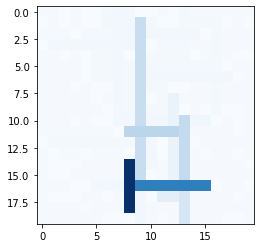

Run: 24
Team: 52d56cee-e109-4a33-8f8b-13734a903360
? ? X ? X X ↓ ↓ ↓ X X ? X ↓ ? ? ↓ ? ? ? 

X ? X ? X X → ↓ → ↓ ← X X ↓ ← ← ← X ? X 

? ? ? X S ↓ → → → ↓ → ↓ ← ← ← X ↑ ? ? ? 

X → → → → → → → → ↓ X ↓ ↓ ↑ ? ? ↑ ? ? ? 

? ? X ? X ↓ ↑ ↑ X → → ↓ ↓ ↑ X ? ↑ ? X X 

? ? ? ? X → → → → → → ↓ → ← ← ← ← X ? ? 

? ? ? ? X → → ↑ ← ↓ ← ↓ ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ← ← ← ↓ X X ↓ ? ↑ ? ? ? 

? ? ? ? ? X ? ↑ ↓ ↓ X ↓ ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X ↑ ↓ ↓ ← ↓ ↓ X ↑ X ↑ X X ? 

? ? ? X ? X X → → → → → ↓ ← ← ← X ? X ? 

? ? ? ? ? ↓ ? X → → → → ↓ → ↑ ← ← ← X ? 

X → → → → → → → → ↑ ↑ X ↓ ↑ X ? ? ? ? ? 

? X ? ? X ↓ ? ? X ↑ ↑ X ↓ ↑ ↓ X ? ? X ? 

? X X X ? ↓ ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ↓ ? ? ? ↑ X ? ↓ ↑ ↑ ? ? ? ? ? 

? ? ? X X ← ← ← ← ↑ ← ← ↓ ↑ ↑ ← X ? ? X 

? X X X ? ↓ X ? ? ↑ X → ↓ ↑ ↑ ← ← ← X ? 

? ? ? ? X ↓ ? ? ? ↑ ? ? ↓ ↑ ↑ ? ? ? ? ? 

? ? ? ? ? ↓ X X X ↑ ? X → → ↑ ← ← X X ? 



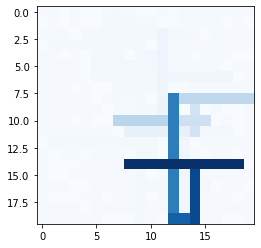

Run: 25
Team: a9325866-e4ed-49ff-a517-0f5472dee27b
? ? X ? X X ↓ ↓ ↓ X X ? X ↓ ? ? ↓ ? ? ? 

X ? X ? X X → → → ↓ ← X X ↓ ← ← ← X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ↑ ? ? ? 

X → → → → → → ↓ → ↓ X ↓ ↓ ↑ ? ? ↑ ? ? ? 

? ? X ? X ↓ ↑ ↓ X ↓ ↓ ↓ ↓ ↑ X ? ↑ ? X X 

? ? ? ? X ↓ ↑ ↓ ↓ ↓ → ↓ ↓ ↑ ← ← ← X ? ? 

? ? ? ? X → → ↓ → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ↓ ← ← X X ? ? ↑ ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↓ X ↑ ↓ ? ? ? ↑ ? ? ? 

? ? ? ? ? ? X ↓ ↓ ↓ ← ← ↓ X ? X ↑ X X ? 

? ? ? X ? X X → → → → → ↓ ↓ ← ← X ? X ? 

? ? ? ? ? ↓ ? X → → → → → ↓ ← ← ← ← X ? 

X → → → → → → → → ↑ ↑ X ↓ ↓ X ? ↓ ? ? ? 

? X ? ? X ↓ ? ? X ↑ ↑ X ↓ ↓ ? X ↓ ? X ? 

? X X X ? ↓ ? ? G ↑ ↑ ? ↓ ↓ ? ↓ ↓ ? ? X 

? X X ← ← ↓ ← ← ↑ ↑ X ← ↓ ↓ ← ↓ ← ← ← ← 

? ? ? X X → → → ↑ ← ← ← ← ← ← ← X ? ? X 

? X X X ? ↓ X ? ↑ ↑ X → ↑ ↑ ← ↓ ← ← X ? 

? ? ? ? X ↓ ? ? ↑ ↑ ? ? ↑ ↑ ? ↓ ? ? ? ? 

? ? ? ? ? ↓ X X X ↑ ? X ↑ ↑ ← ← ← X X ? 



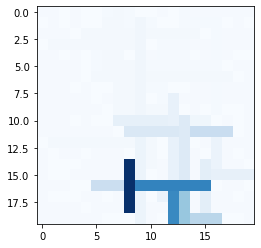

Run: 25
Team: f54366c2-6bdb-4e6a-beeb-58400f2cddd6
? ? X ? X X ? ? ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → → → → ↓ → → → ↓ ← X ? ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ? ? ↓ ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ← ← ← ← X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ↓ ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ↓ ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ? ? ? X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ← X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ? ? ? ? ? ? ? ? ? X 

? X X ← ← ← ← ← ↑ ← X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



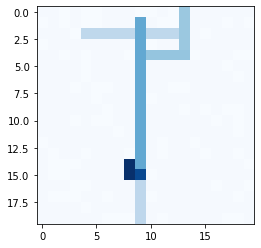

Run: 25
Team: 4f766e96-ebbe-4513-ab44-13065f82940e
? ? X ? X X ↓ ↓ ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ? ↓ ↓ X X ↓ ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ↓ ↓ ? ↓ X ↓ ? ↓ ? ? ? ? ? ? 

? ? X ? X ← ↓ ↓ X ↓ ← ← ← ← X ? ? ? X X 

? ? ? ? X ← ↓ ↓ ← ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → ↓ → ↓ ↑ ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ← ↓ ↑ ← X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↓ X ↑ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ → ↓ ↓ ↑ ← X ? X ? X X ? 

? ? ? X ? X X → → ↓ ↓ ↑ ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ← ↓ ← ← ← ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↓ ↓ X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ← X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ↓ ? ? ? ? ? ? ? ? X 

? X X ← ← ← ← ← ↑ ← X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ↑ ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ↑ ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ← ← ← ↑ ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



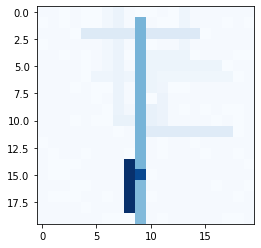

Run: 25
Team: a9f67a2f-997a-418b-9335-5df91d34dea8
? ? X ? X X ↓ ↓ ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ? ↓ ↓ X X ↓ ? ? ? X ? X 

? ? ? X S → → → → ↓ → → → ← ← X ? ? ? ? 

X ? ? ? ? ? ↓ ↓ ? ↓ X ↓ ? ↓ ? ? ? ? ? ? 

? ? X ? X ← ↓ ↓ X ↓ ← ← ← ← X ? ? ? X X 

? ? ? ? X ← ↓ ↓ ← ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↑ ↑ ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ← ↑ ← ← X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↑ X ↑ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ → ↑ ↓ ↑ ← X ? X ? X X ? 

? ? ? X ? X X → → ↑ ↓ ↑ ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ← ↑ ← ← ← ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↑ ↓ X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ← X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ← ← ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ← ← ← ← ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



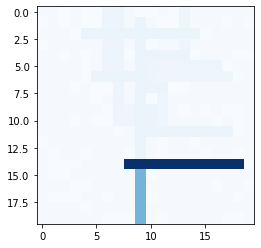

Run: 25
Team: 5116e372-f8f8-4e2a-afdc-eaabd5885239
? ? X ? X X ↓ ↓ ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ? ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → ↓ → → ↓ → → → ↓ ← X ? ? ? ? 

X ? ? ? ↓ ? ↓ ↑ ? ↓ X ↓ ? ↓ ? ? ? ? ? ? 

? ? X ? X ← ↓ ↑ X ↓ ← ← ← ← X ? ? ? X X 

? ? ? ? X ← ↓ ↑ ↓ ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↓ ↑ ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ↓ ↓ ↑ ← X X ? ? ? ? ? ? 

? ? ? ? ? X → → → ↓ X ↑ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↑ → ↓ ↓ ↑ ← X ? X ? X X ? 

? ? ? X ? X X → → ↓ → ↑ ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ← ↓ ← ← ← ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ↓ ↓ ↑ X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ← X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↓ ↑ ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ↑ ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ← ← ← ↑ ← ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ? ↑ ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ← ← ← ↑ ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



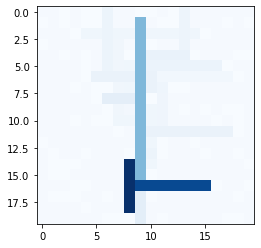

Run: 26
Team: e87ed0c3-3f07-46a1-b14d-88684dae4a04
? ? X ? X X ↓ ↓ ? X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ? ↓ ↓ X X ↓ ? ? ? X ? X 

? ? ? X S → → → → ↓ → → → ↓ ← X ? ? ? ? 

X ? ? ? ? ? ↓ ↓ ? ↓ X ↓ ? ↓ ? ? ? ? ? ? 

? ? X ? X ← ↓ ↓ X ↓ ← ← ← ← X ? ? ? X X 

? ? ? ? X ← ↓ ↓ ← ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↓ ↑ ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ← ↓ ↑ ← X X ? ? ? ? ? ? 

? ? ? ? ? X ← ↓ ← ↓ X ↑ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↓ → ↓ ↓ ↑ ← X ? X ? X X ? 

? ? ? X ? X X → → ↓ → ↑ ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X ← ↓ ← ← ← ← ← ← ← ← X ? 

X ? ? ? ? ? ? ↓ ? ↓ ↓ X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ↓ X ↓ ← X ? ? ? X ? ? X ? 

? X X X ↓ ? ? ↓ G ↓ ↓ ? ? ? ? ? ? ? ? X 

? X X → → → → → ↑ ← X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ↑ ? ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ↑ ← ← X ? ? ? ? ? ? ? X ? 

? ? ? ? X ← ← ↑ ← ↑ ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



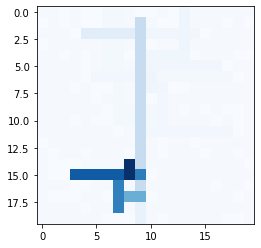

Run: 26
Team: f1aed7ae-5d3c-473e-b053-b21d720a7854
? ? X ? X X ↓ ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S ↓ ↓ ↓ ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ↓ ↓ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ↓ ↓ X ↓ ↓ ? ? ? X ? ? ? X X 

? ? ? ? X → → → → ↓ ↓ ← ← ← ← ← ← X ? ? 

? ? ? ? X → → ↓ → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↓ ? ↓ ↓ ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ↑ ← ↓ ← ← ← X ? X ? X X ? 

? ? ? X ? X X ↑ ? ↓ ? ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ? ? ? ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ? X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ? ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



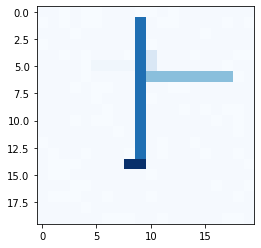

Run: 26
Team: fbfd4d07-0a68-4edb-b0a1-a37355229c6b
? ? X ? X X ↓ ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S ↓ ↓ ← ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ↓ ↑ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ↓ ↑ X ↓ ↓ ? ? ? X ? ? ? X X 

? ? ? ? X ↓ ↓ ← ← ↓ ↓ ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ? ↓ ↓ ? X X ↓ ? ? ? ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ? ↓ ? ↓ ? ? ? ? ? 

? ? ? ? ? ? X ↑ ← ↓ ← ← ← X ↓ X ? X X ? 

? ? ? X ? X X ↑ ? ↓ ? ? ↓ ? ↓ ? X ↓ X ? 

? ? ? ? ? ? ? X → → → → → → → → → ↓ X ? 

X ? ? ? ? ? ? ↓ ? ↓ ? X ↑ ? X ? ? ↓ ? ? 

? X ? ? X ? ? ↓ X ↓ ? X ↑ ? ? X ? ↓ X ? 

? X X X ? ? ? → G ↓ ? ? ↑ ? ? ↓ ? ↓ ? X 

? X X ? ? ? ? ↑ ? ↓ X ? ↑ ? ? ↓ ? ↓ ? ? 

? ? ? X X → → ↑ → → → → → → → ↓ X ↓ ? X 

? X X X ? ? X ↑ ? ↑ X ? ↑ ? ? ↓ ? ↓ X ? 

? ? ? ? X → → ↑ ← ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ↑ ? ? ↓ ? X X ? 



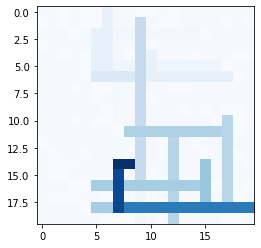

Run: 26
Team: 9cac4a60-b61e-4cfe-9739-46c29cc47f16
? ? X ? X X ↓ ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S ↓ ↓ ← ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ↓ ↑ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ↓ ↑ X ↓ ↓ ? ? ? X ? ? ? X X 

? ? ? ? X → → → → ↓ ↓ ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ? ↓ ↓ ? X X ↓ ? ? ? ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ? ↓ ? ↓ ? ? ? ? ? 

? ? ? ? ? ? X ↑ ← ↓ ← ← ↓ X ↓ X ? X X ? 

? ? ? X ? X X ↑ ? ↓ ? ? ↓ ? ↓ ? X ↓ X ? 

? ? ? ? ? ? ? X → → → → ↓ ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ↓ ? X ? ? ↑ ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ? ↓ X ? ↑ X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X → → → ↑ ↓ ← ↑ ← ← 

? ? ? X X → → → → → → → ↑ → ↑ ↓ X ↑ ← X 

? X X X ? ? X ? ? ↑ X ? ↑ ? ↑ ↓ ? ↑ X ? 

? ? ? ? X ← ← ← ← ↑ ← ← ↑ ← ↑ ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ↑ ? ↑ ↓ ? X X ? 



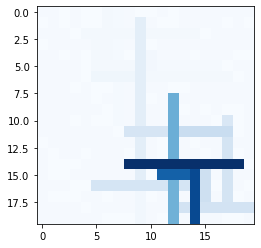

Run: 26
Team: 364dc367-8653-4785-ab9b-15eef7fbd7eb
? ? X ? X X ↓ ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S ↓ ← ← ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ↓ ↑ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ↓ ↑ X ↓ ↓ ? ? ? X ? ? ? X X 

? ? ? ? X ↓ ↓ → → ↓ ↓ ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ? ↓ ↓ ? X X ↓ ? ? ? ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ? ↓ ? ↓ ? ? ? ? ? 

? ? ? ? ? ? X ↑ ← ↓ ← ← ↓ X ↓ X ? X X ? 

? ? ? X ? X X ↑ ? ↓ ? ? ↓ ? ↓ ? X ↓ X ? 

? ? ? ? ? ? ? X → → → → ↓ ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ↓ ? X ? ? ↓ ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ? ↓ X ? ↓ X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X → → → ↑ ↓ ← ↓ ← ← 

? ? ? X X → → → → → → → ↑ → ↑ ↓ X ↑ ← X 

? X X X ? ? X ? ? ↑ X ? ↑ ? ↑ ↓ ? ↑ X ? 

? ? ? ? X ← ← ← ← ↑ ← ← ↑ ← ↑ ← ← ↑ ← ← 

? ? ? ? ? ? X X X ↑ ? X ↑ ? ↑ ↓ ? X X ? 



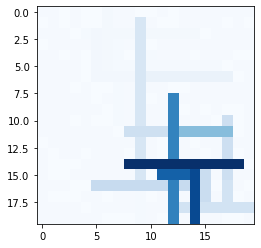

Run: 27
Team: f76bceb3-deb6-4082-ab6b-163be420a801
? ? X ? X X ↓ ↓ ? X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ? ↓ ? X X ? ? ? ? X ? X 

? ? ? X S ↓ ← ← ← ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ↓ ↑ ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ↓ ↓ ↑ X ↓ ↓ ? ? ? X ? ? ? X X 

? ? ? ? X → ← ← ← ↓ ← ← ← ← ← ← ← X ? ? 

? ? ? ? X → → → → ↓ ← ← ← ← ← ← ← ← X ? 

? ? ? X ? X X ↑ ? ↓ ↓ ? X X ↓ ? ? ? ? ? 

? ? ? ? ? X ? ↑ ? ↓ X ? ↓ ? ↓ ? ? ? ? ? 

? ? ? ? ? ? X ↑ ← ↓ ← ← ↓ X ↓ X ? X X ? 

? ? ? X ? X X ↑ ? ↓ ? ? ↓ ↓ ↓ ? X ↓ X ? 

? ? ? ? ? ? ? X → ↓ → → ↓ ↓ ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ↓ ↓ X ? ? ↑ ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ↓ ? X ? ↑ X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X → → ↓ ← ↑ ← ↑ ← ← 

? ? ? X X → → → → → → → → → → ↑ X ↑ ← X 

? X X X ? ? X ? ? ↑ X → → → → ↑ ← ↑ X ? 

? ? ? ? X ← ← ← ← ↑ ← ← ↑ ← ← ↑ ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ↑ ↓ ? ↑ ? X X ? 



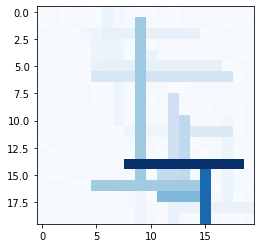

Run: 27
Team: 2746cb99-da76-4e6b-a855-ffcf7ab473b2
? ↓ X ? X X ↓ ? ? X X ? X ? ? ? ? ? ? ? 

X ↓ X ? X X ↓ ? ? ? ? X X ? ? ? ? X ? X 

? ↓ ? X S → ↓ ← ← ← ← ← ← ← ← X ? ? ? ? 

X ↓ ← ← ← ← ← ← ← ← X ? ? ? ? ? ? ? ? ? 

? ↓ X ? X ? ↓ ? X ? ? ? ? ? X ? ? ? X X 

? ↓ ? ? X ? ↓ ? ? ? ? ? ? ? ? ? ? X ? ? 

? ↓ ? ? X ? ↓ ? ? ? ? ? ? ? ? ? ? ? X ? 

? ↓ ? X ? X X ? ? ? ? ? X X ? ? ? ? ? ? 

? ↓ ? ? ? X ? ? ? ? X ? ? ? ? ? ? ? ? ? 

? ↓ ? ? ? ? X ? ? ? ? ? ? X ? X ? X X ? 

? ↓ ? X ? X X ? ? ? ? ? ? ? ? ? X ? X ? 

← ↓ ← ← ← ↓ ← X ? ? ? ? ? ? ? ? ? ? X ? 

X → → → → ↓ ↑ ← ← ← ← X ? ? X ? ? ? ? ? 

? X ? ? X ↓ ↑ ? X ? ? X ? ? ? X ? ? X ? 

? X X X ? ↓ ↑ ? G ? ? ? ? ? ? ? ? ? ? X 

? X X ? ? ↓ ↑ ? ↑ ? X ? ? ? ? ? ? ? ? ? 

? ? ? X X → → → ↑ ← ← ← ← ← ← ← X ? ? X 

? X X X ? ↓ X ? ↑ ? X ? ? ? ? ? ? ? X ? 

? ? ? ? X ↓ ? ? ↑ ? ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ↓ X X X ? ? X ? ? ? ? ? X X ? 



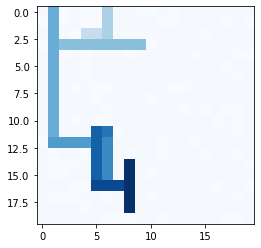

Run: 27
Team: 8ff0a8a9-e2b5-4a01-b400-4ea46d1314ad
? ? X ? X X ? ? ↓ X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ? ? ↓ ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ? ? ↓ ↓ X ↓ ? ↑ ? ? ? ? ? ? 

? ? X ? X ↓ ? ? X ↓ ? ↓ ? ↑ X ? ? ? X X 

? ? ? ? X ← ← ← ← ↓ ← ↓ ← ↑ ← ← ← X ? ? 

? ? ? ? X → → → → ↓ → → → ↑ ← ← ← ← X ? 

? ? ? X ? X X ? ? ↓ ? ↓ X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ↓ ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X → → ↓ ↓ ↓ ← X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ↓ ↓ ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ↓ ↓ ↓ ? ? ? ? ? ? X ? 

X ← ← ← ← ← ← ← ← ↓ ↓ X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ← X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ← ← ← ← ↑ ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ? ? ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



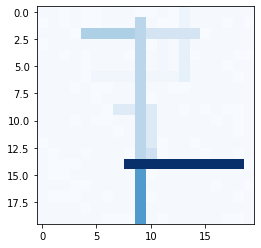

Run: 27
Team: c836f4e4-5c32-4691-a929-8dcff2cc2e61
? ? X ? X X ? ↓ ↓ X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ? ↓ ↓ ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → → ↓ → ↓ ← ↓ ← ← ← X ? ? ? ? 

X ? ? ? ? ↓ ? ↓ ↓ ↓ X ↓ ↓ ↑ ? ? ? ? ? ? 

? ? X ? X ↓ ? ↓ X ↓ → ↓ → ↑ X ? ? ? X X 

? ? ? ? X ← ← ↓ ↓ ↓ ↓ ↓ ← ↑ ← ← ← X ? ? 

? ? ? ? X → → ↓ → ↓ → ↓ → ↑ ← ← ← ← X ? 

? ? ? X ? X X ↓ ← ← ← ← X X ? ? ? ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↓ X ↑ ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X → → → → → ↓ X ? X ? X X ? 

? ? ? X ? X X ← ↓ ↑ ↓ ↑ ↓ ← ← ← X ? X ? 

? ? ? ? ? ? ? X → ↑ ↓ ↑ ↓ ← ← ← ← ← X ? 

X ← ← ← ← ← ← ← ↑ ↑ ↓ X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ← X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↑ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ← ← ← ← ↑ ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ? ? ↑ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ↓ ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ↓ ? ? ? ? X X ? 



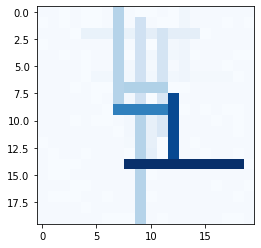

Run: 27
Team: 751715d6-e127-4d3a-8f5e-b257d42a9256
? ? X ? X X ↓ ↓ ↓ X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ← ← ← ← ↓ ↑ ↓ ← ↓ X ↓ ↓ ↑ ? ? ? ? ? ? 

? ? X ? X ↓ ↑ ↓ X ↓ → → → ↑ X ? ? ? X X 

? ? ? ? X → ↑ ↓ ↓ ↓ ↓ → → ↑ ← ← ← X ? ? 

? ? ? ? X → ↑ ↓ ↓ ↓ → → → ↑ ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ↓ ← ↑ X X ↓ ? ? ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↓ X ↑ ↓ ? ↓ ? ? ? ? ? 

? ? ? ? ? ? X → → → ↓ ← ← X ↓ X ? X X ? 

? ? ? X ? X X ↑ ← ↓ ↓ ← ↓ ↓ ← ← X ? X ? 

? ? ? ? ? ? ? X → ↓ ↓ → → ↓ ← ← ← ← X ? 

X ← ← ← ← ← ← ← ↑ ↓ ↓ X ↓ ↓ X ↓ ? ? ? ? 

? X ? ? X ? ? ? X ↓ ← X ↓ ↓ ? X ? ? X ? 

? X X X ? ? ? ? G ← ↑ ? ↓ ↓ ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↑ X → → ↓ ← ← ← ← ← ← 

? ? ? X X ← ← ← ← ↑ ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ? ? ↑ X ? ↓ ↑ ? ? ? ? X ? 

? ? ? ? X → → → → ↑ ← ← ← ↑ ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ↑ ↑ ? ? ? X X ? 



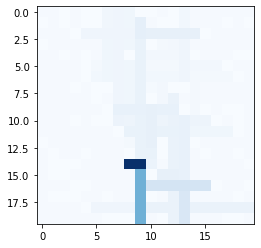

Run: 28
Team: 83ecdec4-8c8b-47f3-8b5c-2f2daab69a2c
? ? X ? X X ↓ ↓ ↓ X X ? X ↓ ? ? ? ? ? ? 

X ? X ? X X ↓ ↓ ↓ ↓ ? X X ↓ ? ? ? X ? X 

? ? ? X S → → ↓ → ↓ ← ← ← ↓ ← X ? ? ? ? 

X ← ← ← ← ↓ ↑ ↓ ↑ ↓ X ↓ ↓ ↓ ? ? ? ? ? ? 

? ? X ? X ↓ ↑ ↓ X ↓ → ↓ → ↓ X ? ? ? X X 

? ? ? ? X → → ↓ ↓ ↓ → ↓ → ↓ ← ← ← X ? ? 

? ? ? ? X → → ↓ ↓ ↓ → → → ↑ ← ← ← ← X ? 

? ? ? X ? X X ↓ ↓ ↓ ← ← X X ↓ ? ? ? ? ? 

? ? ? ? ? X ? ↓ ↓ ↓ X ↑ ↓ ? ↓ ? ? ? ? ? 

? ? ? ? ? ? X → → → → → ↓ X ↓ X ? X X ? 

? ? ? X ? X X ↑ ← ↓ ↓ ← ↓ ↓ ← ← X ? X ? 

? ? ? ? ? ? ? X → → → → ↓ ↓ ← ← ← ← X ? 

X ← ← ← ← ← ← ← ↑ ↓ ↓ X ↓ ↓ X ↓ ? ? ? ? 

? X ? ? X ? ? ? X ↓ ← X ↓ ↓ ↓ X ? ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ? ? ? ? ? ? ↓ X → ↓ ↓ ↑ ← ← ← ← ← 

? ? ? X X ← ← ← ← ↓ ← ← ↑ ↓ ↑ ← X ? ? X 

? X X X ? ? X ? ? ↓ X ? ↑ ↓ ↑ ? ↓ ? X ? 

? ? ? ? X → → → → → → → → → ↑ → ↓ ← ← ← 

? ? ? ? ? ? X X X → ↑ X ↑ ↑ ↑ ← ← X X ? 



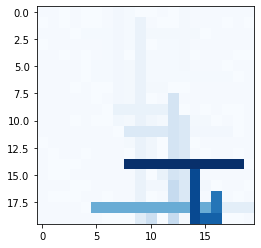

Run: 28
Team: ec513932-e489-4fe8-8c54-8f45ba979935
? ? X ? X X ? ? ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ↓ ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ← ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ↓ ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ↓ ? ? X ? X ? X X ? 

? ? ? X ? X X ? ? ↓ ↓ ? ? ? ? ? X ? X ? 

? ? ? ? ? ? ? X → → ↓ ← ← ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↓ ↓ X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↓ ↓ X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G → → ? ? ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ? ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ? ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↓ ? X ? ? ? ? ? X X ? 



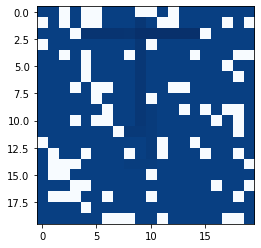

Run: 28
Team: 1546b95d-223a-400b-afd0-3ebd9ed52b7f
? ? X ? X X ? ? ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ↓ ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ↓ ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ? ? ↓ ↓ ? ? X ? X ? X X ? 

? ? ? X ? X X ← ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X → → ↑ ← ← ← ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ↑ ↑ X ? ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ↑ X ? ? ? X ? ? X ? 

? X X X ? ? ? ? G ↑ ↑ ? ? ? ? ? ? ? ? X 

? X X ← ← ← ← ← ↓ ↑ X ? ? ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ↓ ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ← ↓ ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



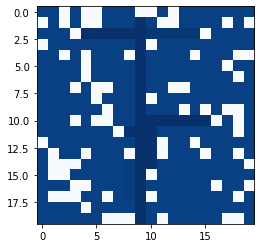

Run: 28
Team: e5daad79-da9e-4c02-9b30-fcd9b4baf86e
? ? X ? X X ? ? ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ↓ ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ↓ ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ← ← ↓ ← ← ← X ? X ? X X ? 

? ? ? X ? X X ← ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X → → → → → → → → ↓ ← X ? 

X → → → → → → → → ↑ ↑ X ? ? X ? ↓ ? ? ? 

? X ? ? X ? ? ? X ↑ ↑ X ? ? ? X ↓ ? X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ← ← ← ← ← ← ↑ X ? ? ? ? ? ↓ ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ← ← ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



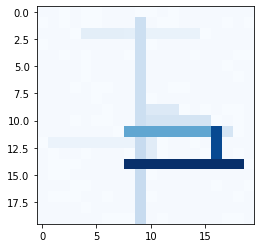

Run: 28
Team: 5b830cf7-371c-4d59-aca6-0d6e14c9eb5b
? ? X ? X X ? ? ↓ X X ? X ? ? ? ? ? ? ? 

X ? X ? X X ? ? ↓ ↓ ? X X ? ? ? ? X ? X 

? ? ? X S → → → → ↓ ← ← ← ← ← X ? ? ? ? 

X ? ? ? ? ? ? ? ↓ ↓ X ? ? ? ? ? ? ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X ? ? ? X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? X ? ? 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ? ? ? X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ? ? ? ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X ← ← ↓ ↓ ← ← X ? X ? X X ? 

? ? ? X ? X X ← ← ↓ ← ← ← ← ← ← X ? X ? 

? ? ? ? ? ? ? X → → → → → → → → ↓ ← X ? 

X → → → → → → → → ↑ ↑ X ? ? X ? ↓ ? ? ? 

? X ? ? X ? ? ? X ↑ ↑ X ? ? ? X ↓ ← X ? 

? X X X ? ? ? ? G ← ← ← ← ← ← ← ← ← ← X 

? X X ← ← ← ← ← ← ↑ X ? ? ? ? ? ↑ ? ? ? 

? ? ? X X ? ? ? ? ↑ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ← ← ↑ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ? ? ? ? ↑ ? ? ? ? ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



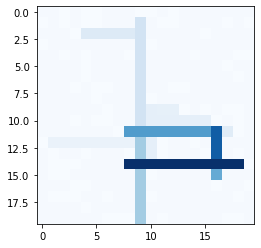

In [7]:
# importing libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

for run in range(runs):
    for team in run_winners[run]['winners']:

        print(f'Run: {run}')
        print(f'Team: {team.id}')
        
        region_action_scores = []
        for learner in team.learners:
            if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
                region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
            else:
                region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

        sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)
        # print(sorted_region_action_scores)
        # for record in sorted_region_action_scores:
        #     print(record)
        action_states = []
        for record in sorted_region_action_scores:
            action = ''
            if record['action'] == 0:
                action = '\u2191'
            elif record['action'] == 1:
                action = '\u2193'
            elif record['action'] == 2:
                action = '\u2192'
            elif record['action'] == 3:
                action = '\u2190'

            for i in range(record['region'][3] - record['region'][2]+1):
                state = [0, 0]
                state[record['region'][0]] = record['region'][1]
                state[not record['region'][0]] = record['region'][2] + i
                for cumulative in superimpose:
                    if cumulative['state'] == (state[0], state[1]):
                        if action == '\u2191':
                            cumulative['action_count'][0] += record['q']
                        elif action == '\u2193':
                            cumulative['action_count'][1] += record['q']
                        elif action == '\u2192':
                            cumulative['action_count'][2] += record['q']
                        elif action == '\u2190':
                            cumulative['action_count'][3] += record['q']
                
                # ensure we do not enter duplicate states
                found = 0
                for pair in action_states:
                    if pair['state'] == (state[0], state[1]):
                        found = 1

                if found == 0:
                    action_states.append({'state': (state[0], state[1]), 'action': action, 'q': record['q'] })

        # add in the rest of the states, either they are not visited, or illegal
        for n in reversed(range(env.rows)):
            for m in range(env.cols):
                action = ''
                found = 0
                for record in action_states:
                    if record['state'] == (n, m):
                        found = 1
                        action = record['action']
        #                 action = float(round(record['q'], 0))
                if found == 0:
                    if not env.check_legal((n, m)):
                        action = 'X'
                    else:
                        action = '?'
                if (n, m) == env.start_state:
                    action = 'S'
                if (n, m) == env.win_state:
                    action = 'G'
                print(f'{action} ', end='')
            print('\n')

        q_map = np.zeros((env.rows, env.cols))

        # add in the rest of the states, either they are not visited, or illegal
        for n in range(env.rows):
            for m in range(env.cols):
                action = ''
                found = 0
                for record in action_states:
                    if record['state'] == (n, m):
                        found = 1
                        action = record['q']
                if found == 0:
                    if not env.check_legal((n, m)):
                        action = -1
                    else:
                        action = 0
                q_map[(env.rows-1)-n][m] = action

        plt.imshow(q_map, cmap='Blues', interpolation='nearest')
        if (load == False):
            plt.savefig(f'qtpg/qmaps/{plotName}/{team.id}_qmap.png')
        plt.show()

#         x = []
#         y = []
#         for i in range(env.cols):
#             x.append(i)
#             y.append(i)

#         Y, X = np.meshgrid(x, y)

#         fig = plt.figure()

#         # syntax for 3-D plotting
#         ax = plt.axes(projection ='3d')

#         # syntax for plotting
#         ax.plot_surface(X, Y, q_map, cmap ='viridis', edgecolor ='green')
#         ax.set_title(f'Surface plot for {envName}')
#         plt.show()

In [8]:
actionables = []

# add in the rest of the states, either they are not visited, or illegal
for n in reversed(range(env.rows)):
    for m in range(env.cols):
        action = ''
        for record in superimpose:
            if record['state'] == (n, m):
                chosen_counts = 0
                for i in range(len(record['action_count'])):
                    if record['action_count'][i] > chosen_counts:
                        chosen_counts = record['action_count'][i]
                        if i == 0:
                            action = '\u2191'
                        elif i == 1:
                            action = '\u2193'
                        elif i == 2:
                            action = '\u2192'
                        elif i == 3:
                            action = '\u2190'
                    if chosen_counts == 0:
                        action = '?'
                    if not env.check_legal((n, m)):
                        action = 'X'
#                     if (n, m) == env.start_state:
#                         action = 'S'
                    if (n, m) == env.win_state:
                        action = 'G'
                if action != '?' and action != 'X' and action != 'G':
                    actionables.append({ 'state': (n, m), 'action': action, 'win': False })
                elif action == 'G':
                    actionables.append({ 'state': (n, m), 'action': action, 'win': True })
        
        if (n, m) == env.start_state:
            print('S ', end='')
        else:
            print(f'{action} ', end='')
    print('\n')

states = []
for actionable in actionables:
    states.append(actionable['state'])
    
win_count = 0
for actionable in actionables:
    cancel = 0
    memory = []
    start = actionable['state']
    curr = actionable
    while cancel == 0:
        if curr['action'] == '\u2191':
            state = (curr['state'][0]+1, curr['state'][1])
        elif curr['action'] == '\u2193':
            state = (curr['state'][0]-1, curr['state'][1])
        elif curr['action'] == '\u2192':
            state = (curr['state'][0], curr['state'][1]+1)
        elif curr['action'] == '\u2190':
            state = (curr['state'][0], curr['state'][1]-1)

        if state in memory:
            cancel = 1
        else:
            memory.append(state)
        
        if state == env.win_state:
            win_count += 1
            cancel = 1
    
        found = 0
        for actionable in actionables:
            if state == actionable['state']:
                curr = actionable
                found = 1
        if found == 0:
            cancel = 1

print(f'number of actionable cells: {len(actionables)}')
print(f'number of actionable cells that lead to goal: {win_count}')
print(f'% of actionable cells that lead to goal overall: {win_count / len(actionables) * 100} %')

? ↓ X ? X X ↓ ↓ ↓ X X ? X ↓ ↓ ← ↓ ← ↓ ← 

X ↓ X ? X X ↓ ↓ → ↓ ← X X ↓ ↓ ← ↓ X ↓ X 

? ↓ ? X S → → → → ↓ ← ↓ ← ← ← X ↓ ↓ ↓ ← 

X → → → → → → ↓ → ↓ X ↓ ↓ ↑ ← ← ← ← ← ← 

↓ ↓ X ↓ X ↓ ↑ ↓ X ↓ ← ↓ ← ← X ↓ ↓ ↑ X X 

↓ ↓ ↓ ↓ X → → ↓ → ↓ ← ↓ ← ← ← ← ← X ? ↓ 

→ ↓ ↓ ← X → → → → ↓ ← ↓ ← ← ← ← ← ← X ↓ 

↓ ↓ ↓ X ↓ X X ↑ ↓ ↓ ← ↓ X X ↓ → → → → ↓ 

→ ↓ ↓ ← ↓ X → ↑ ↓ ↓ X ↓ ↓ ← ← ← ← ← ← ← 

→ ↓ ↓ ← ↓ ← X → → ↓ → → ↓ X ↑ X ↑ X X ↓ 

↑ ↓ ↓ X ↓ X X → → ↓ → → ↓ ↓ ← ← X ↓ X ↓ 

→ ↓ → → → ↓ ← X → ↓ → → ↓ ↓ → → ↓ ↓ X ↓ 

X → → → → ↓ ← ↓ ← ↓ ← X ↓ ↓ X ↑ ↓ ↓ ← ← 

↓ X → ↑ X ↓ ↑ ↓ X ↓ ↓ X ↓ ↓ ↓ X ↓ ↓ X ↑ 

↓ X X X → → → → G ← ← ← ← ← ← ← ← ← ← X 

↓ X X → → → → ← ↑ ↑ X → ↓ ↓ ↑ ↓ ← ↑ ← ← 

↓ ? ? X X → → → ↑ ↑ ← ← ← ← ← ← X ↑ ↑ X 

↓ X X X ? ↑ X ↑ ↑ ↑ X ↑ ↑ ↑ ↑ ↑ ← ↑ X ? 

→ → ↓ ← X → → → ↑ ↑ ← ← ← ← ← ← ← ← ← ← 

→ → → → ← ↑ X X X ↑ ↑ X ↑ ↑ ↑ ↑ ← X X ? 

number of actionable cells: 308
number of actionable cells that lead to goal: 289
% of actionable cells that lead to goal overall: 93.83116883116884 %


## Heatmap (RL)

In [ ]:
# for run in range(runs):
#     for team in run_winners[run]['winners']:

#         print(f'Run: {run}')
#         print(f'Team: {team.id}')
        
#         region_action_scores = []
#         for learner in team.learners:
#             if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
#                 region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
#             else:
#                 region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

#         sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)

#         state_counts = []

#         for n in reversed(range(env.rows)):
#             for m in range(env.cols):
#                 state_count = 0
#                 for record in sorted_region_action_scores:
#                     for i in range(record['region'][3] - record['region'][2]+1):
#                         state = [0, 0]
#                         state[record['region'][0]] = record['region'][1]
#                         state[not record['region'][0]] = record['region'][2] + i

#                         if state == [n, m]:
#                             state_count += 1
#                         # state count logic goes here
#                 state_counts.append({'state': (n, m), 'count': state_count})

#         for n in reversed(range(env.rows)):
#             for m in range(env.cols):
#                 for record in state_counts:
#                     if (n, m) == record['state']:
#                         count = record['count']
#                         print(f'{count} ', end='')
#             print('')

In [10]:
query_average = 0
if load == False:
    for query_total in gp_query_runs:
        query_average += query_total
    query_average /= len(gp_query_runs)
else:
    for query_total in loadedQueryTotals:
        query_average += query_total
    query_average /= len(loadedQueryTotals)

print(f'Average query total: {query_average}')
loss_count = 0
for attempt in win_loss:
    if attempt == False:
        loss_count += 1
print(f'RL Runs: {len(win_loss)}')
print(f'Loss Count: {loss_count}')
print(f'Win Count: {len(win_loss) - loss_count}')
print(f'Win Ratio: {(len(win_loss) - loss_count) / len(win_loss)} --> {((len(win_loss) - loss_count) / len(win_loss)) * 100}%')

Average query total: 1858.7


NameError: name 'win_loss' is not defined